In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import kmedoids
import glob
from sklearn.metrics.pairwise import euclidean_distances

Load the data and put the target variable in the last column.

In [2]:
ipp_df = pd.read_excel(pd.ExcelFile('pg_data2.xlsx'))
ipp_units = ipp_df.iloc[0,:]
ipp_df.drop(0, axis=0, inplace=True)
ipp_df.drop(columns=['Plant'], axis=1, inplace=True)
pg_column_index = list(ipp_df.columns)
# Remove the density (Target variable) from the dataset and add it to the end to make the algorithms work
col = pg_column_index.pop(7)
pg_column_index.append(col)
ipp_df = ipp_df[pg_column_index]
ipp_df.head()

Whey      Flax     Wheat      Oats   Linseed      Goji  Bergamot   
1  0.652778  0.187552         0  0.104175  0.698214  0.407925  0.049065  \
2    0.0625  0.151235   0.32101  0.156504  0.583929  0.298368  0.051402   
3  0.097222  0.127577  0.816066  0.123883  0.564286  0.272727  0.044393   
4  0.743056  0.083135  0.871935  0.124365  0.478571  0.386946  0.046729   
5  0.673611  0.035598  0.156274  0.096859  0.485714  0.678322  0.046729   

  Chocolate    Banana Tapioca  ...     Grape Electrolyte Gooseberry     Prune   
1  0.217631  0.000033       1  ...  0.603012    0.891566   0.440832         1  \
2  0.432507  0.000033       1  ...         1    0.783133   0.249025  0.930459   
3  0.564738  0.000033       1  ...         1    0.825301   0.249025  0.930459   
4  0.247934         1  0.8019  ...         1    0.903614   0.249025   0.93951   
5  0.179063         1  0.8019  ...         1    0.777108   0.638492  0.938853   

    Xanthan      Rice Starfruit Pomegranate  Mausambi   Density  
1  0.287101  0.475431  0.590781    0.003593  0.003593       0.6  
2  0.134964  0.328277  0.007797     0.98286   0.98286  0.048485  
3  0.144917  0.332751  0.007797     0.98286   0.98286         0  
4  0.121589   0.05242  0.603382    0.004366  0.004366  0.139394  
5         0         0         0           1         1  0.172727  

[5 rows x 25 columns]

In [4]:
ipp_units = ipp_units[pg_column_index]
ipp_units

Whey                          T
Flax                  kg*s^(-1)
Wheat                         -
Oats                          T
Linseed                       T
Goji                          -
Bergamot       kg*m^(-1)*s^(-2)
Chocolate                     m
Banana                        -
Tapioca                       -
Kiwi                          -
Pineapple                     -
Pear                          -
Cherry                        -
Mango                         -
Grape                         -
Electrolyte                   T
Gooseberry                    -
Prune                         -
Xanthan               kg*m^(-3)
Rice                  kg*m^(-3)
Starfruit                     -
Pomegranate                   -
Mausambi                      -
Density               kg*m^(-3)
Name: 0, dtype: object

Look at the units of the variables and reorder them to match the target variable column change.

In [3]:
ipp_units = ipp_units.to_list()
ipp_units.append(ipp_units.pop(7))
print(ipp_units)

['T', 'kg*s^(-1)', '-', 'T', 'T', '-', 'kg*m^(-1)*s^(-2)', 'm', '-', '-', '-', '-', '-', '-', '-', '-', 'T', '-', '-', 'kg*m^(-3)', 'kg*m^(-3)', '-', '-', '-', '-', 'kg*m^(-3)']


Check for any NaN values.

In [4]:
np.any(pd.isna(ipp_df))

False

Look at the shape of the dataset.

In [5]:
ipp_df.shape

(102, 25)

Look at the range of each varaible to ensure they are normalised between 0 and 1.

In [6]:
for name, values in ipp_df.items():
  print(name, np.min(values),'-', np.max(values))

Whey 0 - 1
Flax 0 - 1
Wheat 0 - 1
Oats 0 - 1
Linseed 0 - 1
Goji 0 - 1
Bergamot 0 - 1
Chocolate 0 - 1
Banana 0 - 1
Tapioca 0 - 1
Kiwi 0 - 1
Pineapple 0 - 1
Pear 0 - 1
Cherry 0 - 1
Mango 0 - 1
Grape 0 - 1
Electrolyte 0 - 1
Gooseberry 0 - 1
Prune 0 - 1
Xanthan 0 - 1
Rice 0 - 1
Starfruit 0 - 1
Pomegranate 0 - 1
Mausambi 0 - 1
Density 0 - 1


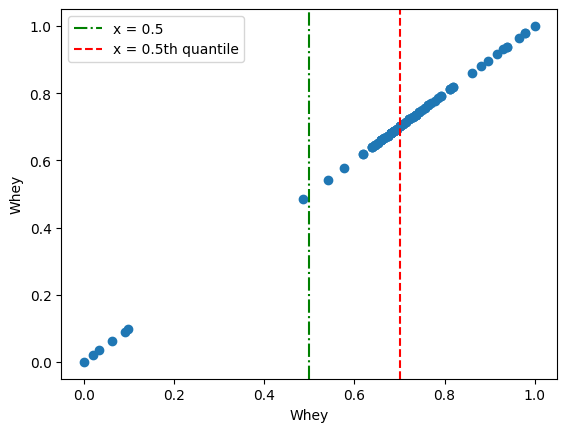

In [47]:
plt.plot(ipp_df['Whey'], ipp_df['Whey'], 'o')
plt.xlabel("Whey")
plt.ylabel("Whey")
plt.axvline(x=0.5, color='g', linestyle='-.',label="x = 0.5")
plt.axvline(x=ipp_df['Whey'].quantile(0.5), color='r', linestyle='--',label="x = 0.5th quantile")
plt.legend()

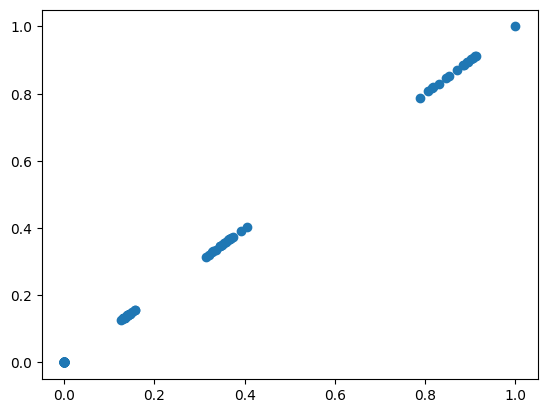

In [48]:
plt.plot(ipp_df['Wheat'], ipp_df['Wheat'], 'o')

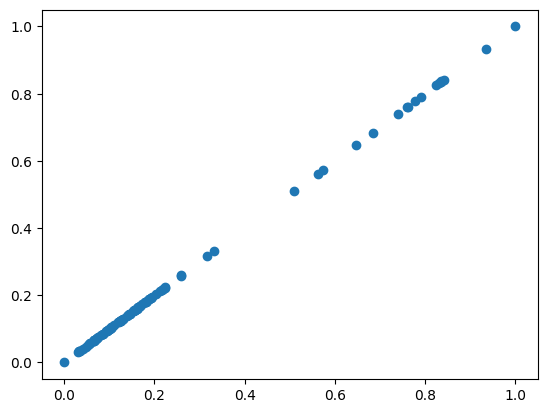

In [51]:
plt.plot(ipp_df['Oats'], ipp_df['Oats'], 'o')

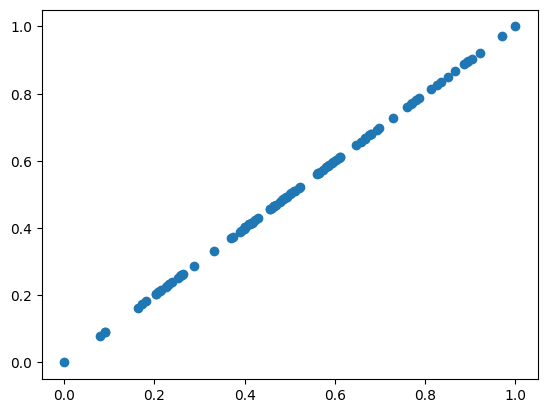

In [52]:
plt.plot(ipp_df['Linseed'], ipp_df['Linseed'], 'o')

Plot the boxplots of each variable to see the value distribution.

array([[<Axes: title={'center': 'Whey'}, xlabel='X'>,
        <Axes: title={'center': 'Flax'}, xlabel='X'>,
        <Axes: title={'center': 'Wheat'}, xlabel='X'>,
        <Axes: title={'center': 'Oats'}, xlabel='X'>,
        <Axes: title={'center': 'Linseed'}, xlabel='X'>],
       [<Axes: title={'center': 'Goji'}, xlabel='X'>,
        <Axes: title={'center': 'Bergamot'}, xlabel='X'>,
        <Axes: title={'center': 'Chocolate'}, xlabel='X'>,
        <Axes: title={'center': 'Banana'}, xlabel='X'>,
        <Axes: title={'center': 'Tapioca'}, xlabel='X'>],
       [<Axes: title={'center': 'Kiwi'}, xlabel='X'>,
        <Axes: title={'center': 'Pineapple'}, xlabel='X'>,
        <Axes: title={'center': 'Pear'}, xlabel='X'>,
        <Axes: title={'center': 'Cherry'}, xlabel='X'>,
        <Axes: title={'center': 'Mango'}, xlabel='X'>],
       [<Axes: title={'center': 'Grape'}, xlabel='X'>,
        <Axes: title={'center': 'Electrolyte'}, xlabel='X'>,
        <Axes: title={'center': 'Gooseberry'}

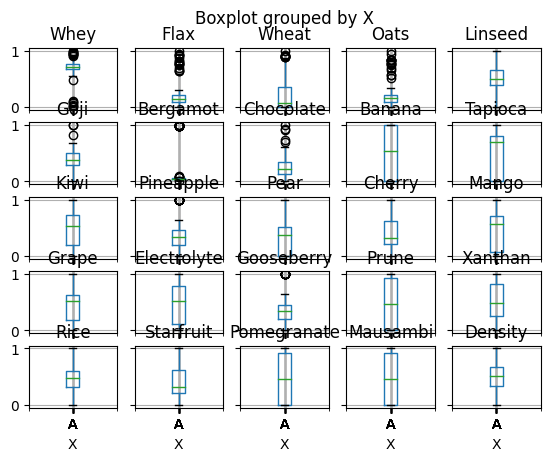

In [32]:
ipp_df['X'] = ['A']*len(ipp_df['Whey'])
ipp_df.boxplot(column=list(ipp_df)[:-1],by='X')

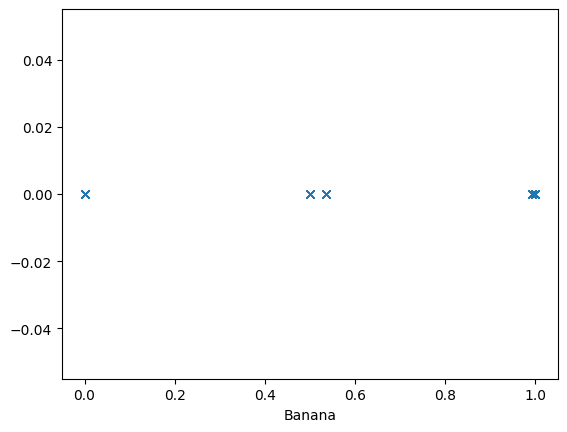

In [23]:
val = 0. # this is the value where you want the data to appear on the y-axis.
plt.plot(ipp_df['Banana'], np.zeros_like(ipp_df['Banana']) + val, 'x')
plt.xlabel("Banana")

plt.show()
# fig, ax = plt.subplots(figsize=(10, 5))
# ipp_df['Banana'].scatter(ax=ax)

<Axes: ylabel='Tapioca'>

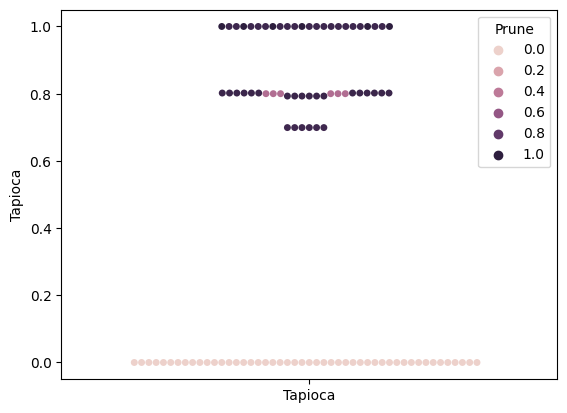

In [30]:
#xs = np.zeros(ipp_df['Banana'].shape[0])
xs = ["Tapioca"] *ipp_df['Tapioca'].shape[0]
sb.swarmplot(data=ipp_df, x=xs,y=ipp_df['Tapioca'], hue=ipp_df['Prune'])

<Axes: ylabel='Prune'>

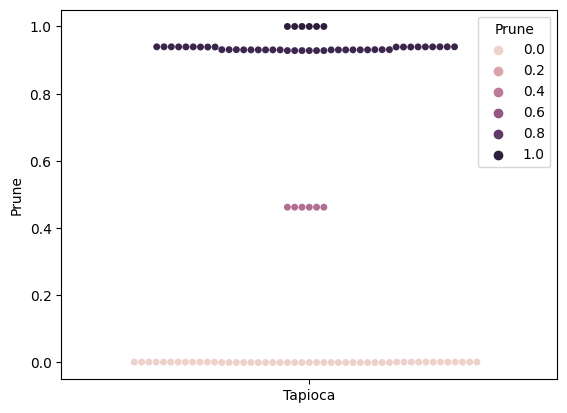

In [31]:
xs = ["Tapioca"] *ipp_df['Tapioca'].shape[0]
sb.swarmplot(data=ipp_df, x=xs,y=ipp_df['Prune'], hue=ipp_df['Prune'])

In [11]:
list(ipp_df)

['Whey',
 'Flax',
 'Wheat',
 'Oats',
 'Linseed',
 'Goji',
 'Density',
 'Chocolate',
 'Banana',
 'Tapioca',
 'Kiwi',
 'Pineapple',
 'Pear',
 'Cherry',
 'Mango',
 'Grape',
 'Electrolyte',
 'Gooseberry',
 'Prune',
 'Xanthan',
 'Rice',
 'Starfruit',
 'Pomegranate',
 'Mausambi',
 'Bergamot',
 'X']

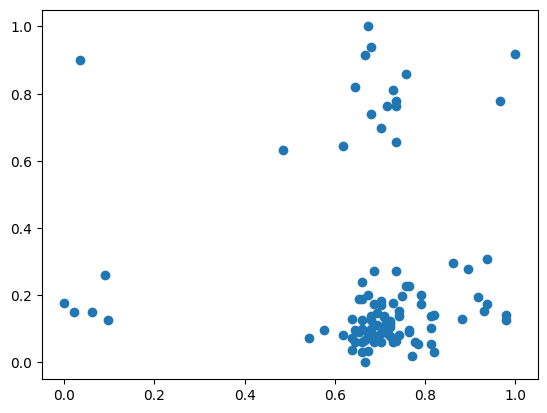

In [13]:
plt.plot(ipp_df['Whey'], ipp_df['Flax'], 'o')

In [16]:
print(ipp_df)

         Whey      Flax     Wheat      Oats   Linseed      Goji   Density   
1    0.652778  0.187552         0  0.104175  0.698214  0.407925       0.6  \
2      0.0625  0.151235   0.32101  0.156504  0.583929  0.298368  0.048485   
3    0.097222  0.127577  0.816066  0.123883  0.564286  0.272727         0   
4    0.743056  0.083135  0.871935  0.124365  0.478571  0.386946  0.139394   
5    0.673611  0.035598  0.156274  0.096859  0.485714  0.678322  0.172727   
..        ...       ...       ...       ...       ...       ...       ...   
98   0.819444   0.03206  0.157198  0.164109  0.510714  0.337995  0.130303   
99   0.638889  0.037035         0   0.09296  0.508929  0.370629  0.469697   
100  0.694444  0.111216  0.345646  0.033374  0.519643  0.365967  0.460606   
101  0.652778  0.089437         0  0.155404  0.523214  0.589744   0.80303   
102  0.708333  0.134874  0.807571  0.103249  0.264286  0.237762  0.478788   

    Chocolate    Banana Tapioca  ... Electrolyte Gooseberry     Prune   
1 

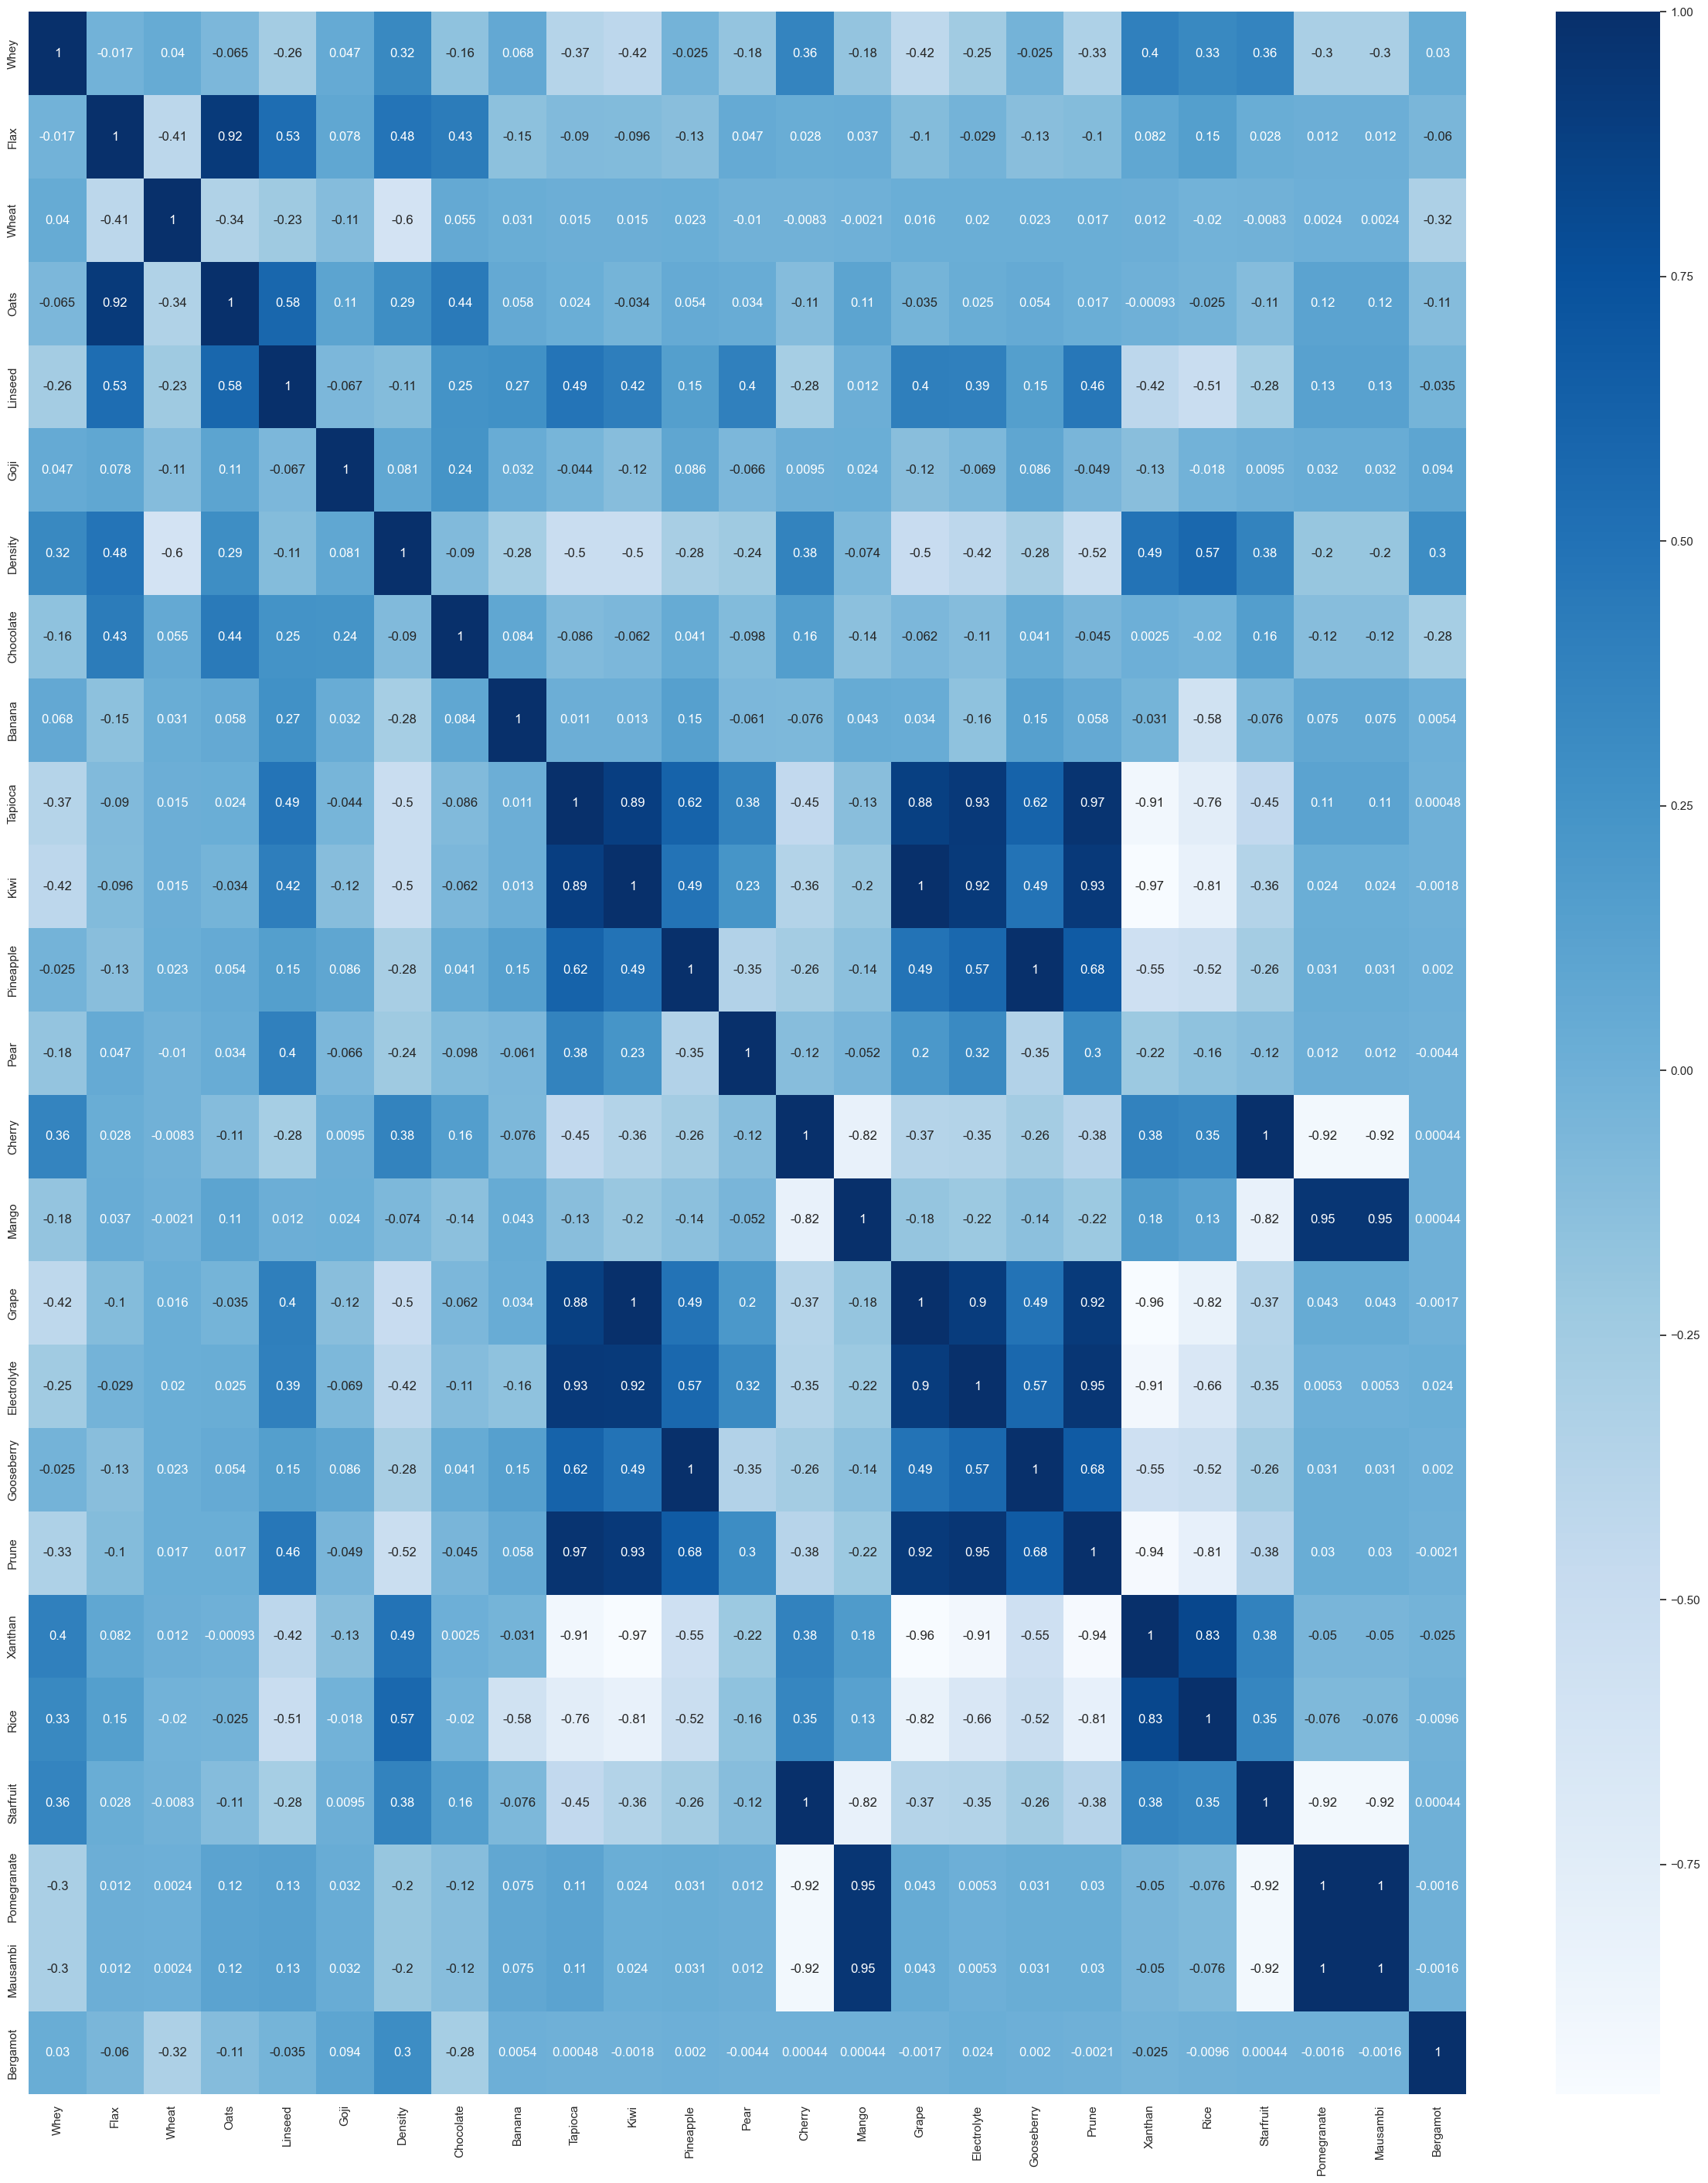

In [19]:
del ipp_df['X']
corr = ipp_df.corr()
sb.heatmap(corr, cmap="Blues", annot=True)
sb.set(rc={"figure.figsize":(30, 35)})

It looks like Mausambi and Pomegranate are the same.
Pineapple and gooseberry are the same
Grape and kiwi are the same
cherry and starfruit
Tapioca and prune are very similar
Kiwi and prune are very similar
Mango and mausambi are very similar
Mango and pomegranate are very similar
Grape and prune
grape and electrolyte
Celery is a constant value

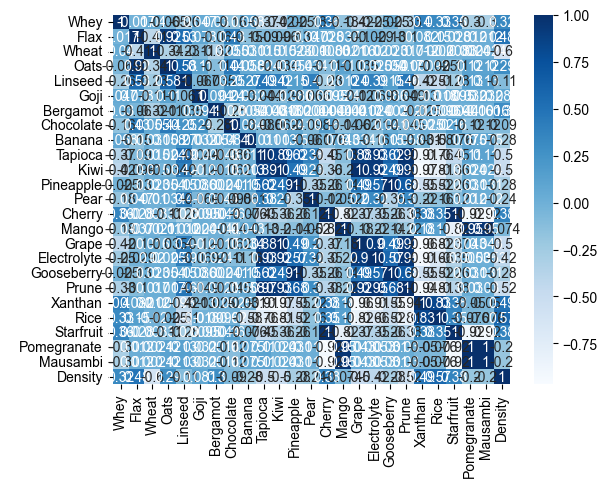

In [3]:
corr = ipp_df.corr()
sb.heatmap(corr, cmap="Blues", annot=True)
sb.set(rc={"figure.figsize":(30, 35)})

In [19]:
density_corr = np.abs(corr.to_numpy()[-1][:-1])
nums = np.arange(0,24,1)
corr_nums = sorted(zip(density_corr,nums),reverse=True)
print(corr_nums[:5])

[(0.601867773992707, 2), (0.5707484245022988, 20), (0.5215923585677855, 18), (0.5005119161920962, 9), (0.498713268732095, 10)]


<Axes: >

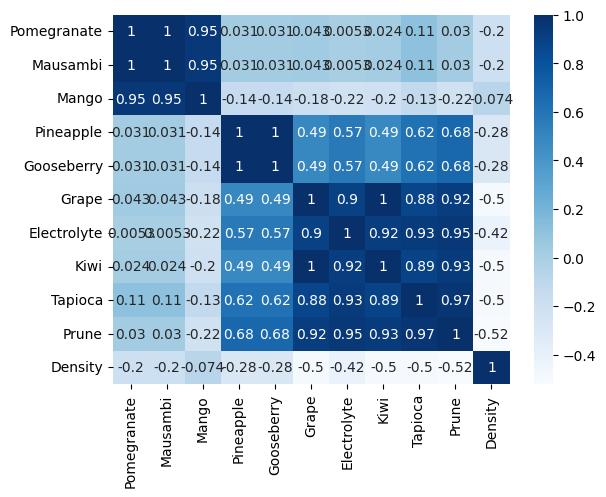

In [17]:
ipp_subset = ipp_df[['Pomegranate','Mausambi','Mango', 'Pineapple', 'Gooseberry','Grape','Electrolyte','Kiwi','Tapioca','Prune', 'Density']]
corr = ipp_subset.corr()
sb.heatmap(corr, cmap="Blues", annot=True)

In [20]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
ipp_reduced = SelectKBest(f_classif, k=15).fit_transform(ipp_df.iloc[:, ipp_df.columns != 'Density'].values, ipp_df['Density'].values)
print(ipp_reduced.shape)

(102, 15)


Extrapolation data strategy (modified from onion):
1) Take the means of every column to be the midpoint of the whole data to work out from in the manner of the onion.
2) Define a function that calculates the distance of every one of the 102 points in the ipp plant dataset from the midpoint
3) increase the cutoff bound for the extrapolation set until there are only 20 points in the extrapolation set.
4) Take the rest to be the interpolation set and split that as 80:20 for test train.

Train data size: 66 points
Test data size: 16 points
Extrapolation set size: 20 points

In [21]:
ipp_quantiles = ipp_df.iloc[:,(ipp_df.columns != 'Density')& (ipp_df.columns != 'Celery')].quantile([0.5])
ipp_quantiles

Whey      Flax     Wheat      Oats Linseed     Goji Chocolate   
0.5  0.701389  0.132386  0.063324  0.153522  0.4875  0.37296  0.216253  \

       Banana Tapioca      Kiwi  ...    Grape Electrolyte Gooseberry   
0.5  0.535015  0.6991  0.527333  ...  0.53012    0.524096   0.338752  \

        Prune   Xanthan      Rice Starfruit Pomegranate  Mausambi  Bergamot  
0.5  0.462192  0.493353  0.474725    0.3171    0.461922  0.461922  0.051402  

[1 rows x 24 columns]

In [22]:
ranges = np.array([np.max(ipp_df[column])-np.min(ipp_df[column]) for column in ipp_df.columns])
ranges

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1])

In [23]:
steps = ranges/20

In [24]:
train_ipp = ipp_df.iloc[:, (ipp_df.columns != 'Density')& (ipp_df.columns != 'Celery')]
step_num = 12
i=0
for i in range(len(train_ipp.columns)):
  name = train_ipp.columns[i]
  train_ipp = train_ipp[(train_ipp[name]>(ipp_quantiles[name].iloc[0]-steps[i]*step_num)) & (train_ipp[name] < (ipp_quantiles[name].iloc[0]+steps[i]*step_num))]
  print(name,train_ipp.shape)

Whey (96, 24)
Flax (84, 24)
Wheat (68, 24)
Oats (67, 24)
Linseed (67, 24)
Goji (66, 24)
Chocolate (65, 24)
Banana (65, 24)
Tapioca (34, 24)
Kiwi (34, 24)
Pineapple (26, 24)
Pear (18, 24)
Cherry (18, 24)
Mango (18, 24)
Grape (18, 24)
Electrolyte (18, 24)
Gooseberry (18, 24)
Prune (18, 24)
Xanthan (18, 24)
Rice (18, 24)
Starfruit (18, 24)
Pomegranate (18, 24)
Mausambi (18, 24)
Bergamot (14, 24)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


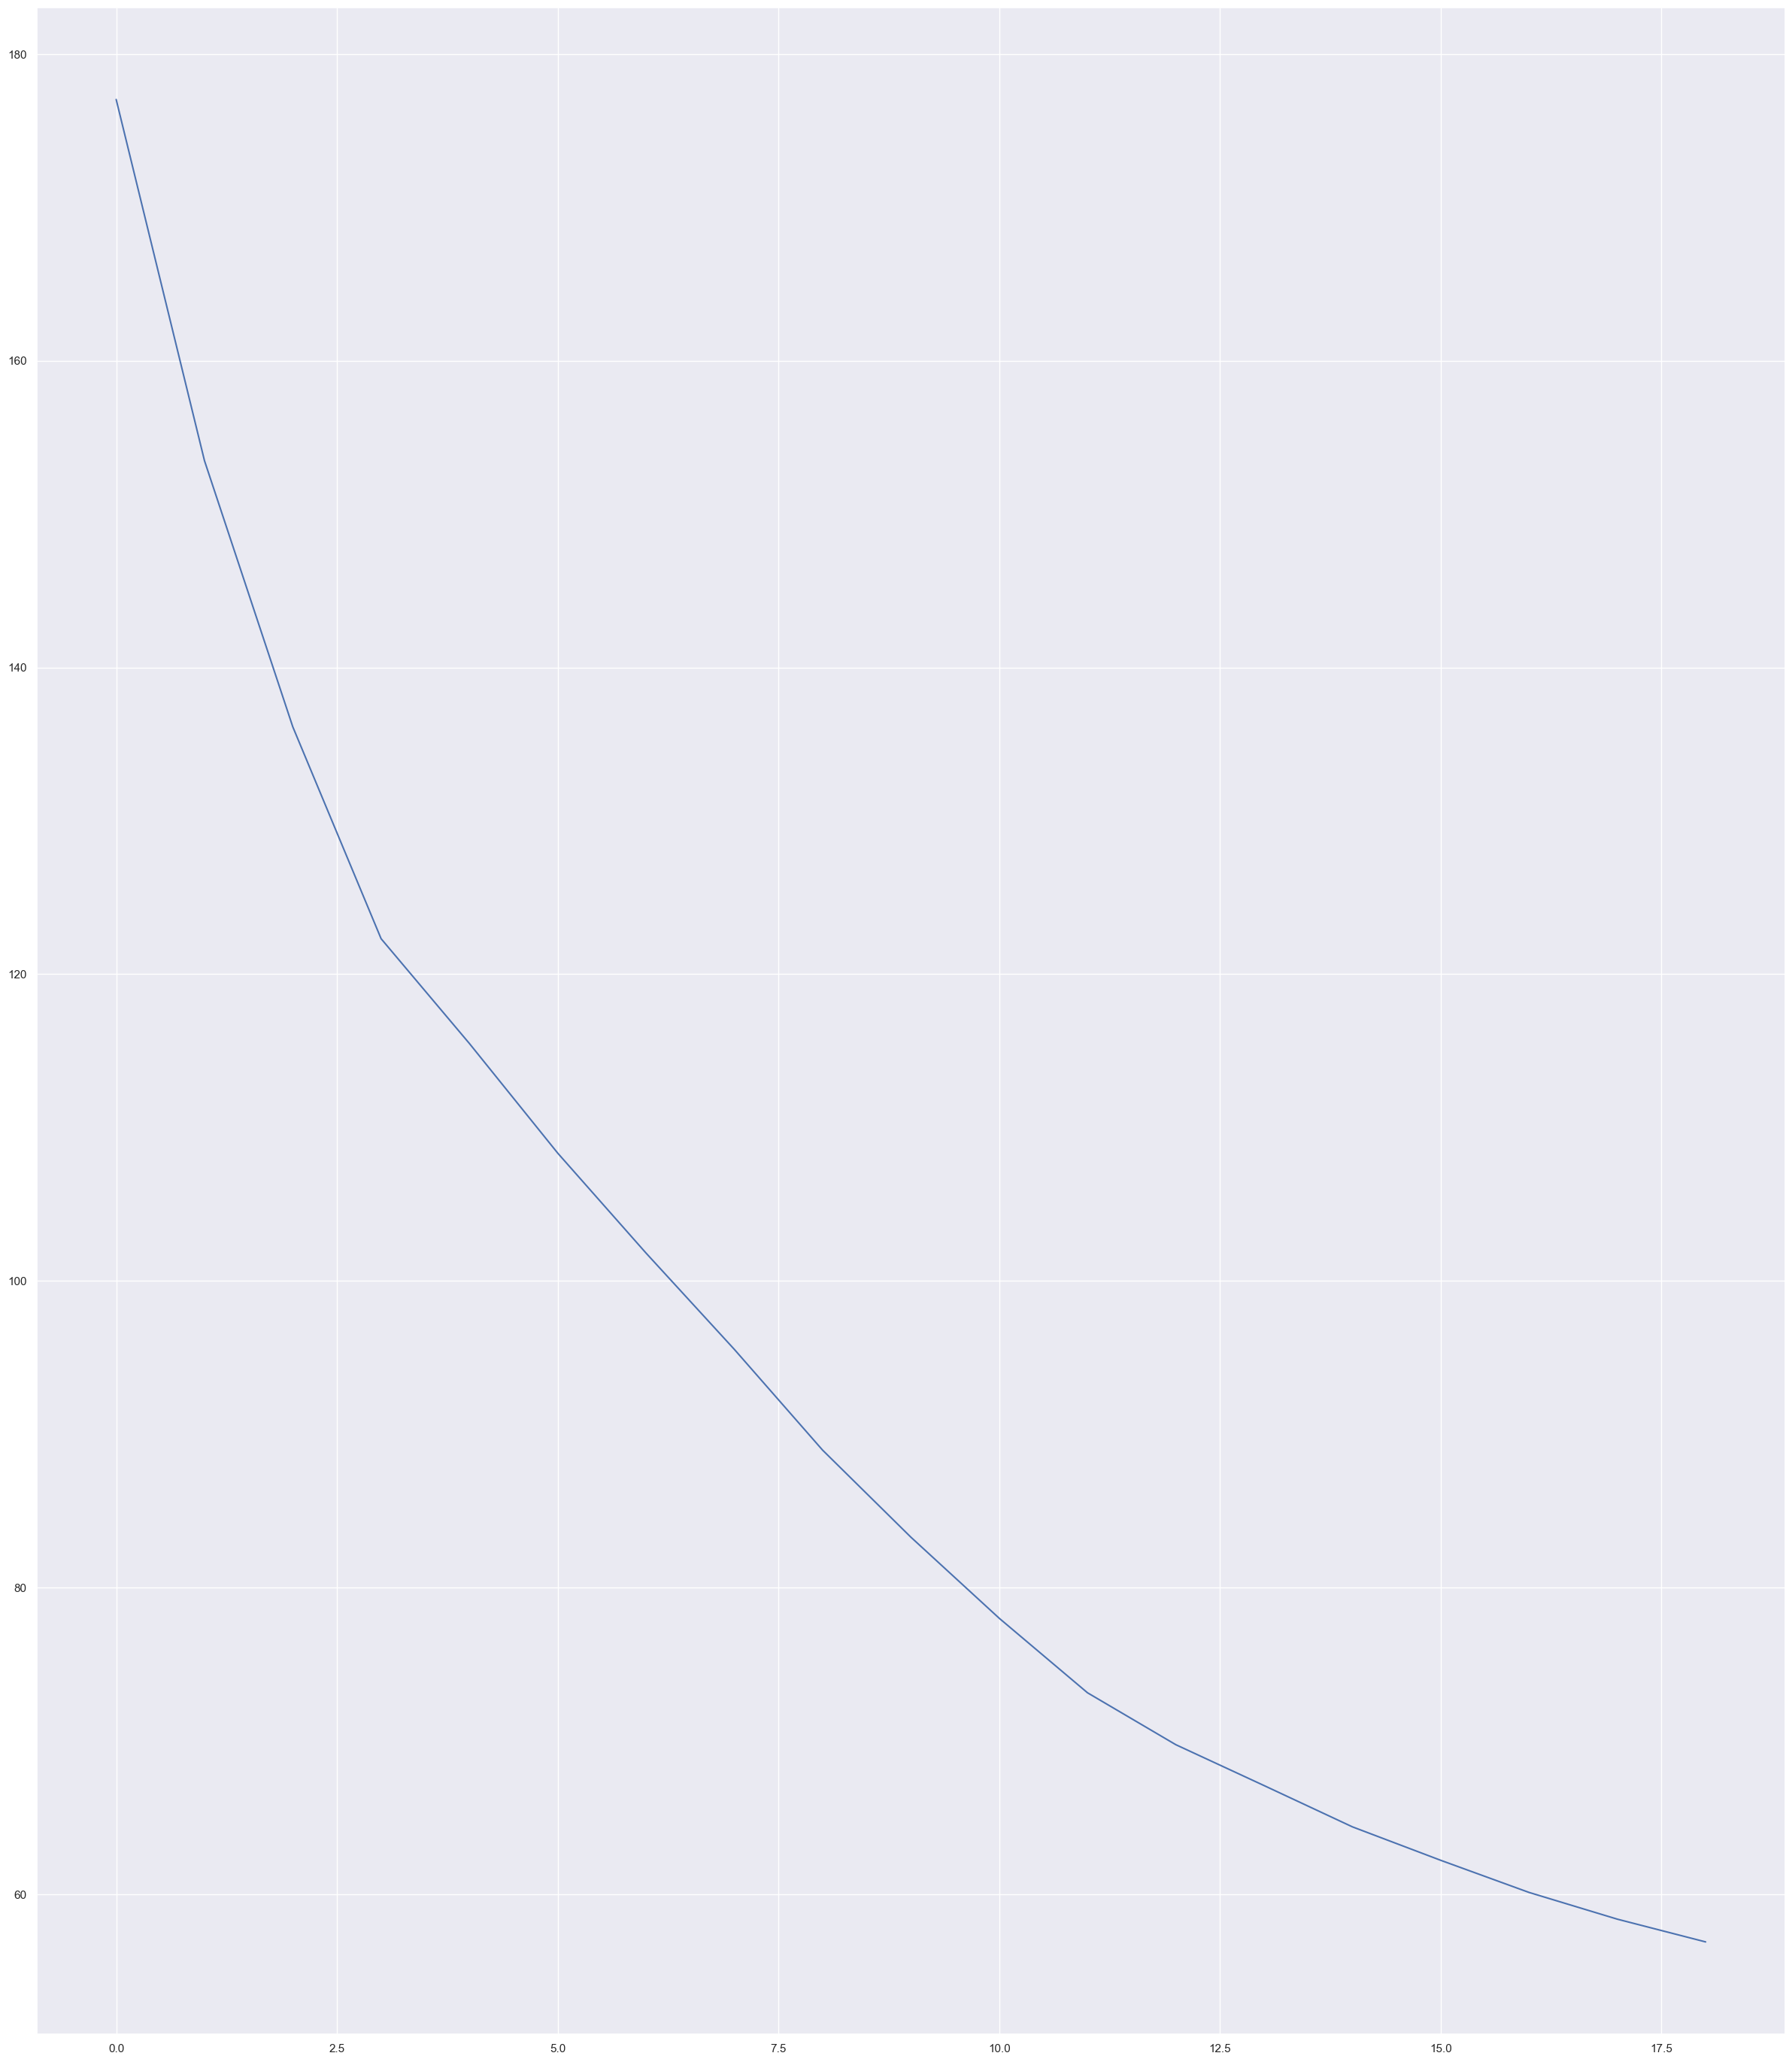

In [26]:
X = ipp_df.iloc[:,(ipp_df.columns != 'Density')]
diss = euclidean_distances(X)
losses = []
num = 20
for i in range(1,num):
  print(i)
  fp = kmedoids.fasterpam(diss, i)
  losses.append(fp.loss)
plt.plot(range(num-1),losses)

Using the elbow method, we can see that 5 mediods will be a good number.

In [27]:
X = ipp_df.iloc[:,(ipp_df.columns != 'Density')]
diss = euclidean_distances(X)
fp = kmedoids.fasterpam(diss, 5)

In [28]:
print(fp)

KMedoidsResult(loss=115.15868697770419, labels=[4 3 3 4 1 1 3 3 3 0 0 2 4 4 4 4 2 2 2 2 2 2 4 4 4 4 4 4 0 0 0 0 2 2 2 2 2
 3 3 4 4 4 4 4 4 4 4 4 4 1 1 1 3 3 3 0 0 0 0 0 0 2 2 2 2 2 2 3 3 3 3 3 3 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 2 2 2 2 4 0 0 2 3 3 4 1 0 1 2], medoids=[78 82 11  7 23], n_iter=3, n_swaps=11)


In [29]:
unique, counts = np.unique(fp.labels, return_counts=True)

In [30]:
dict(zip(unique, counts))

{0: 24, 1: 12, 2: 24, 3: 18, 4: 24}

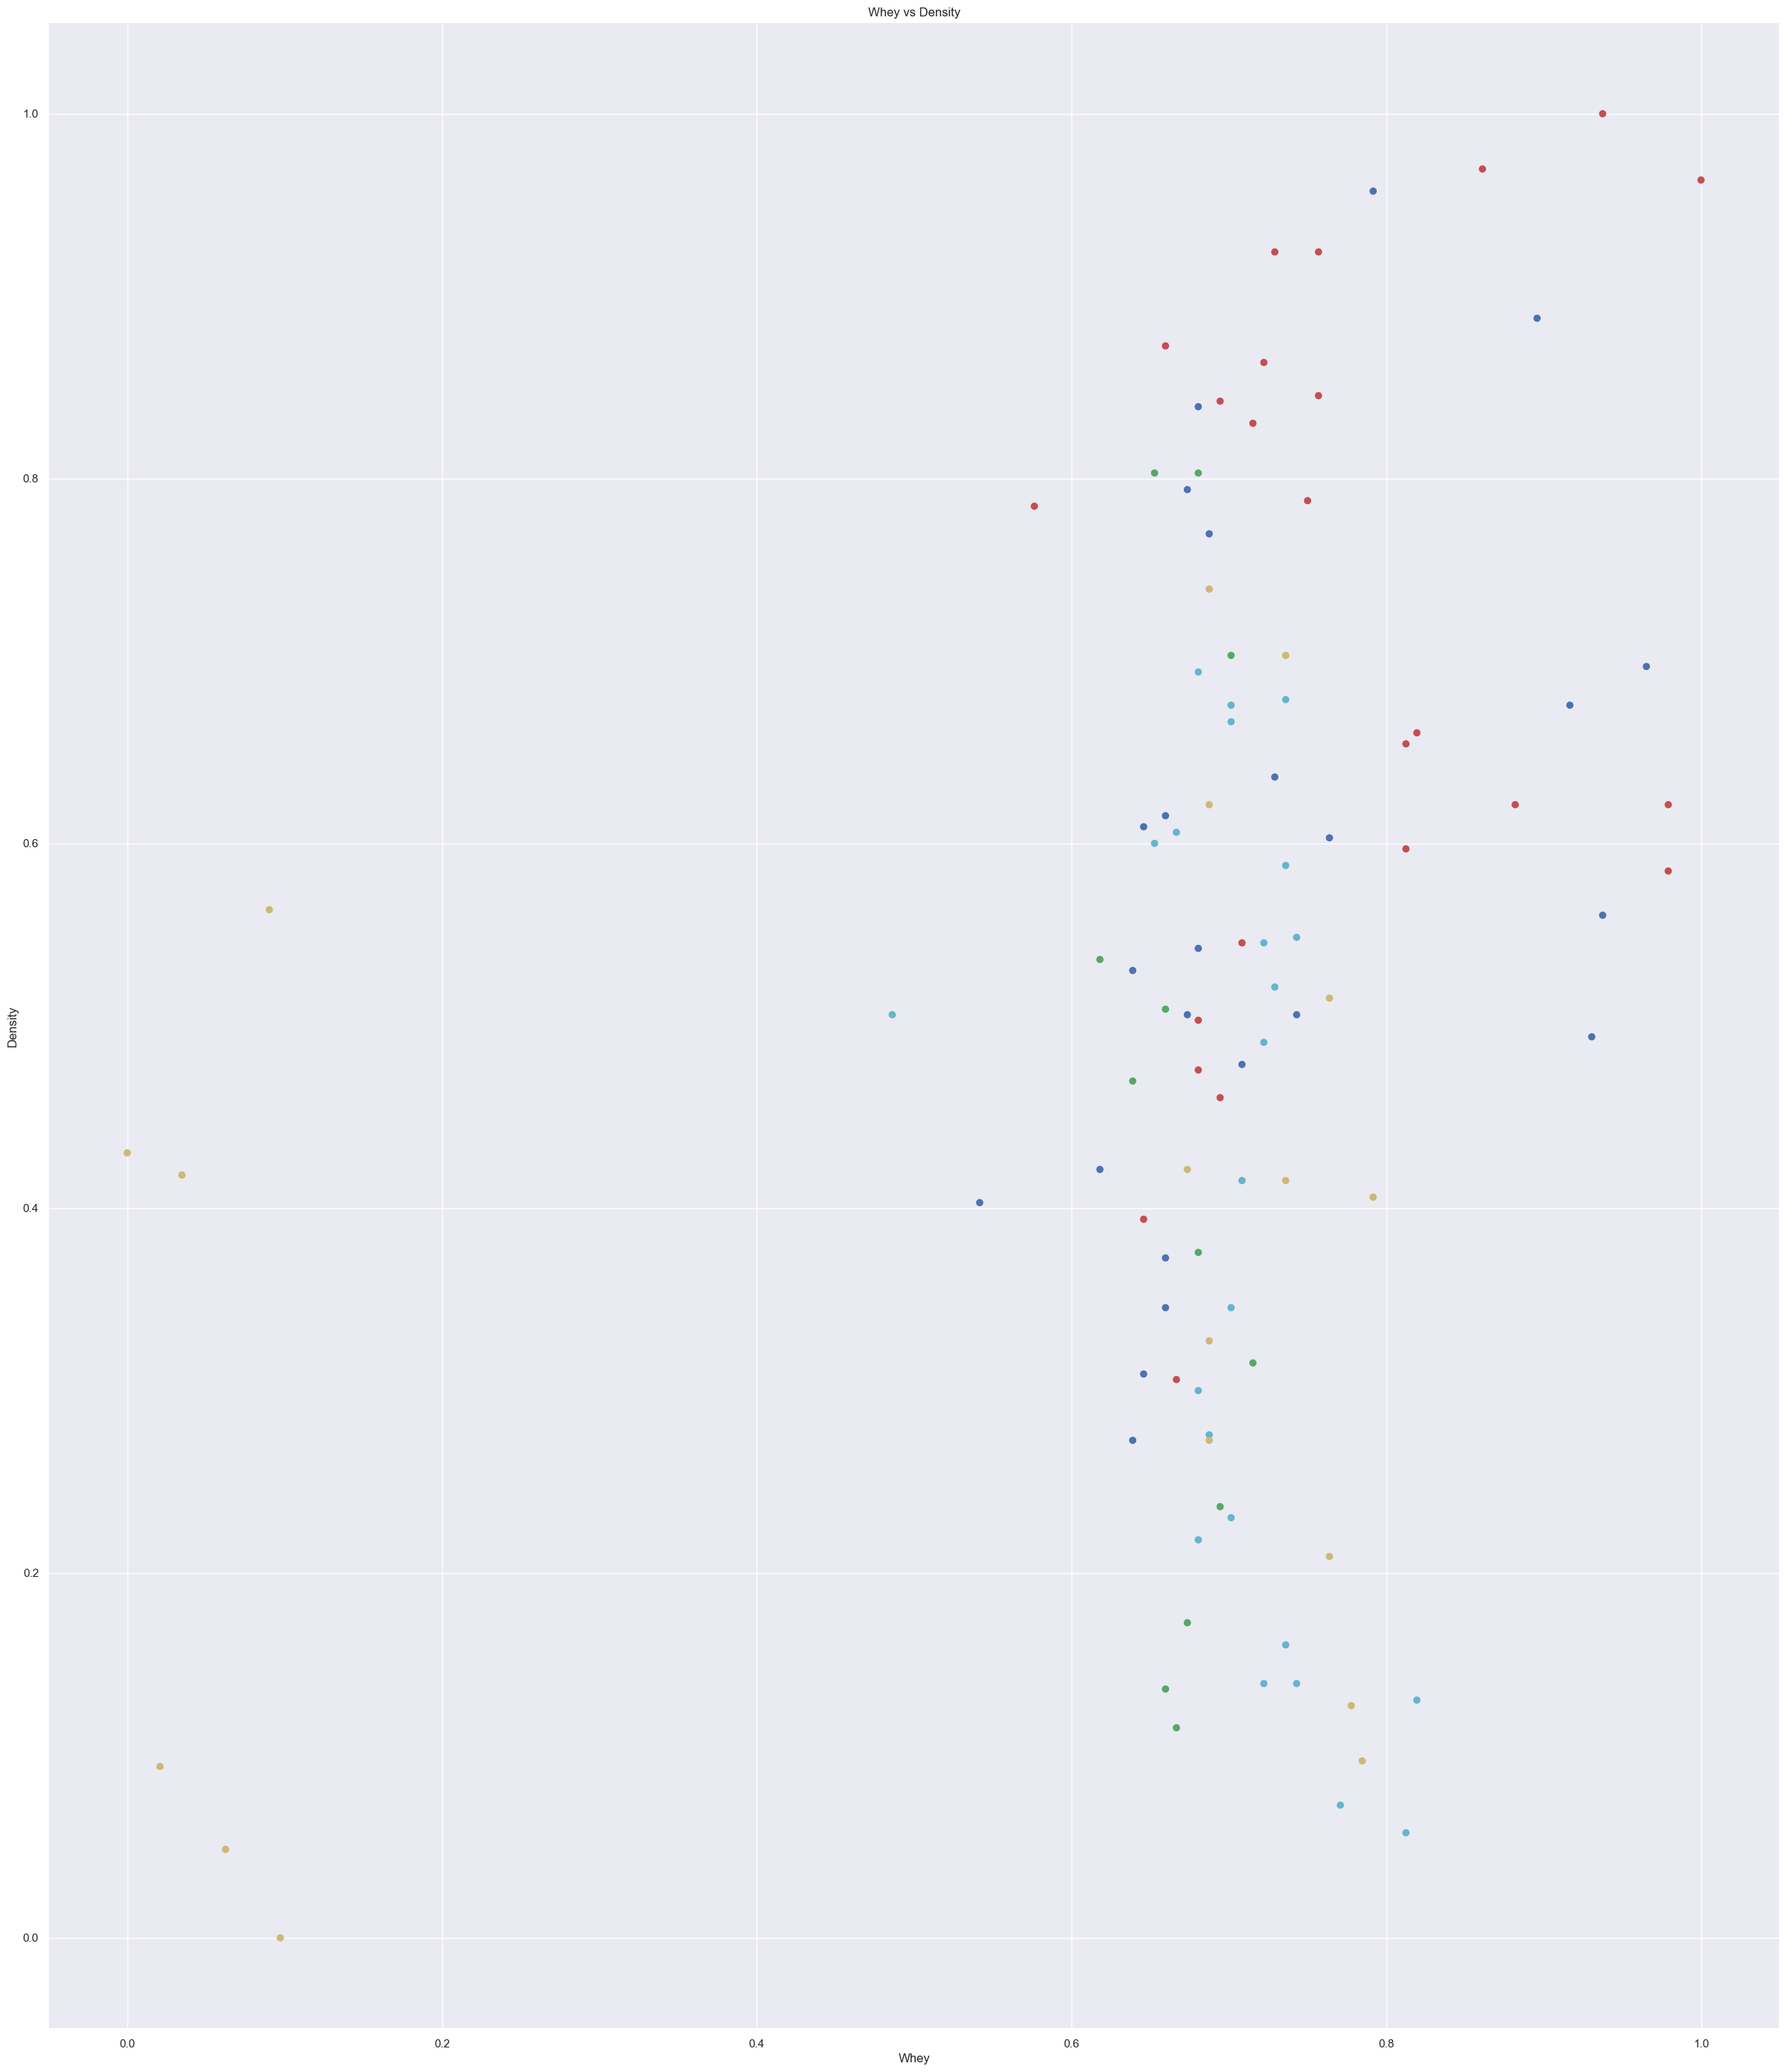

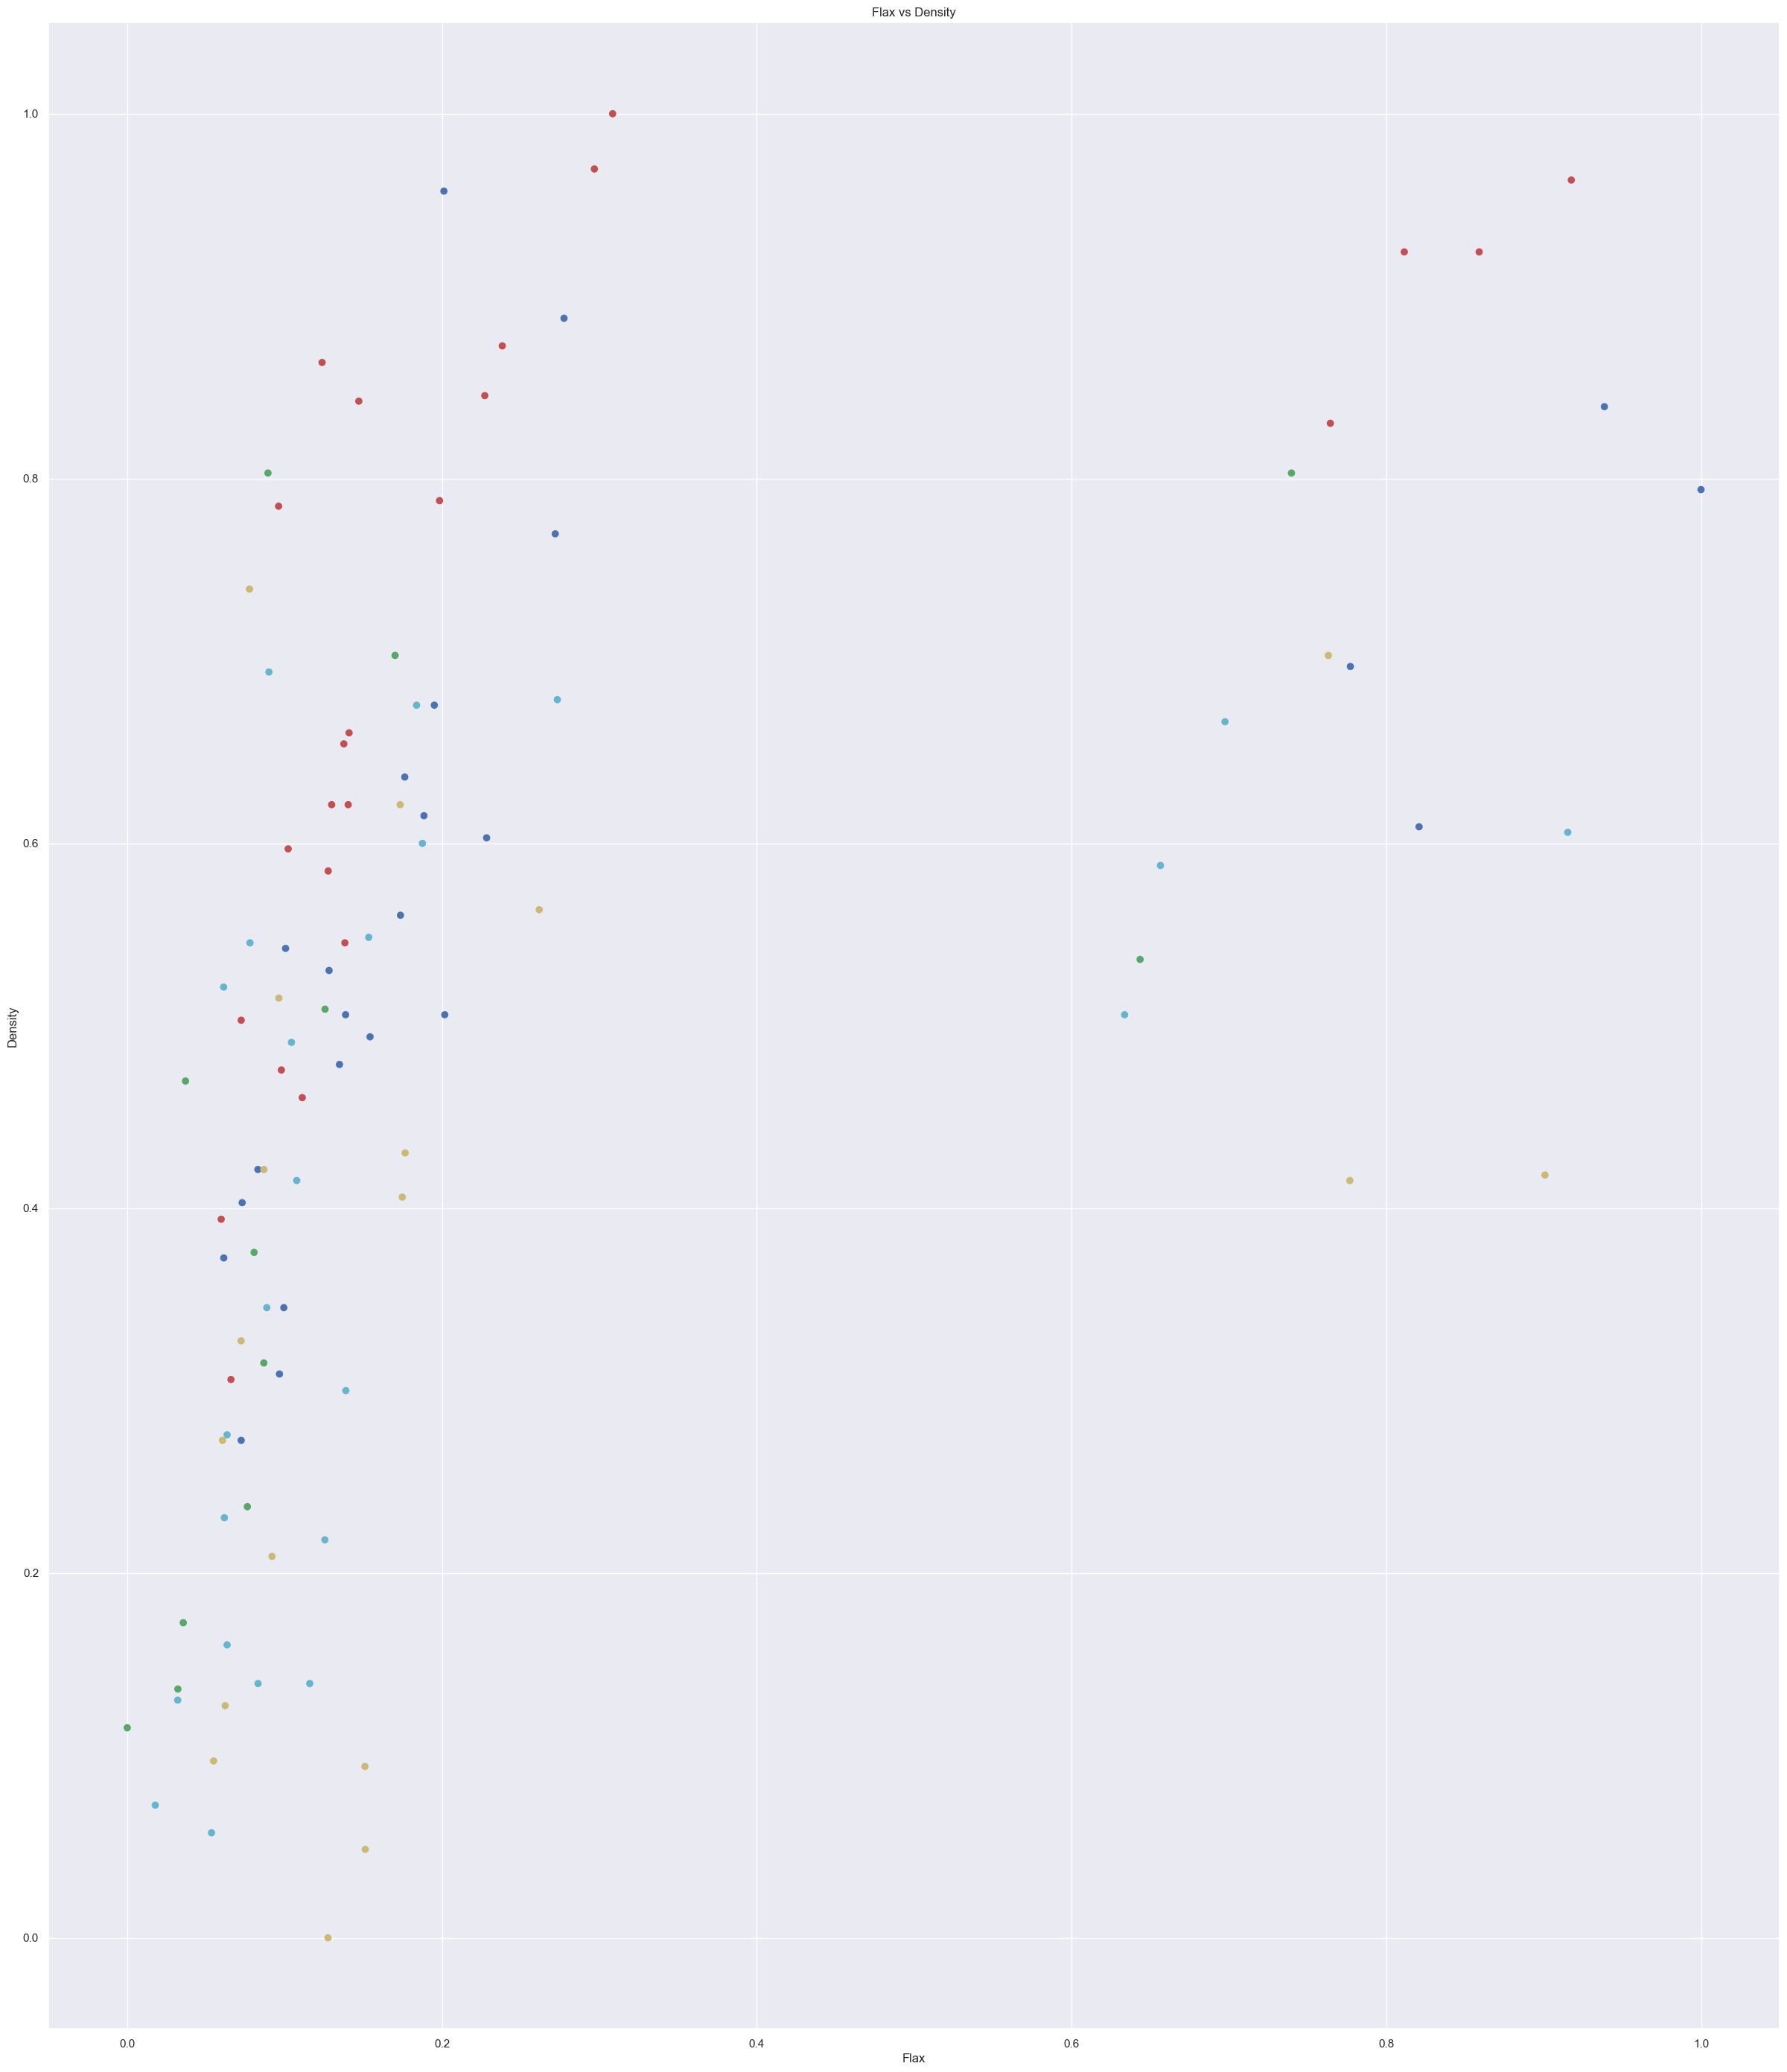

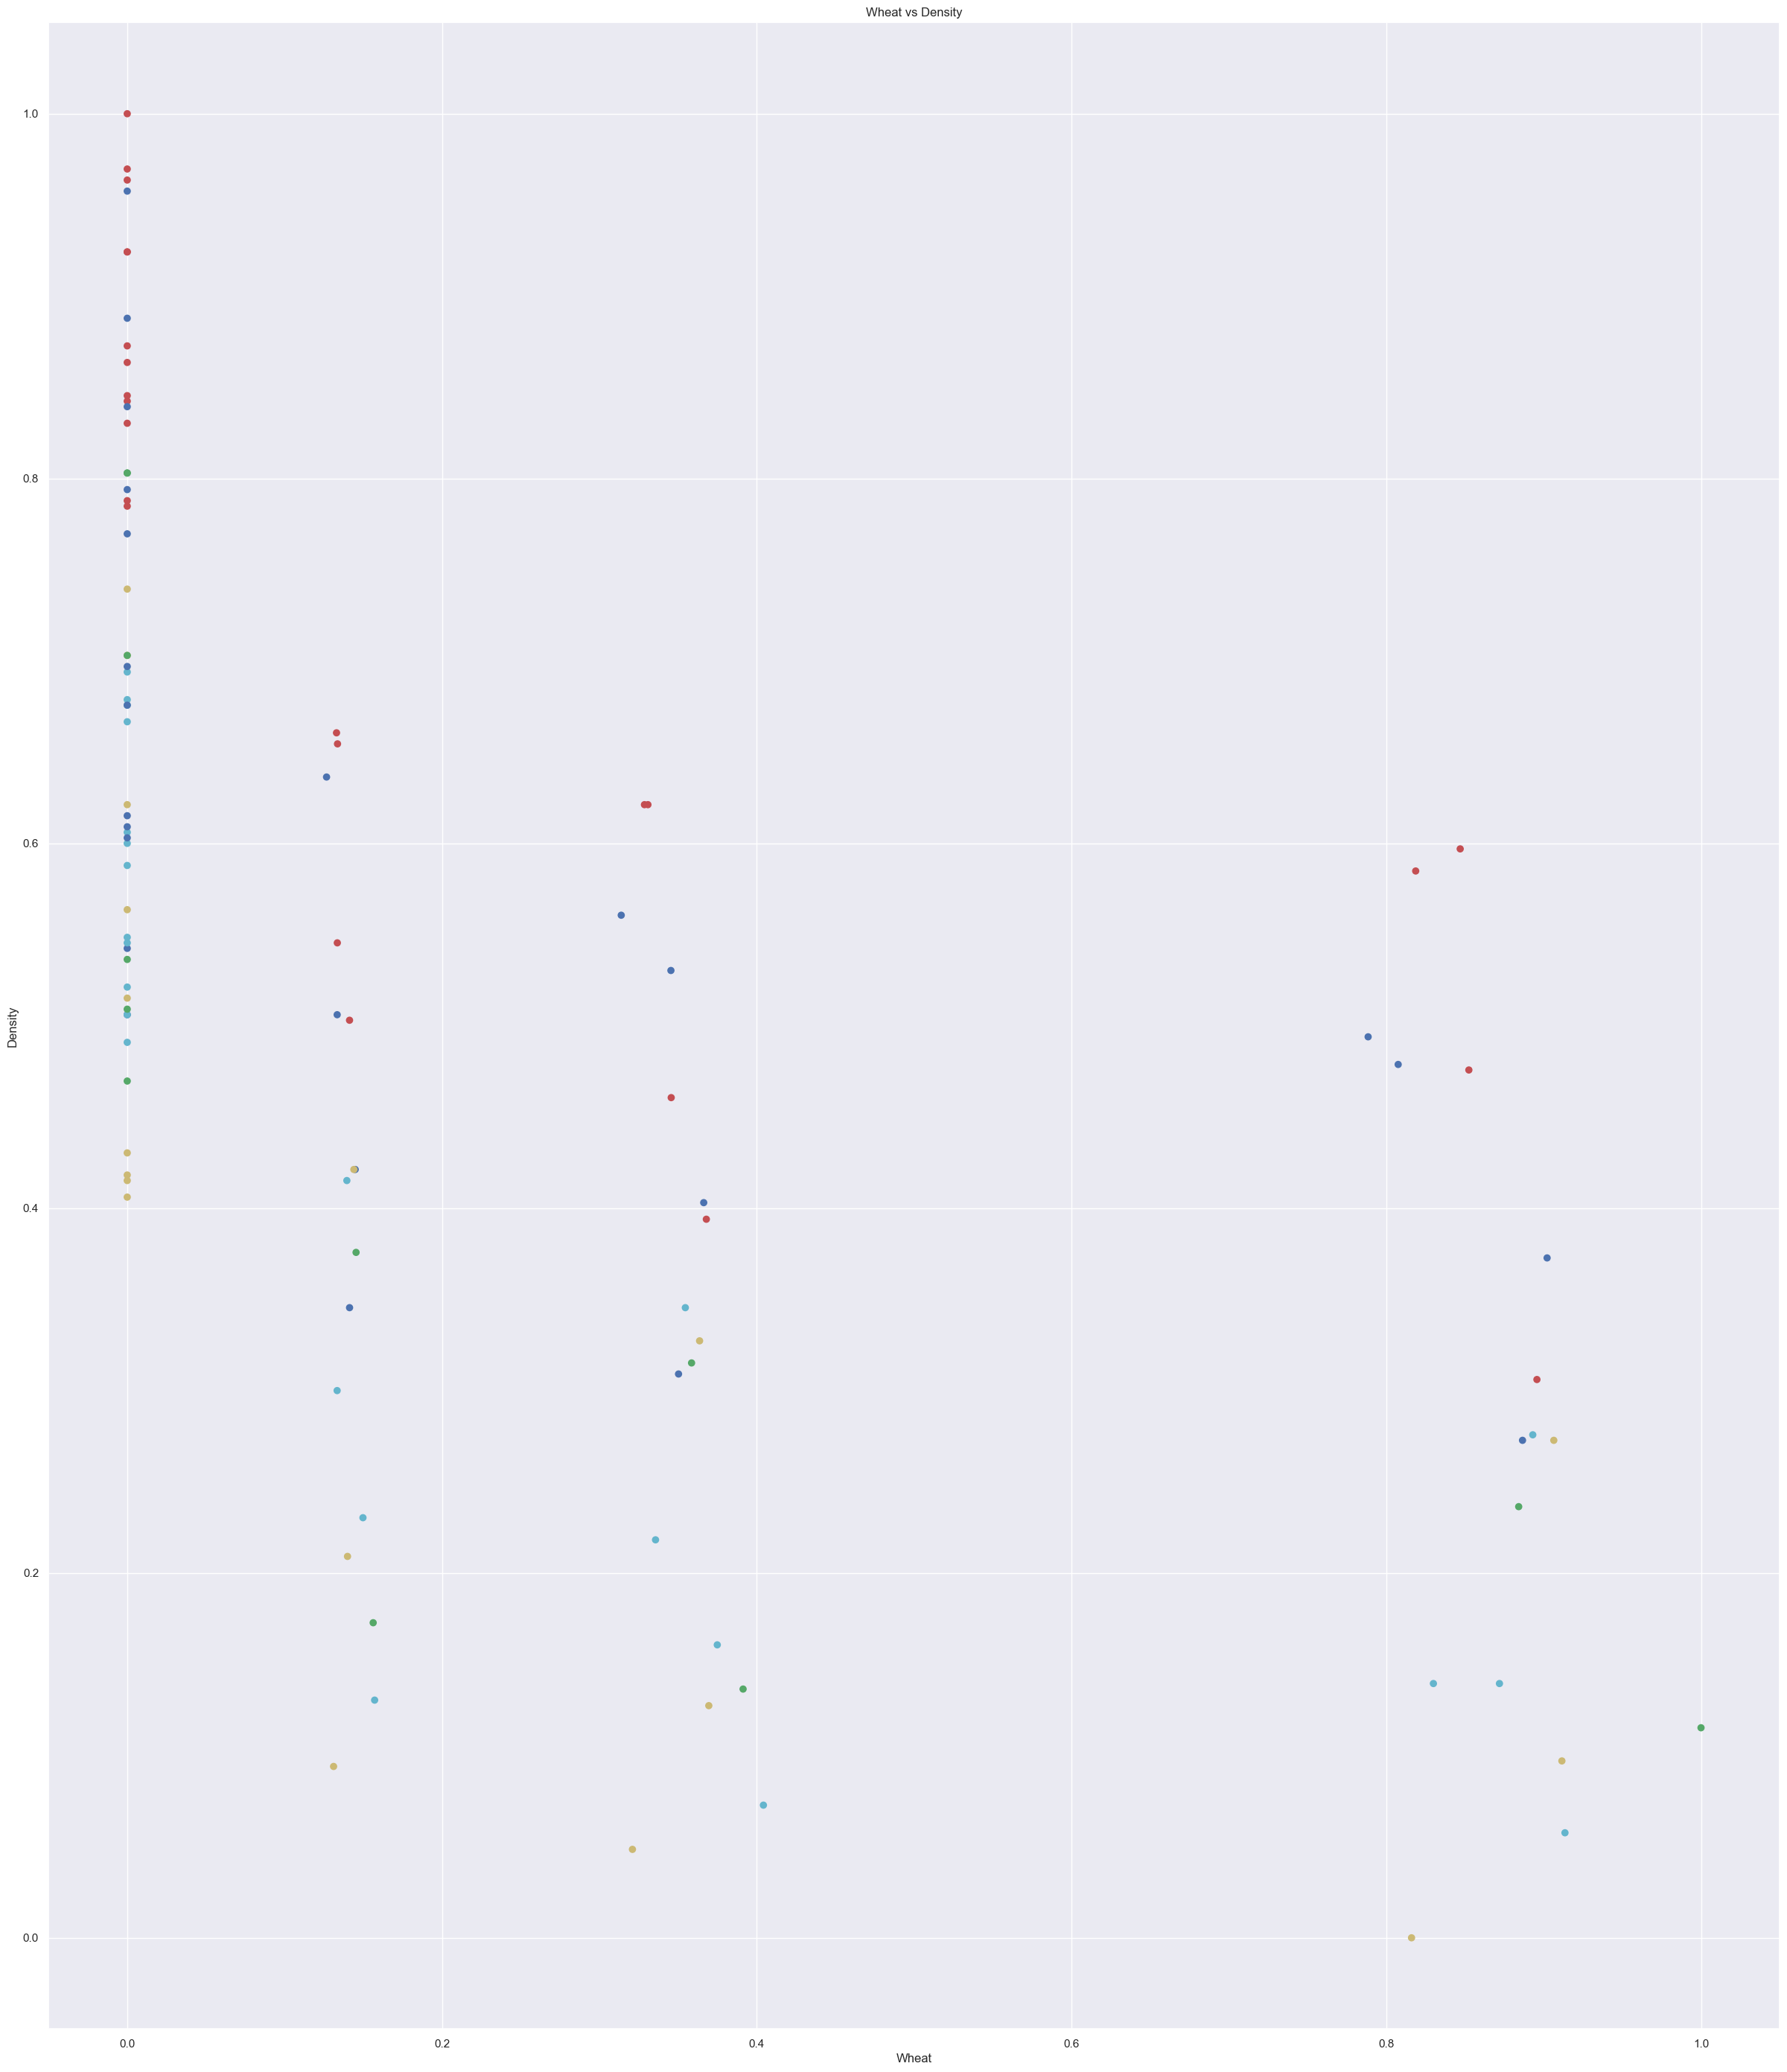

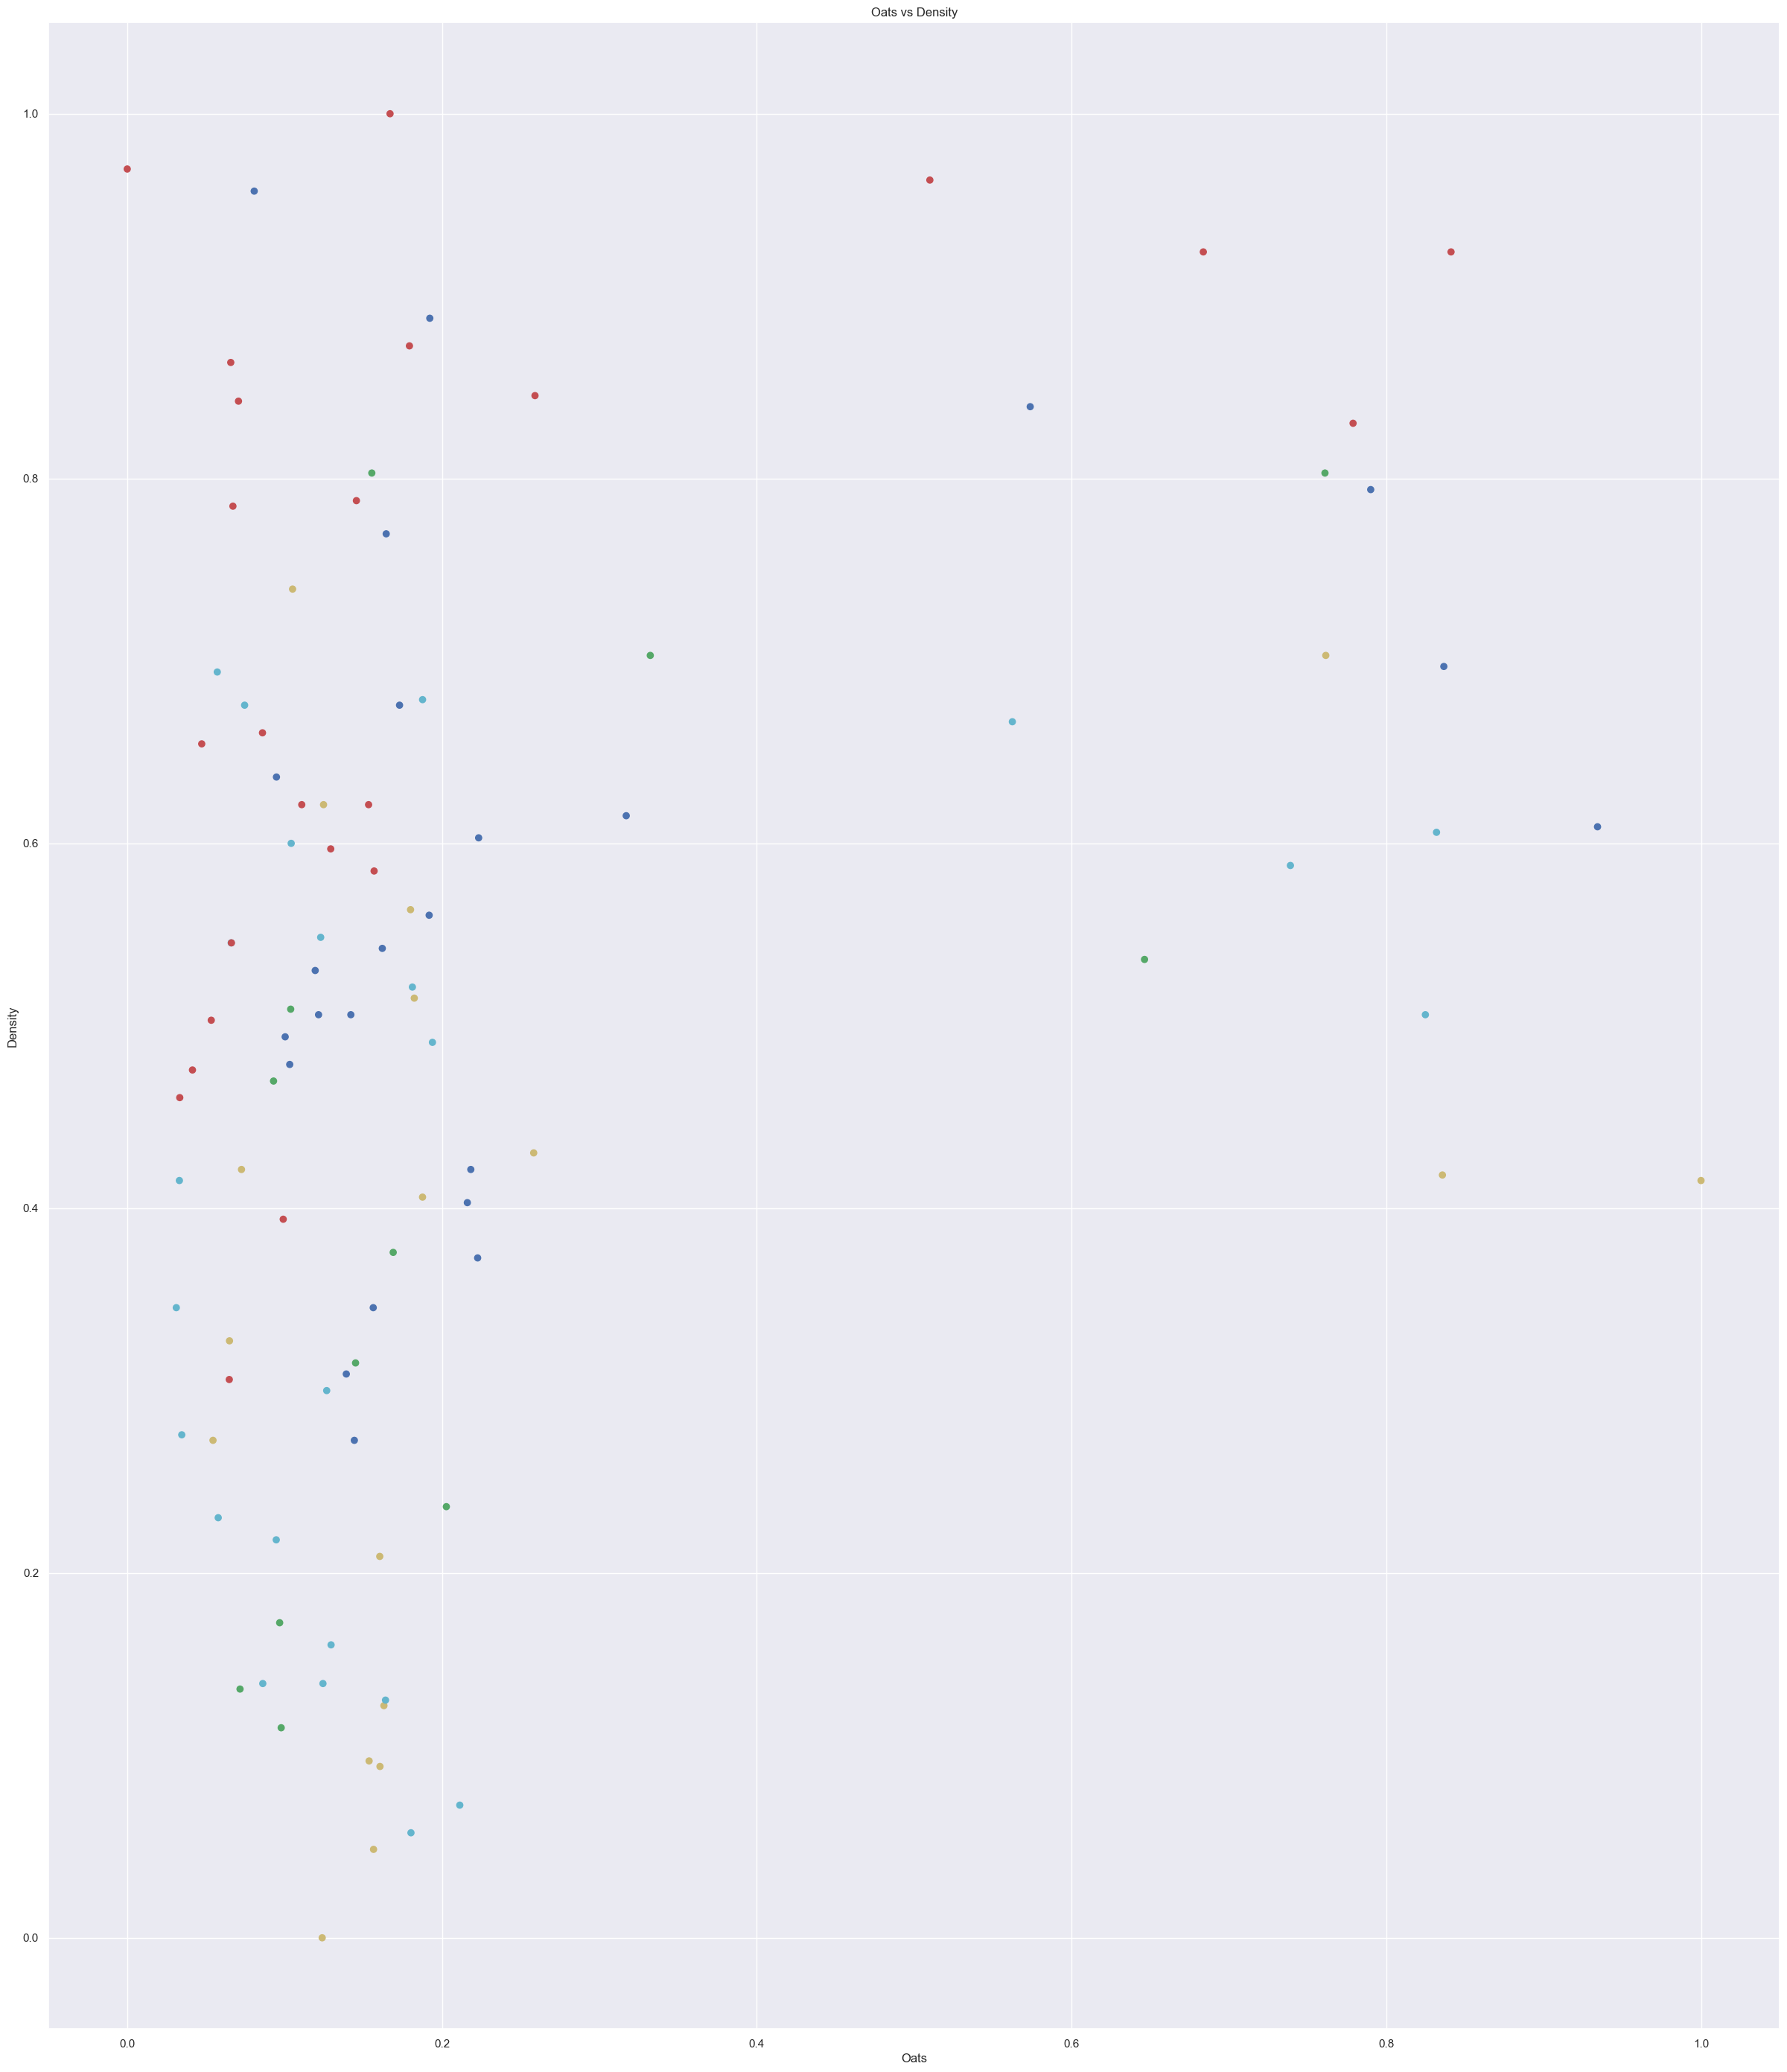

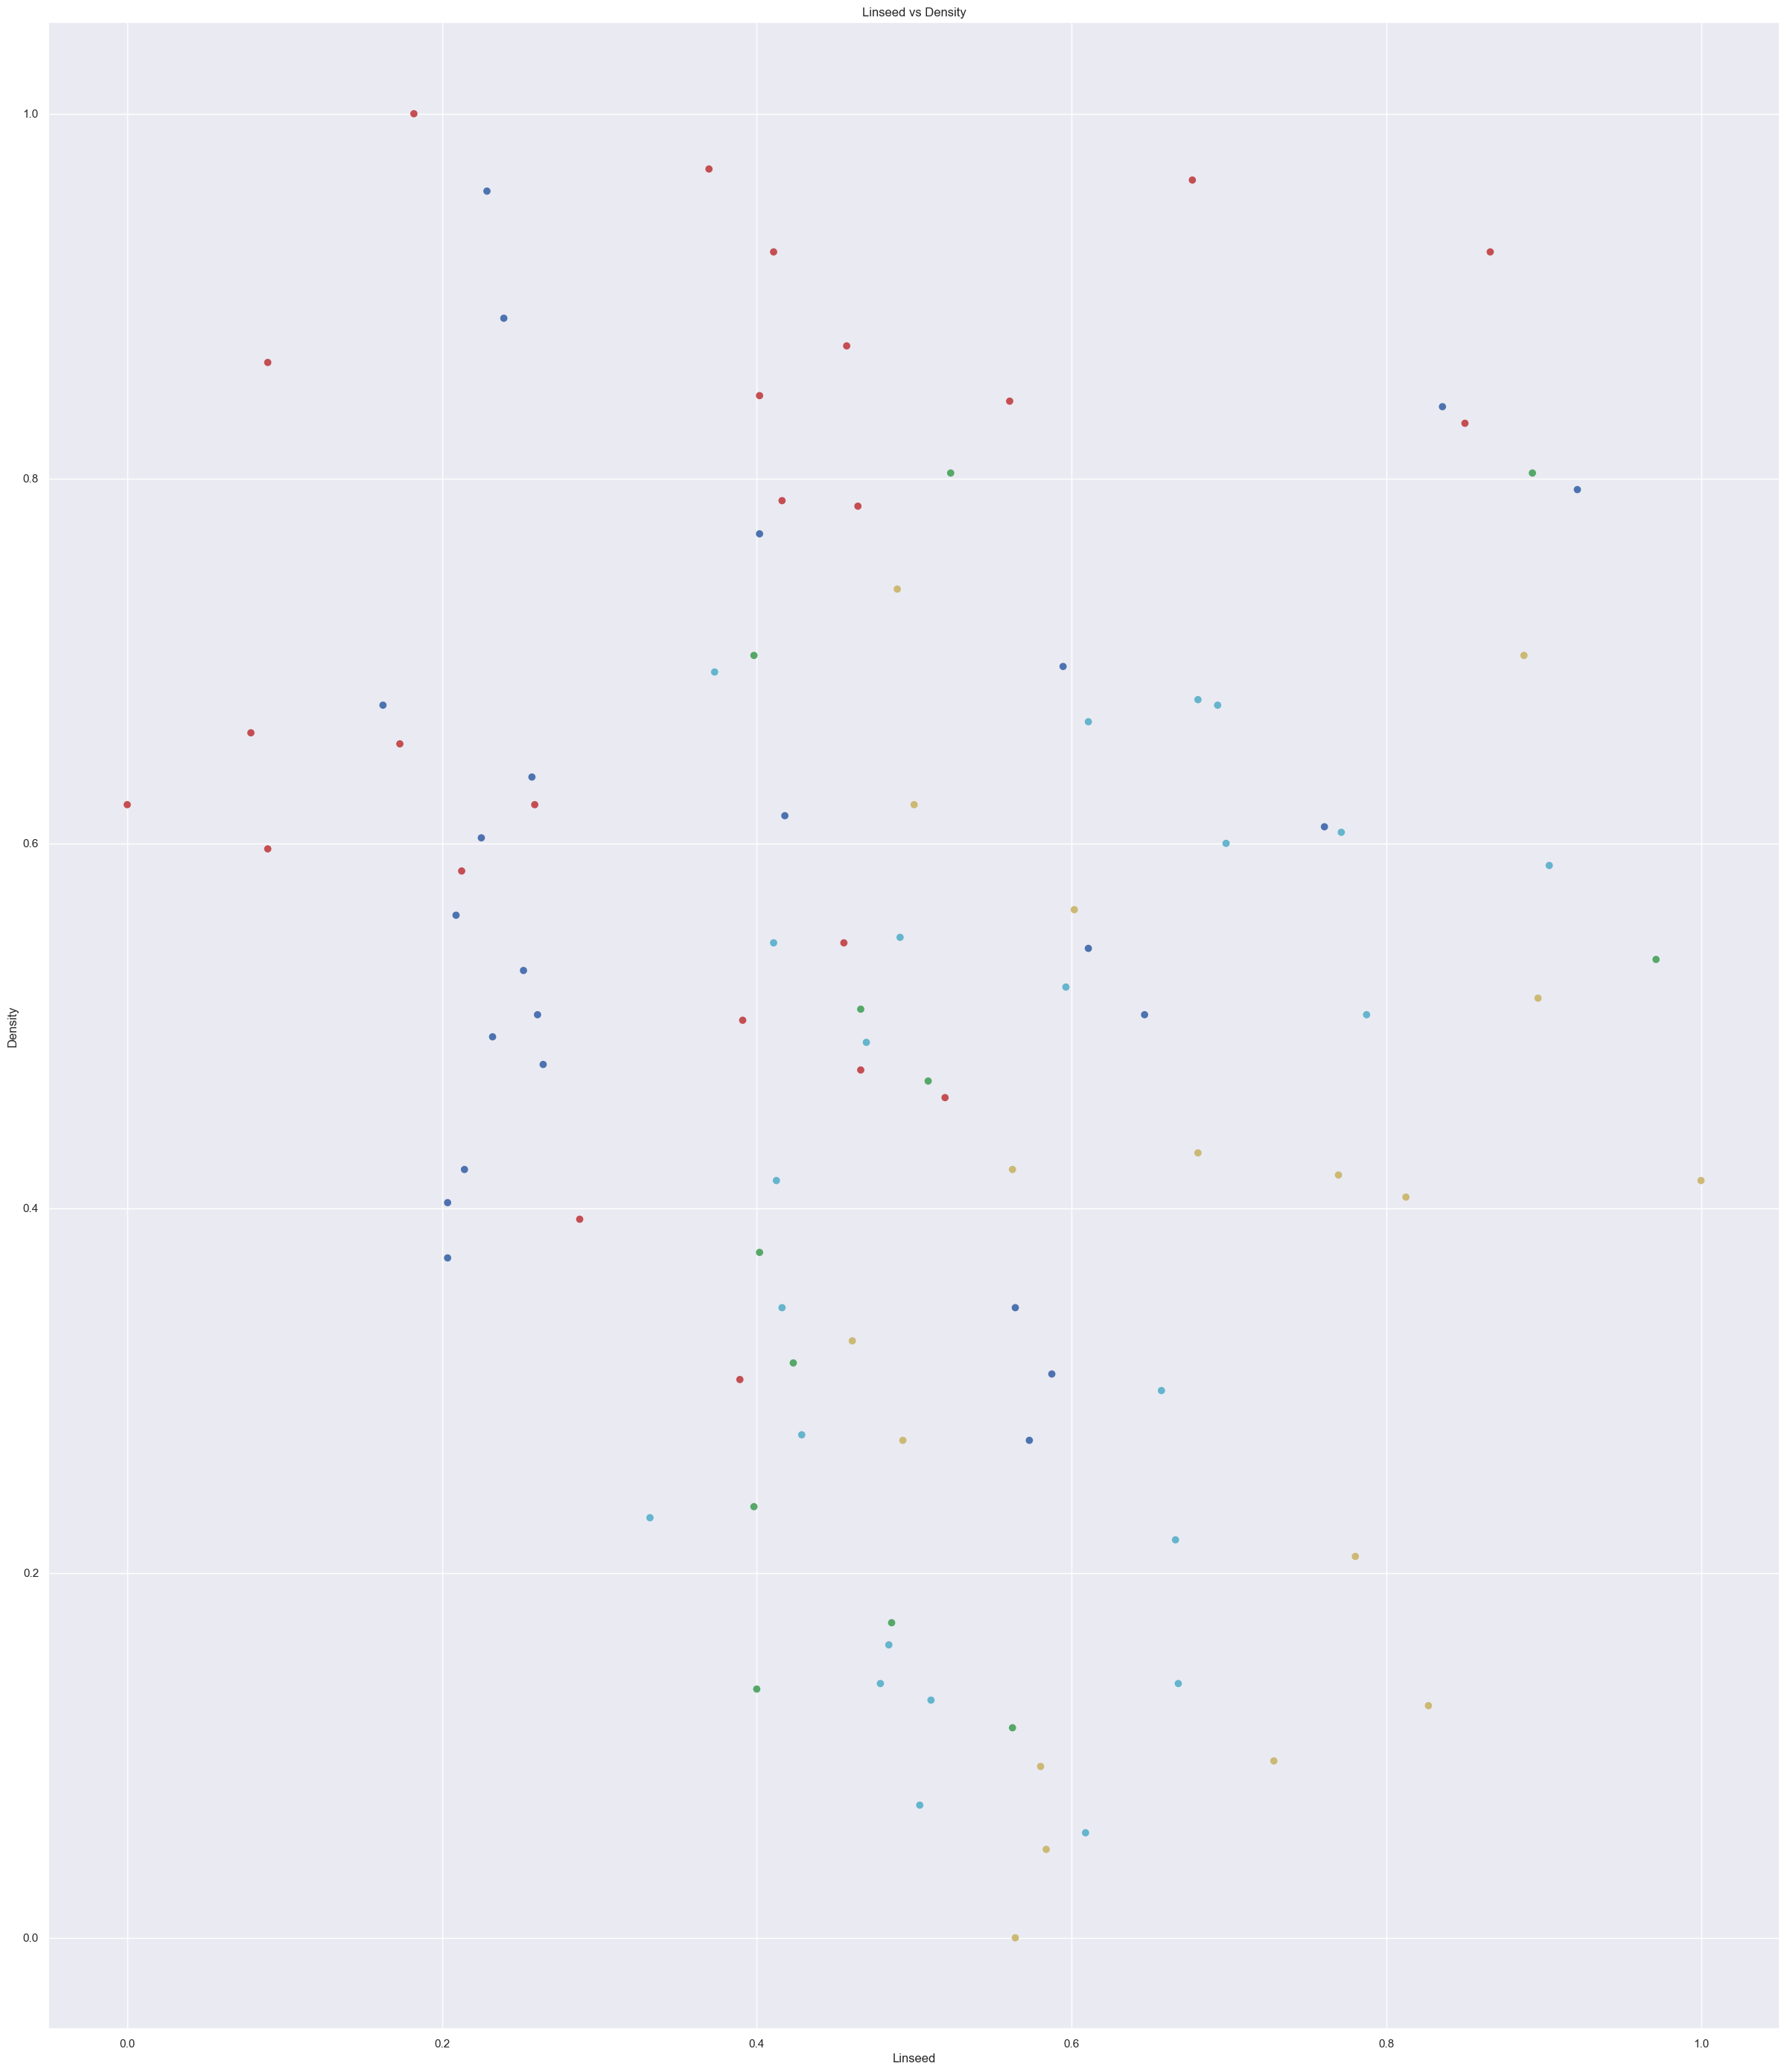

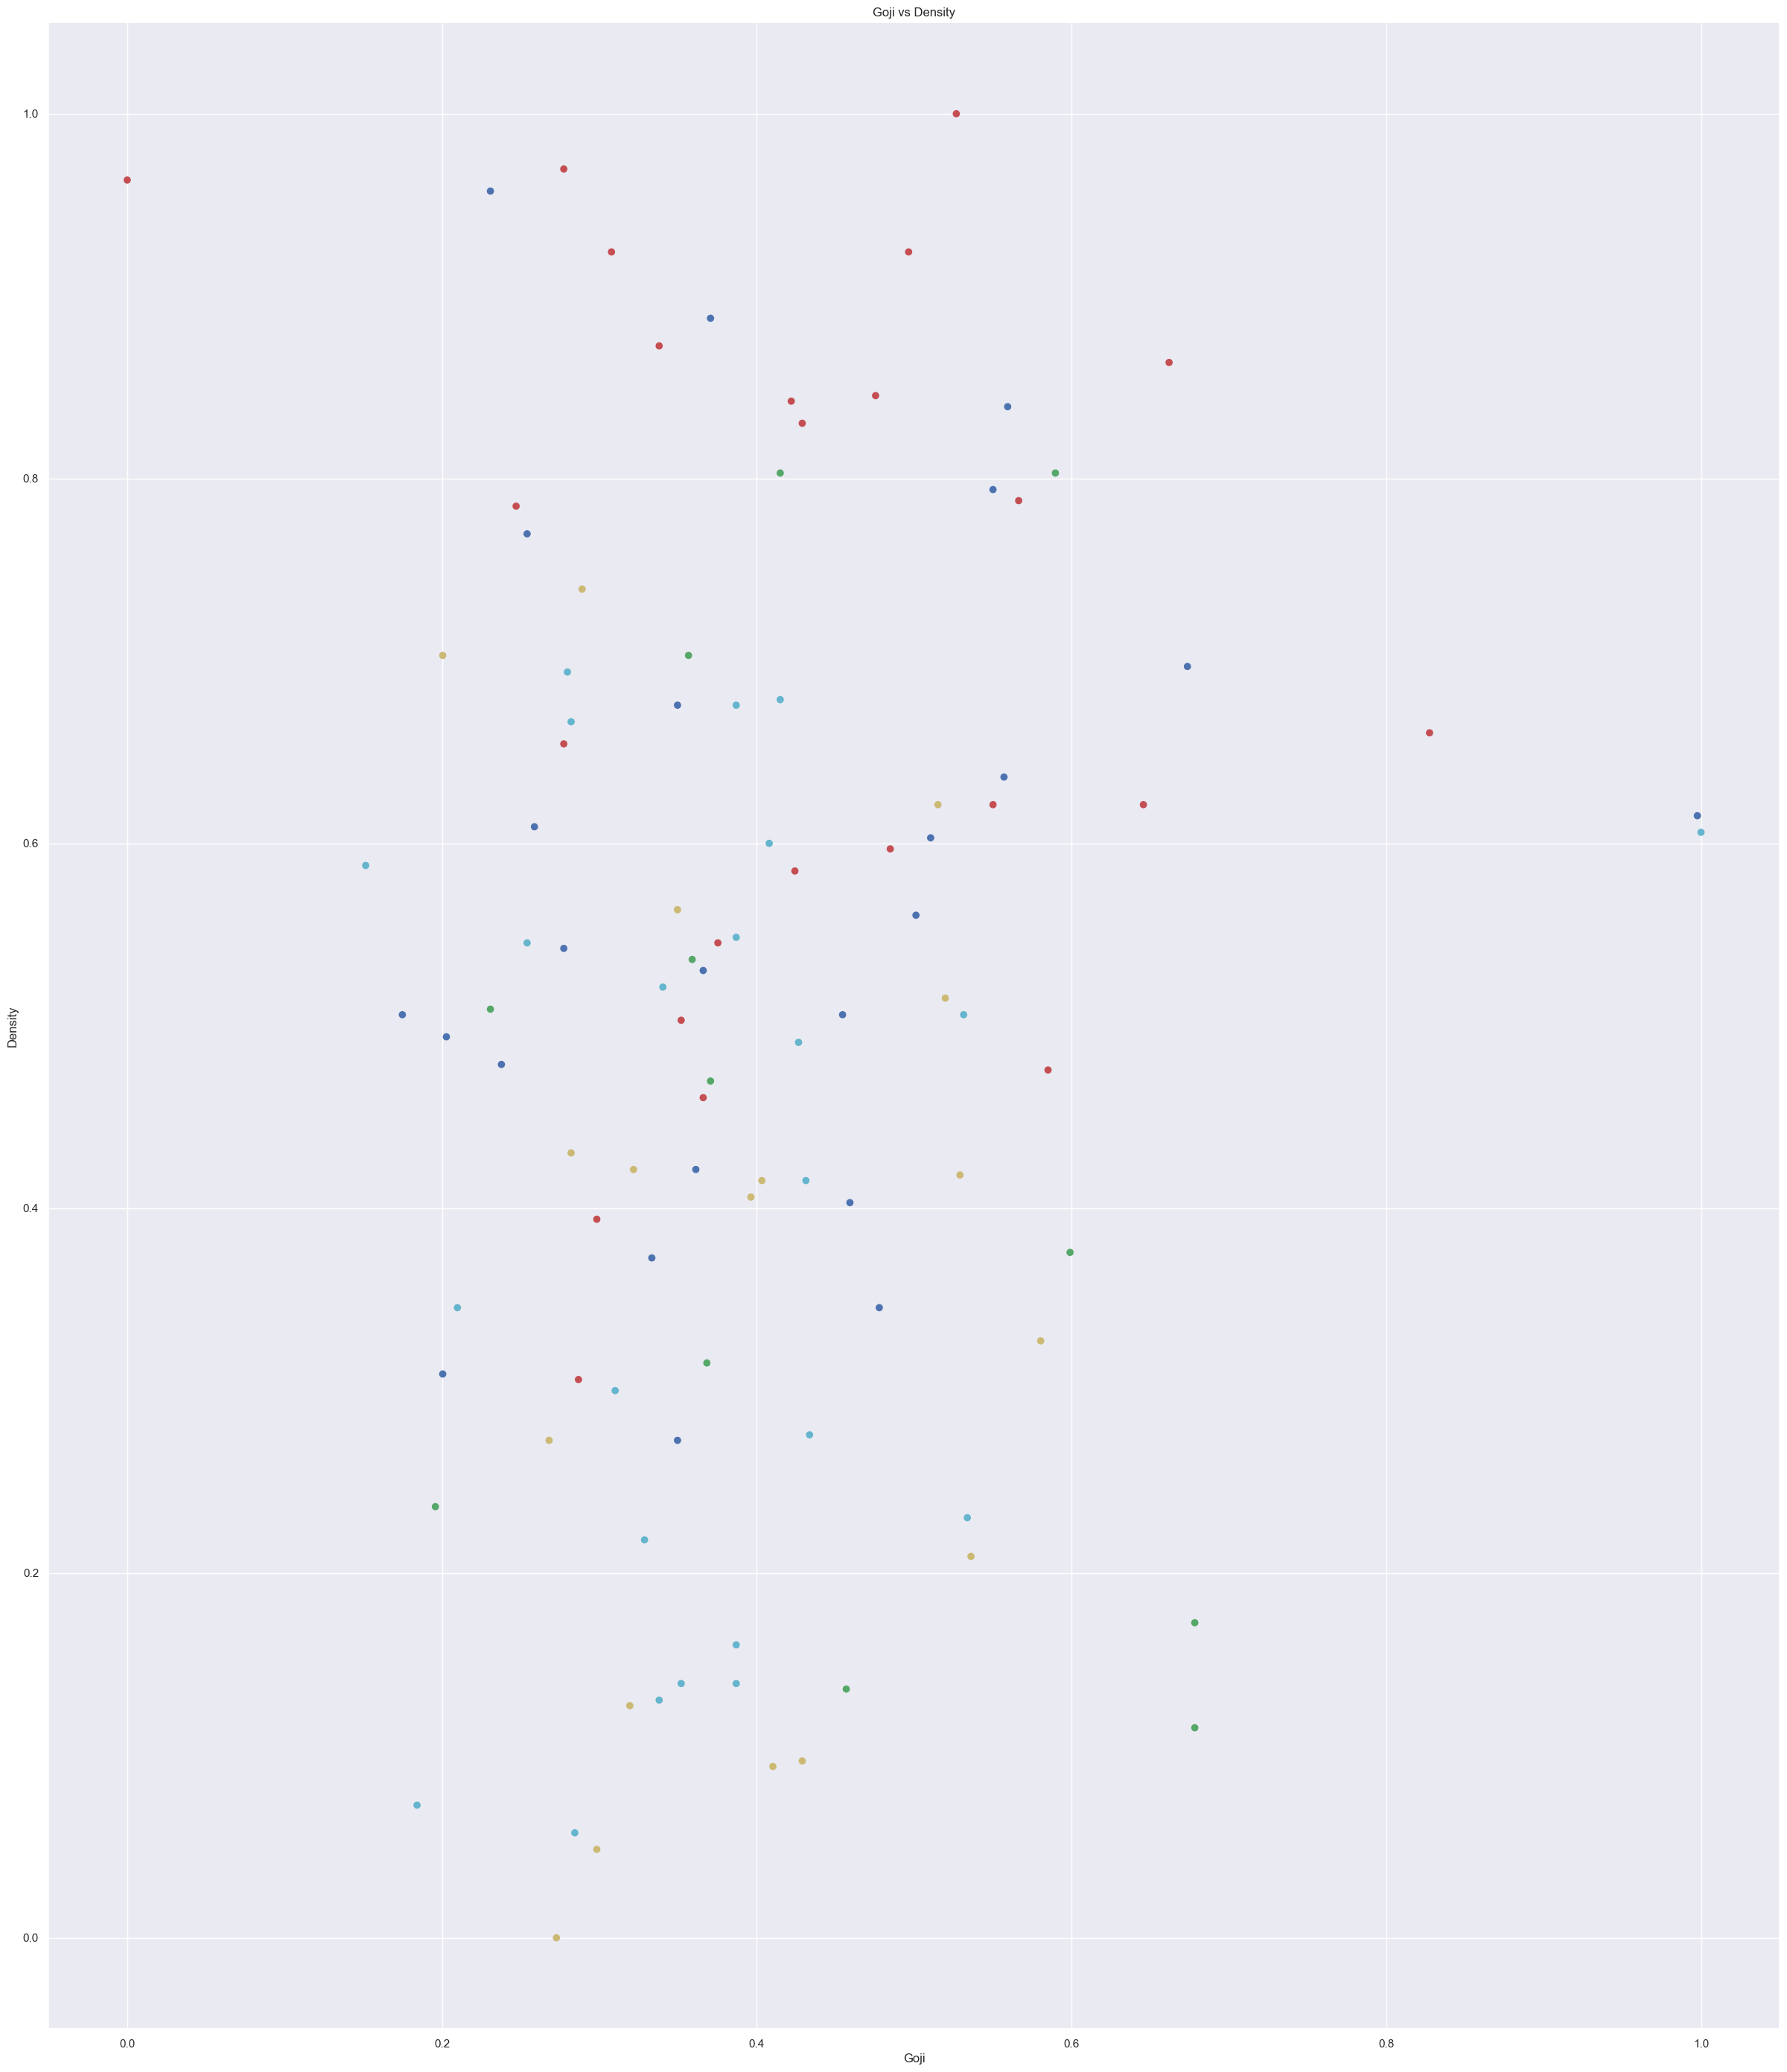

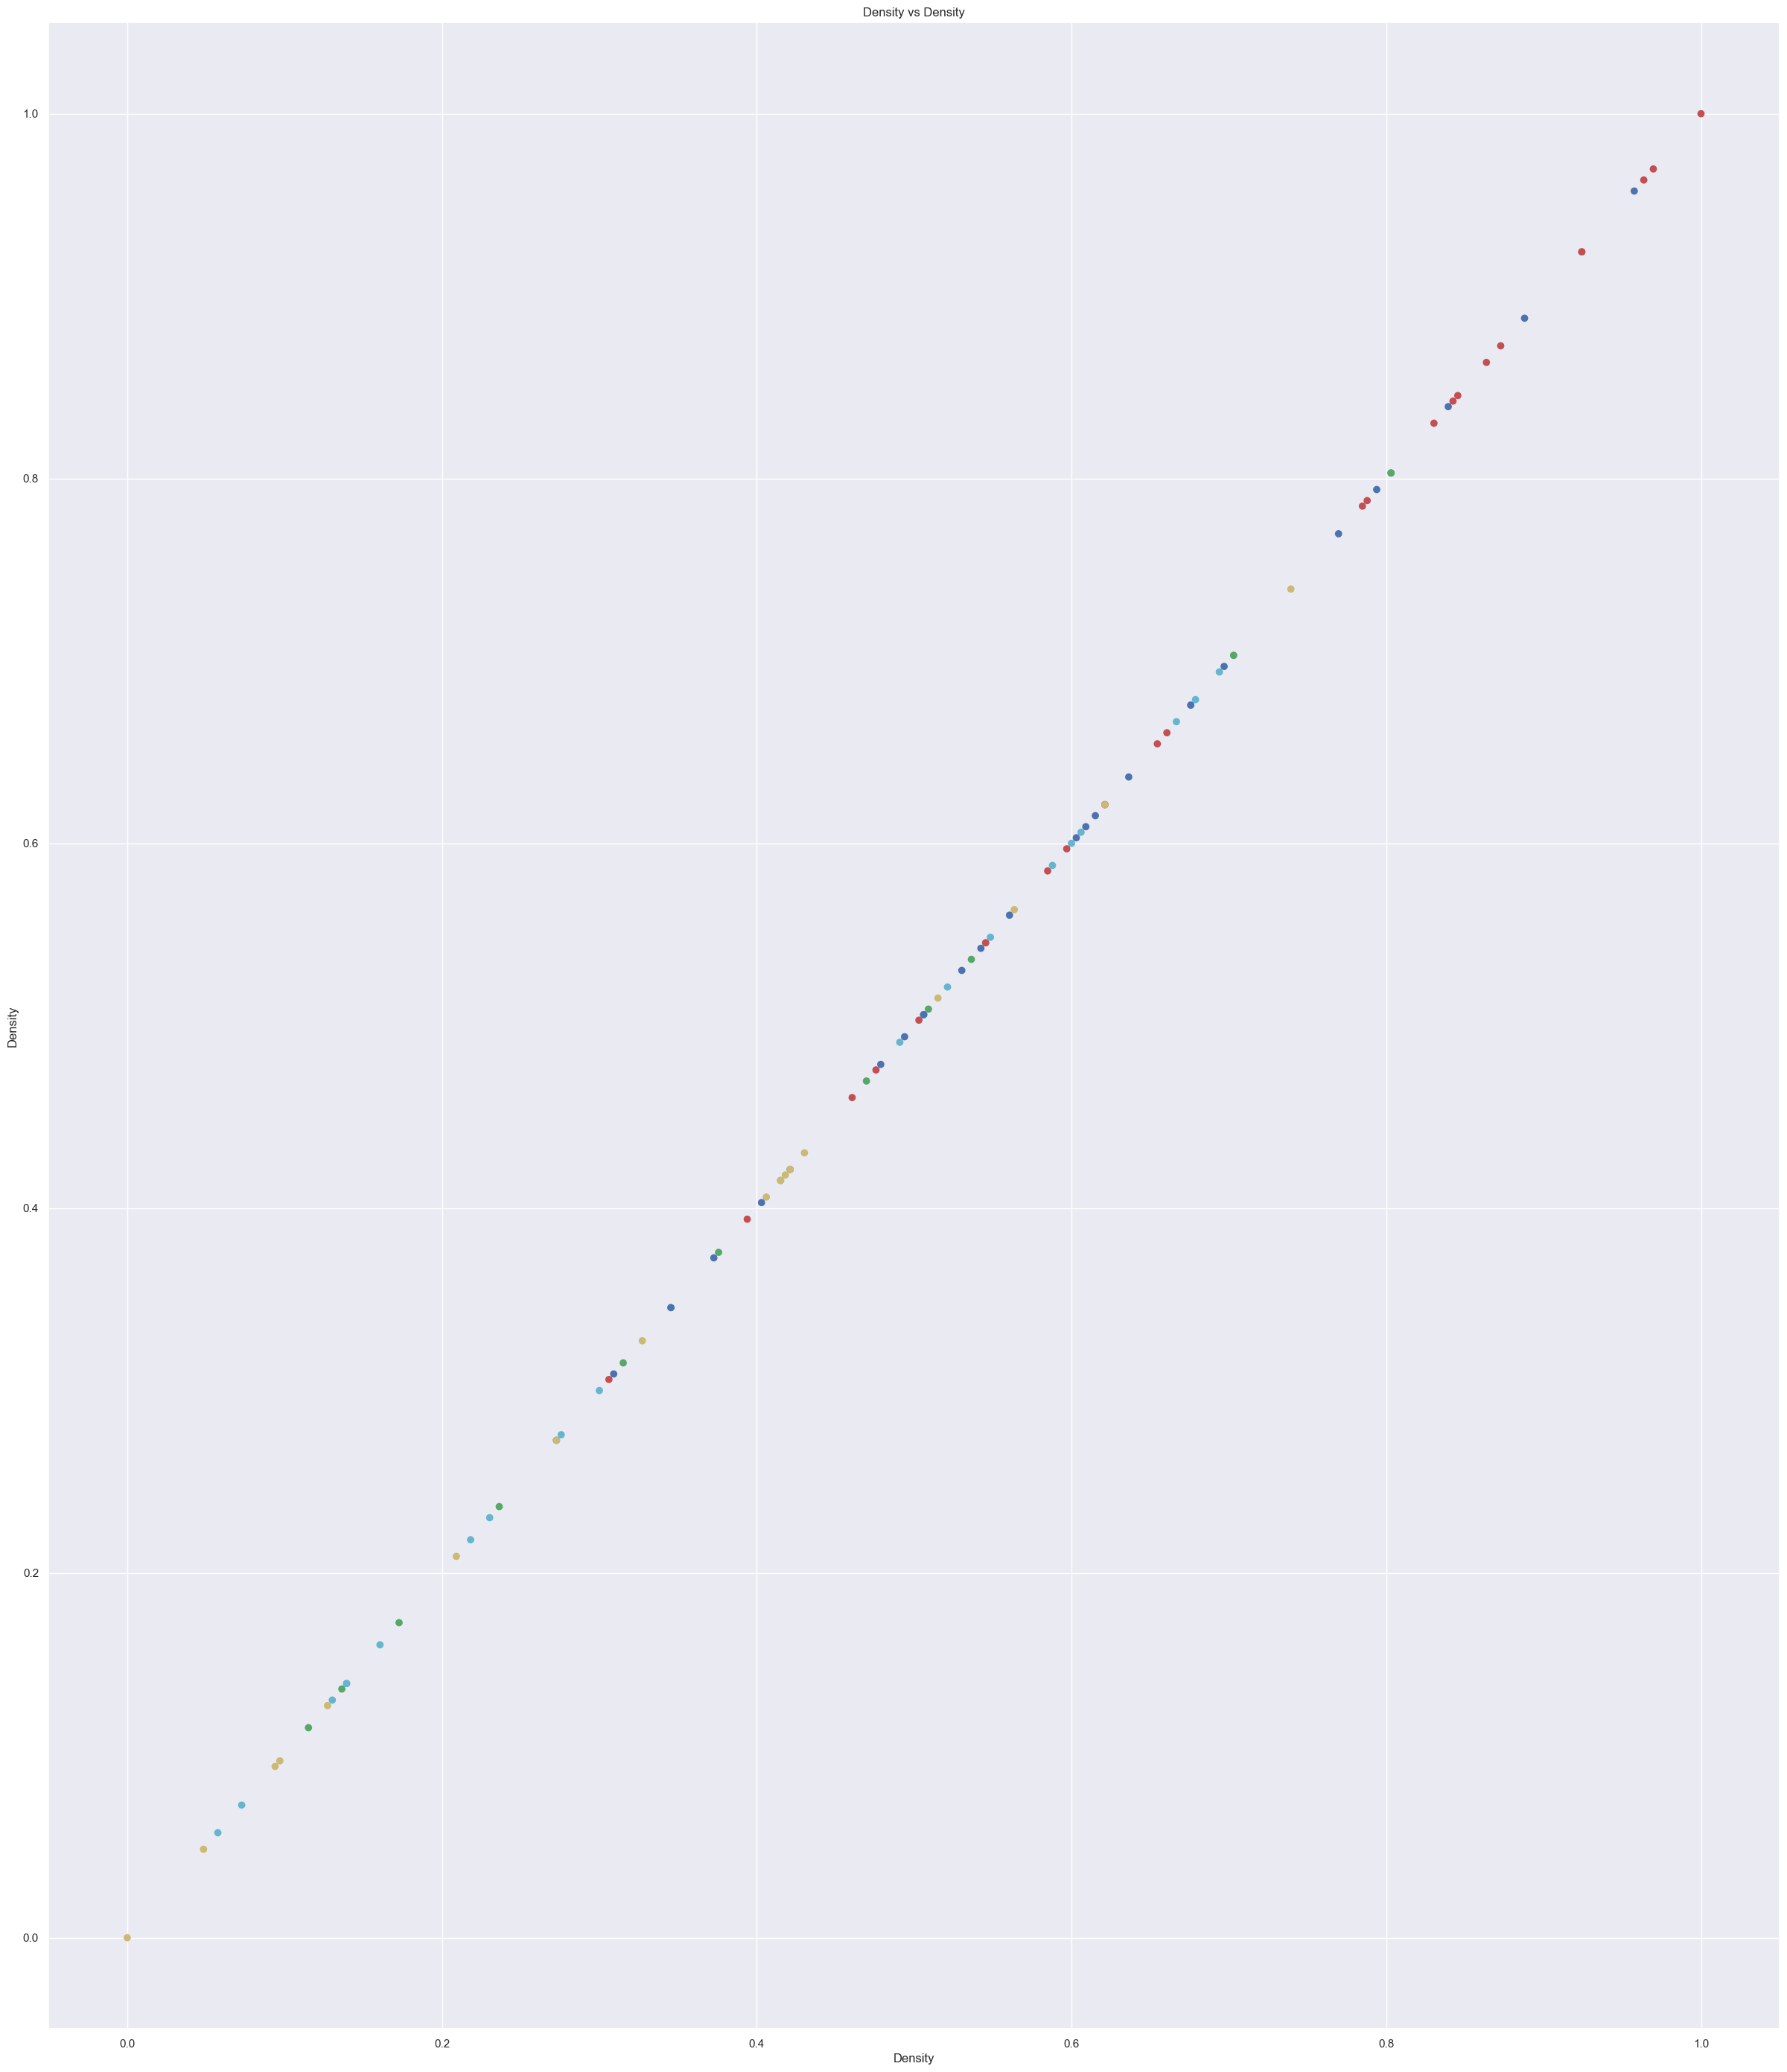

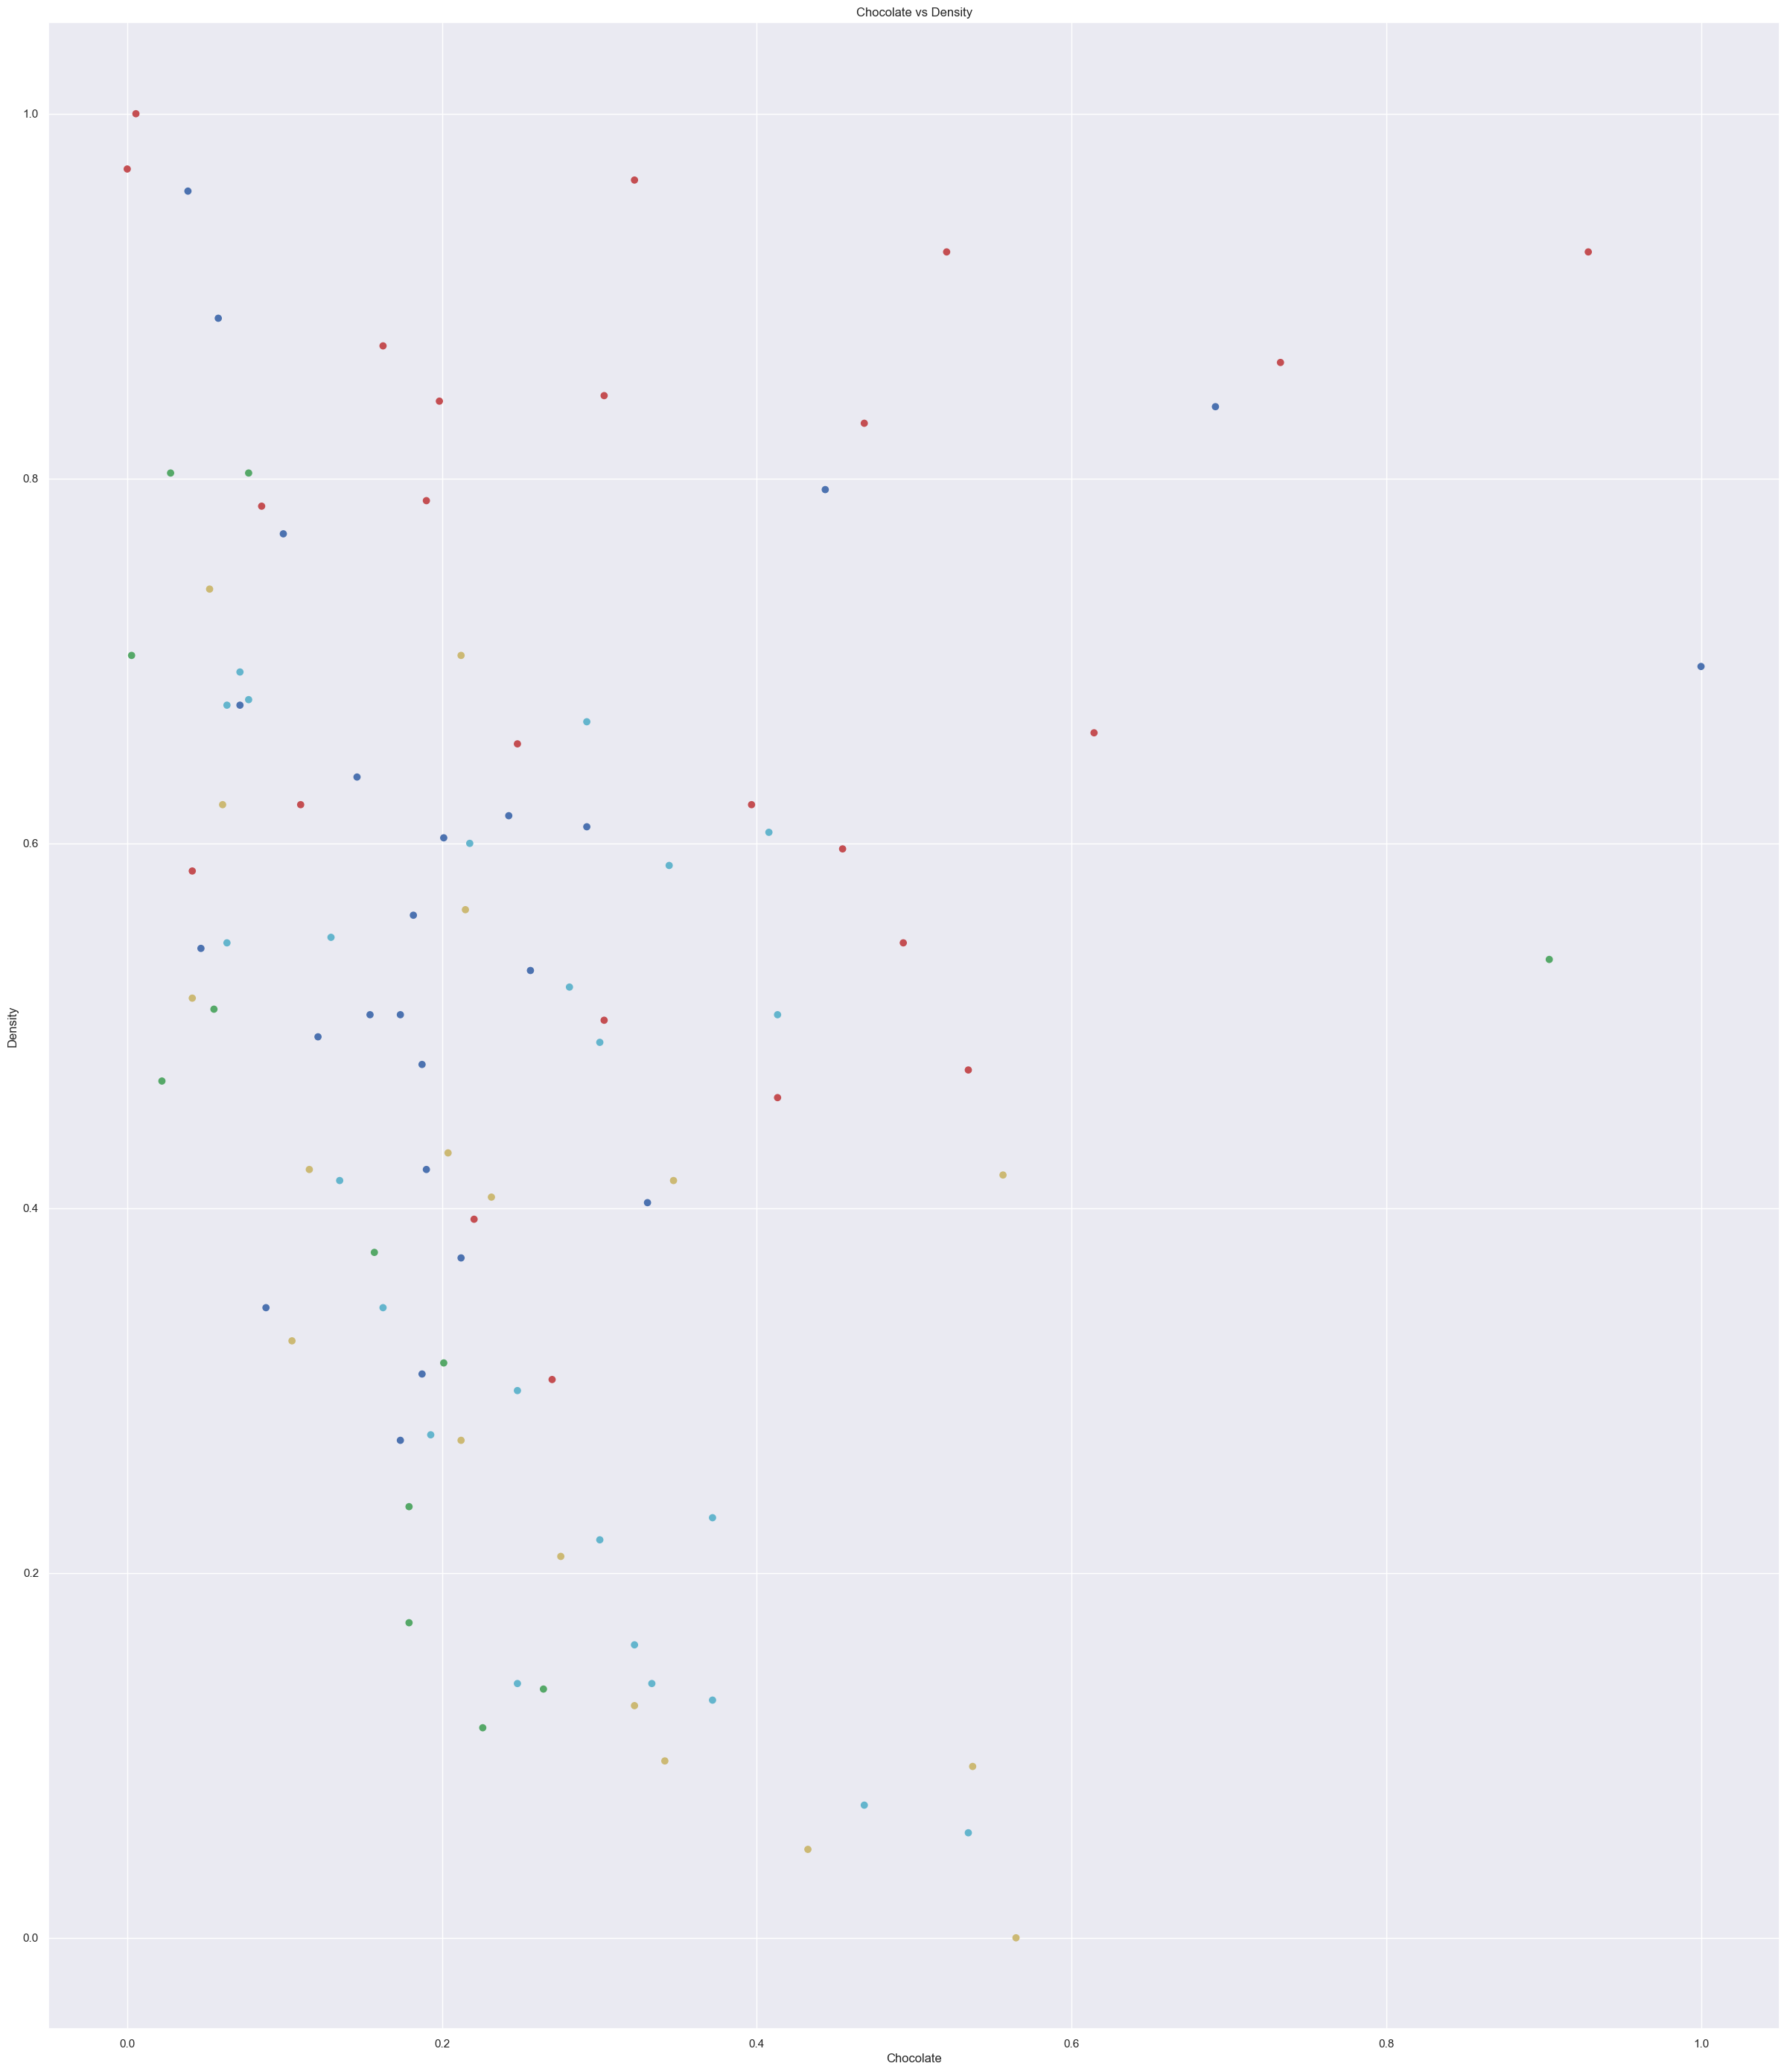

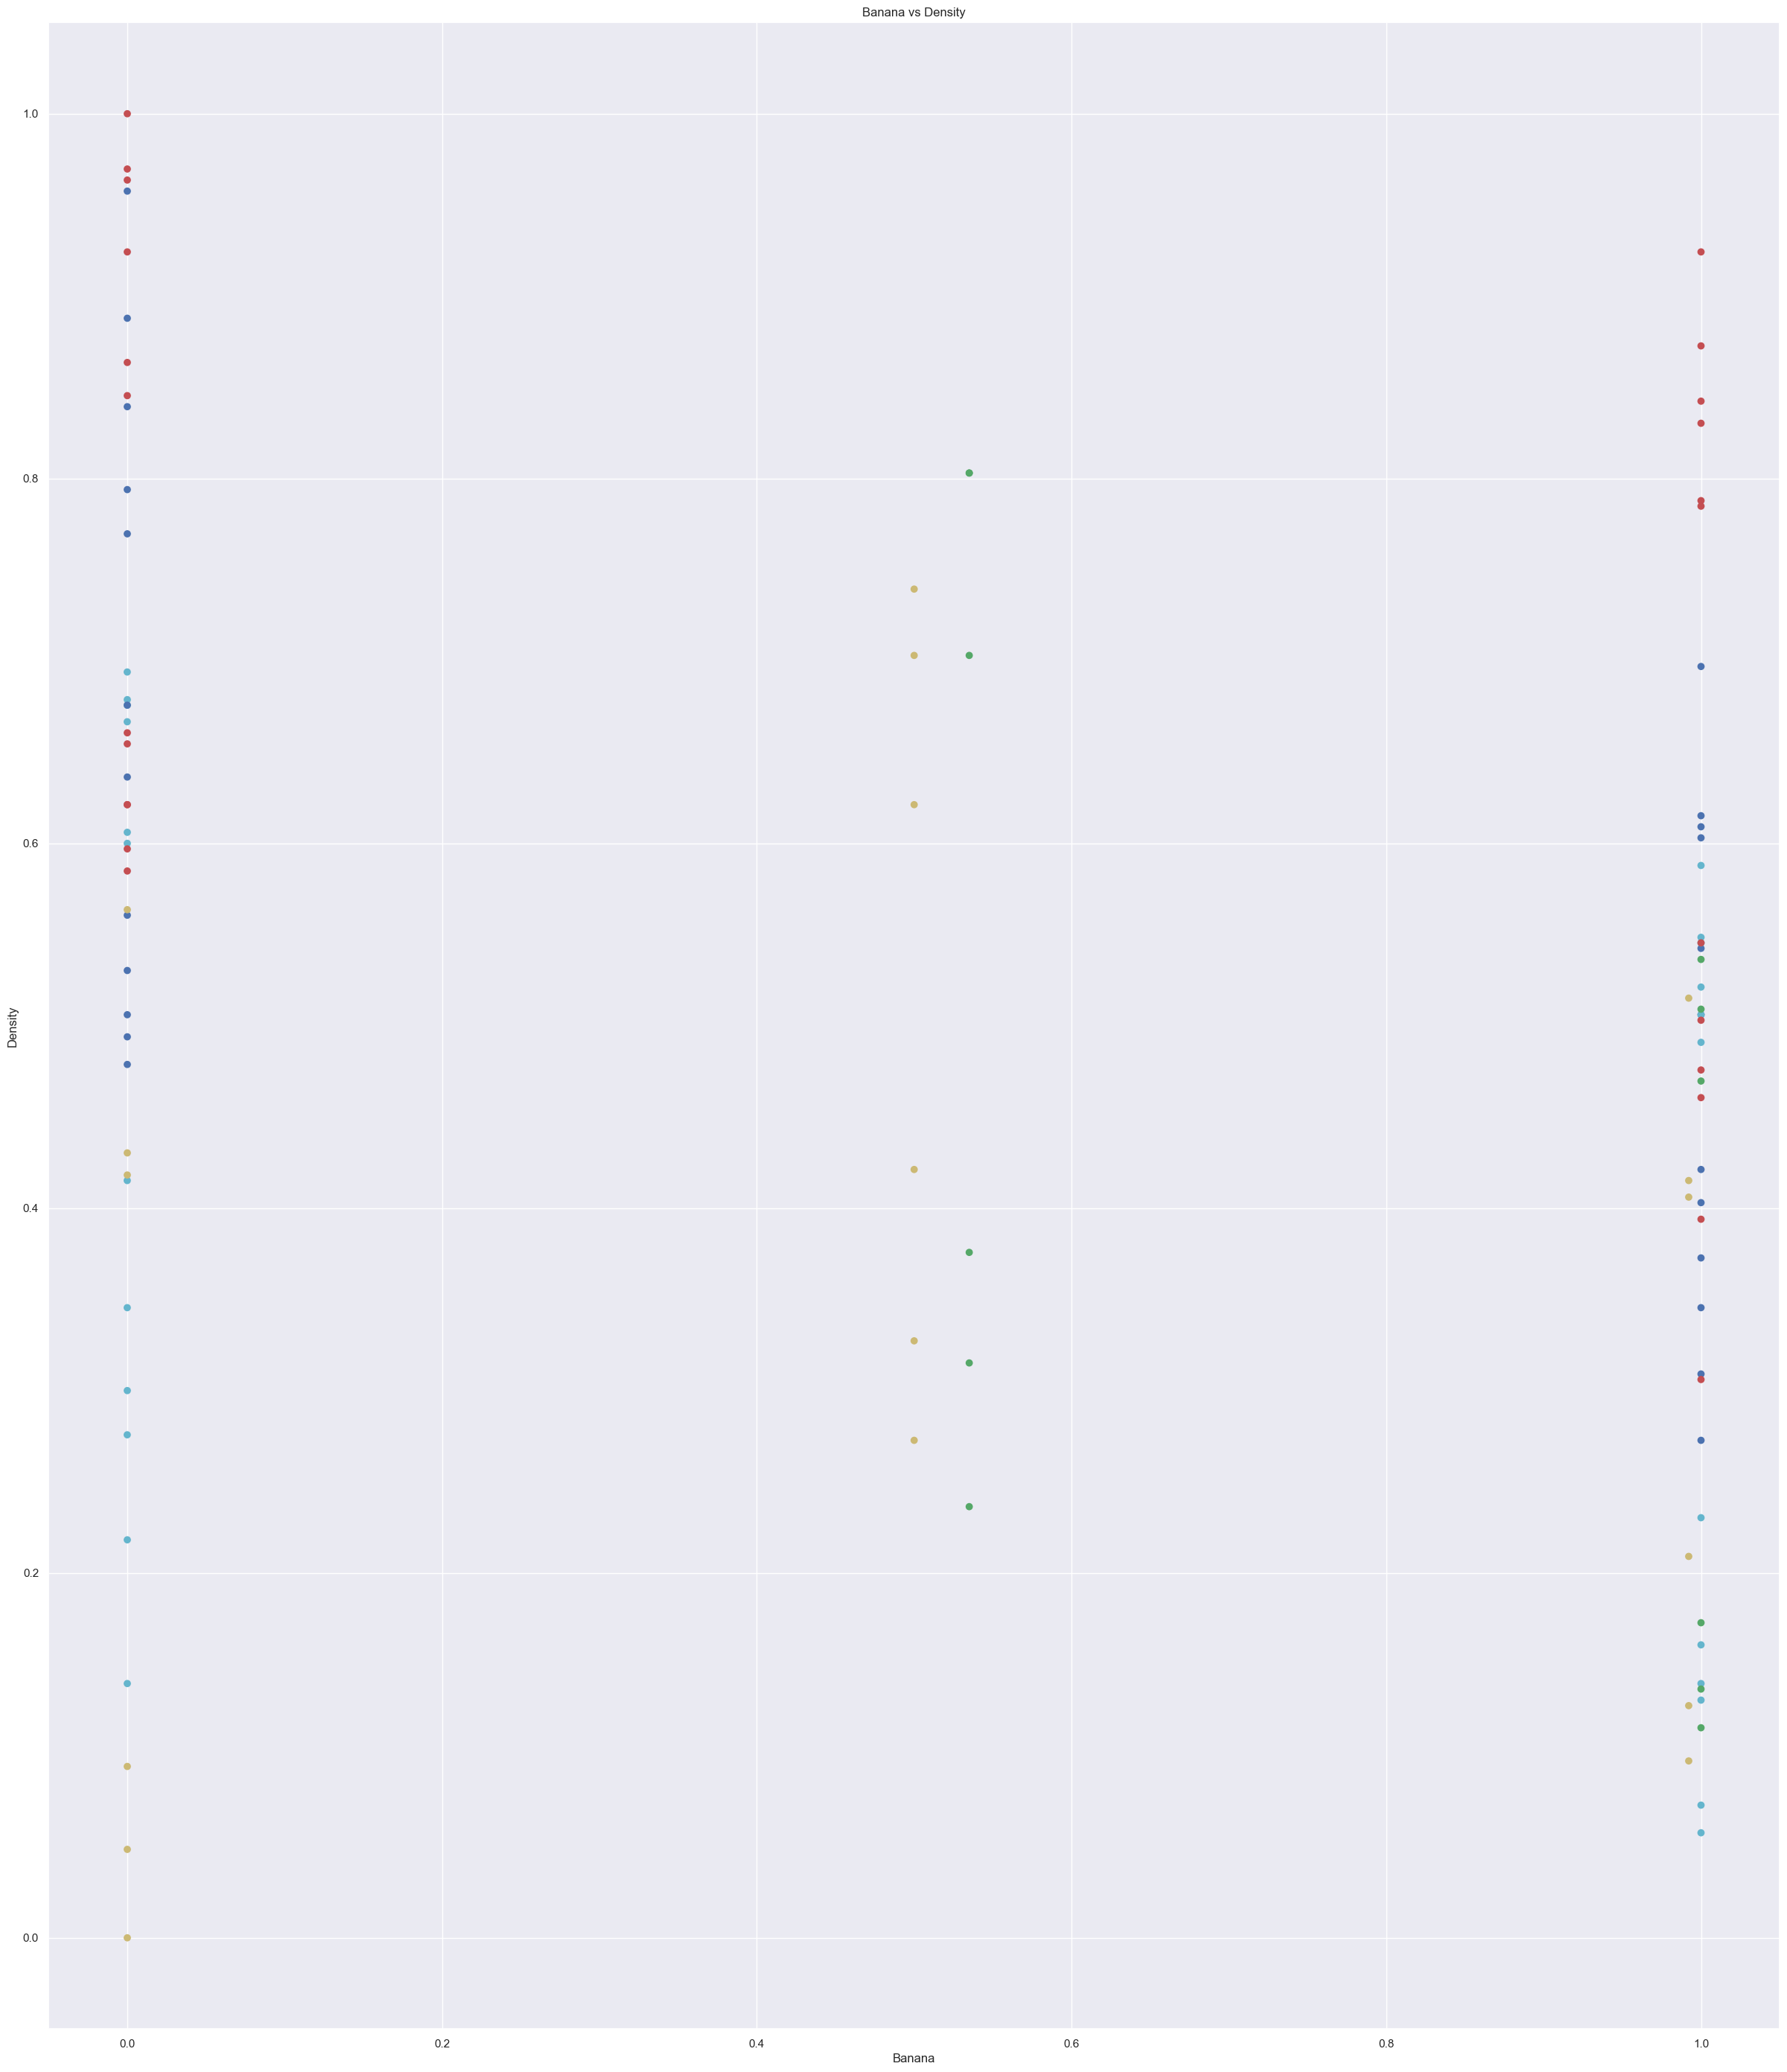

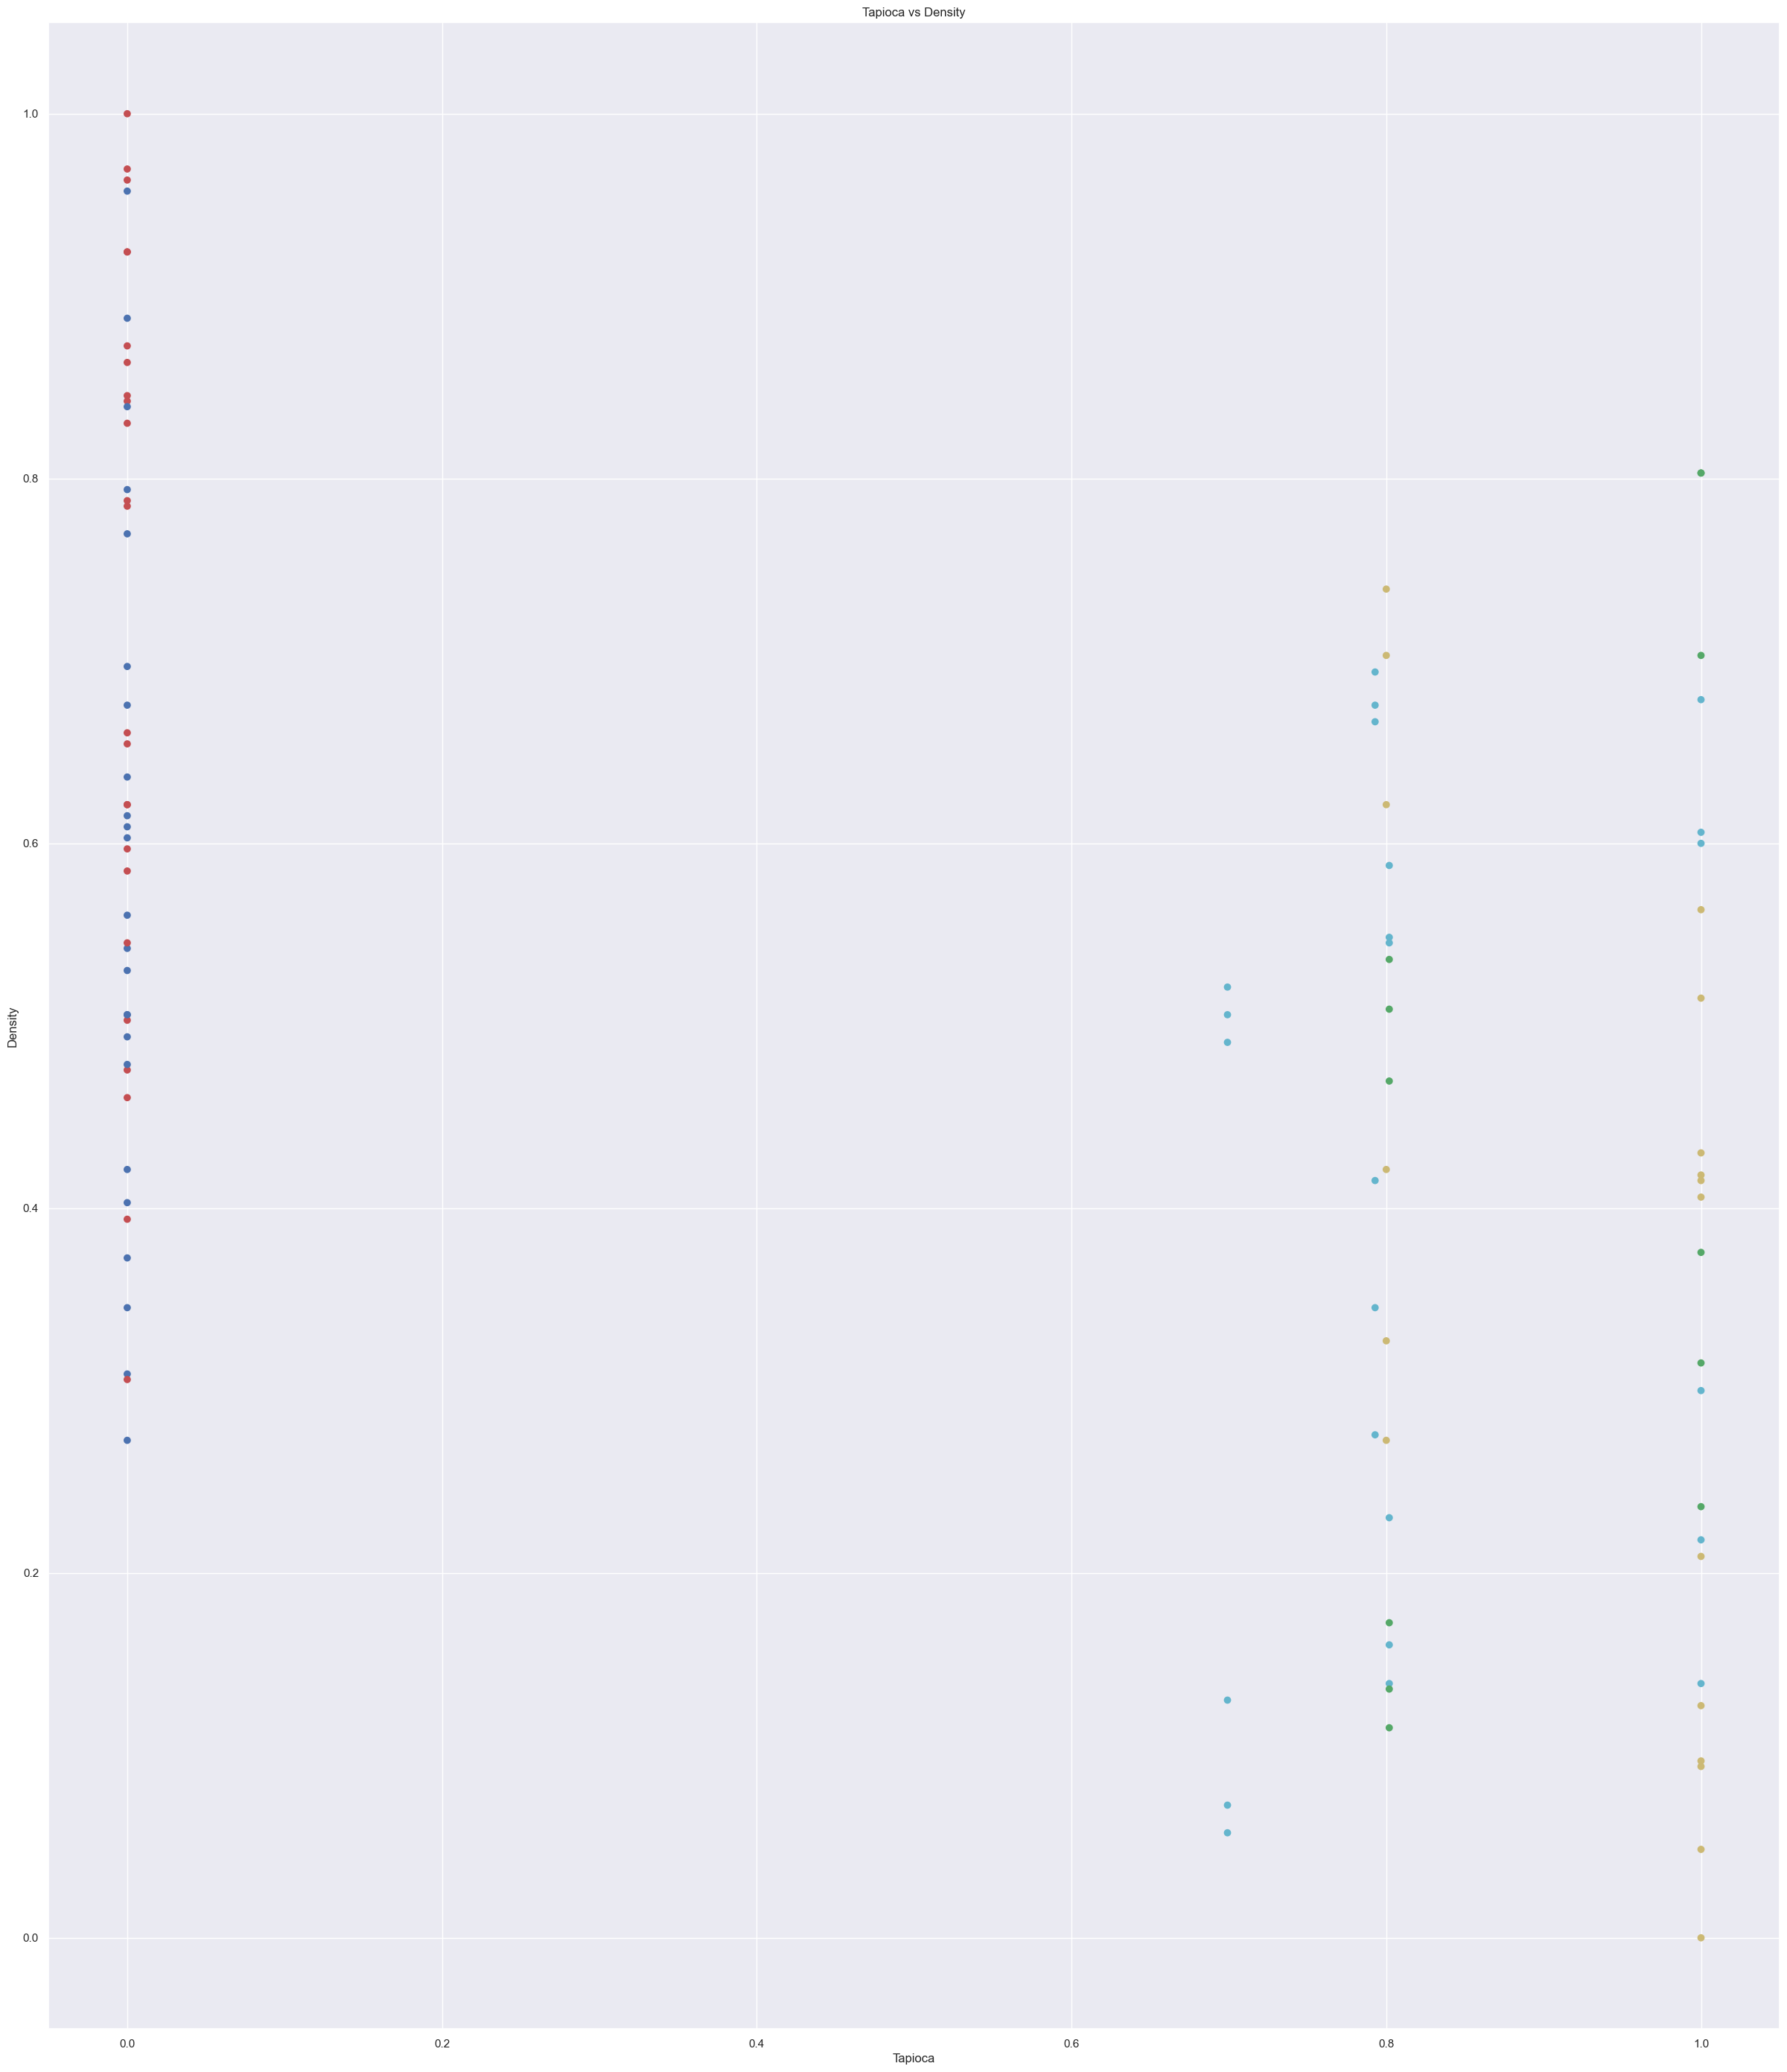

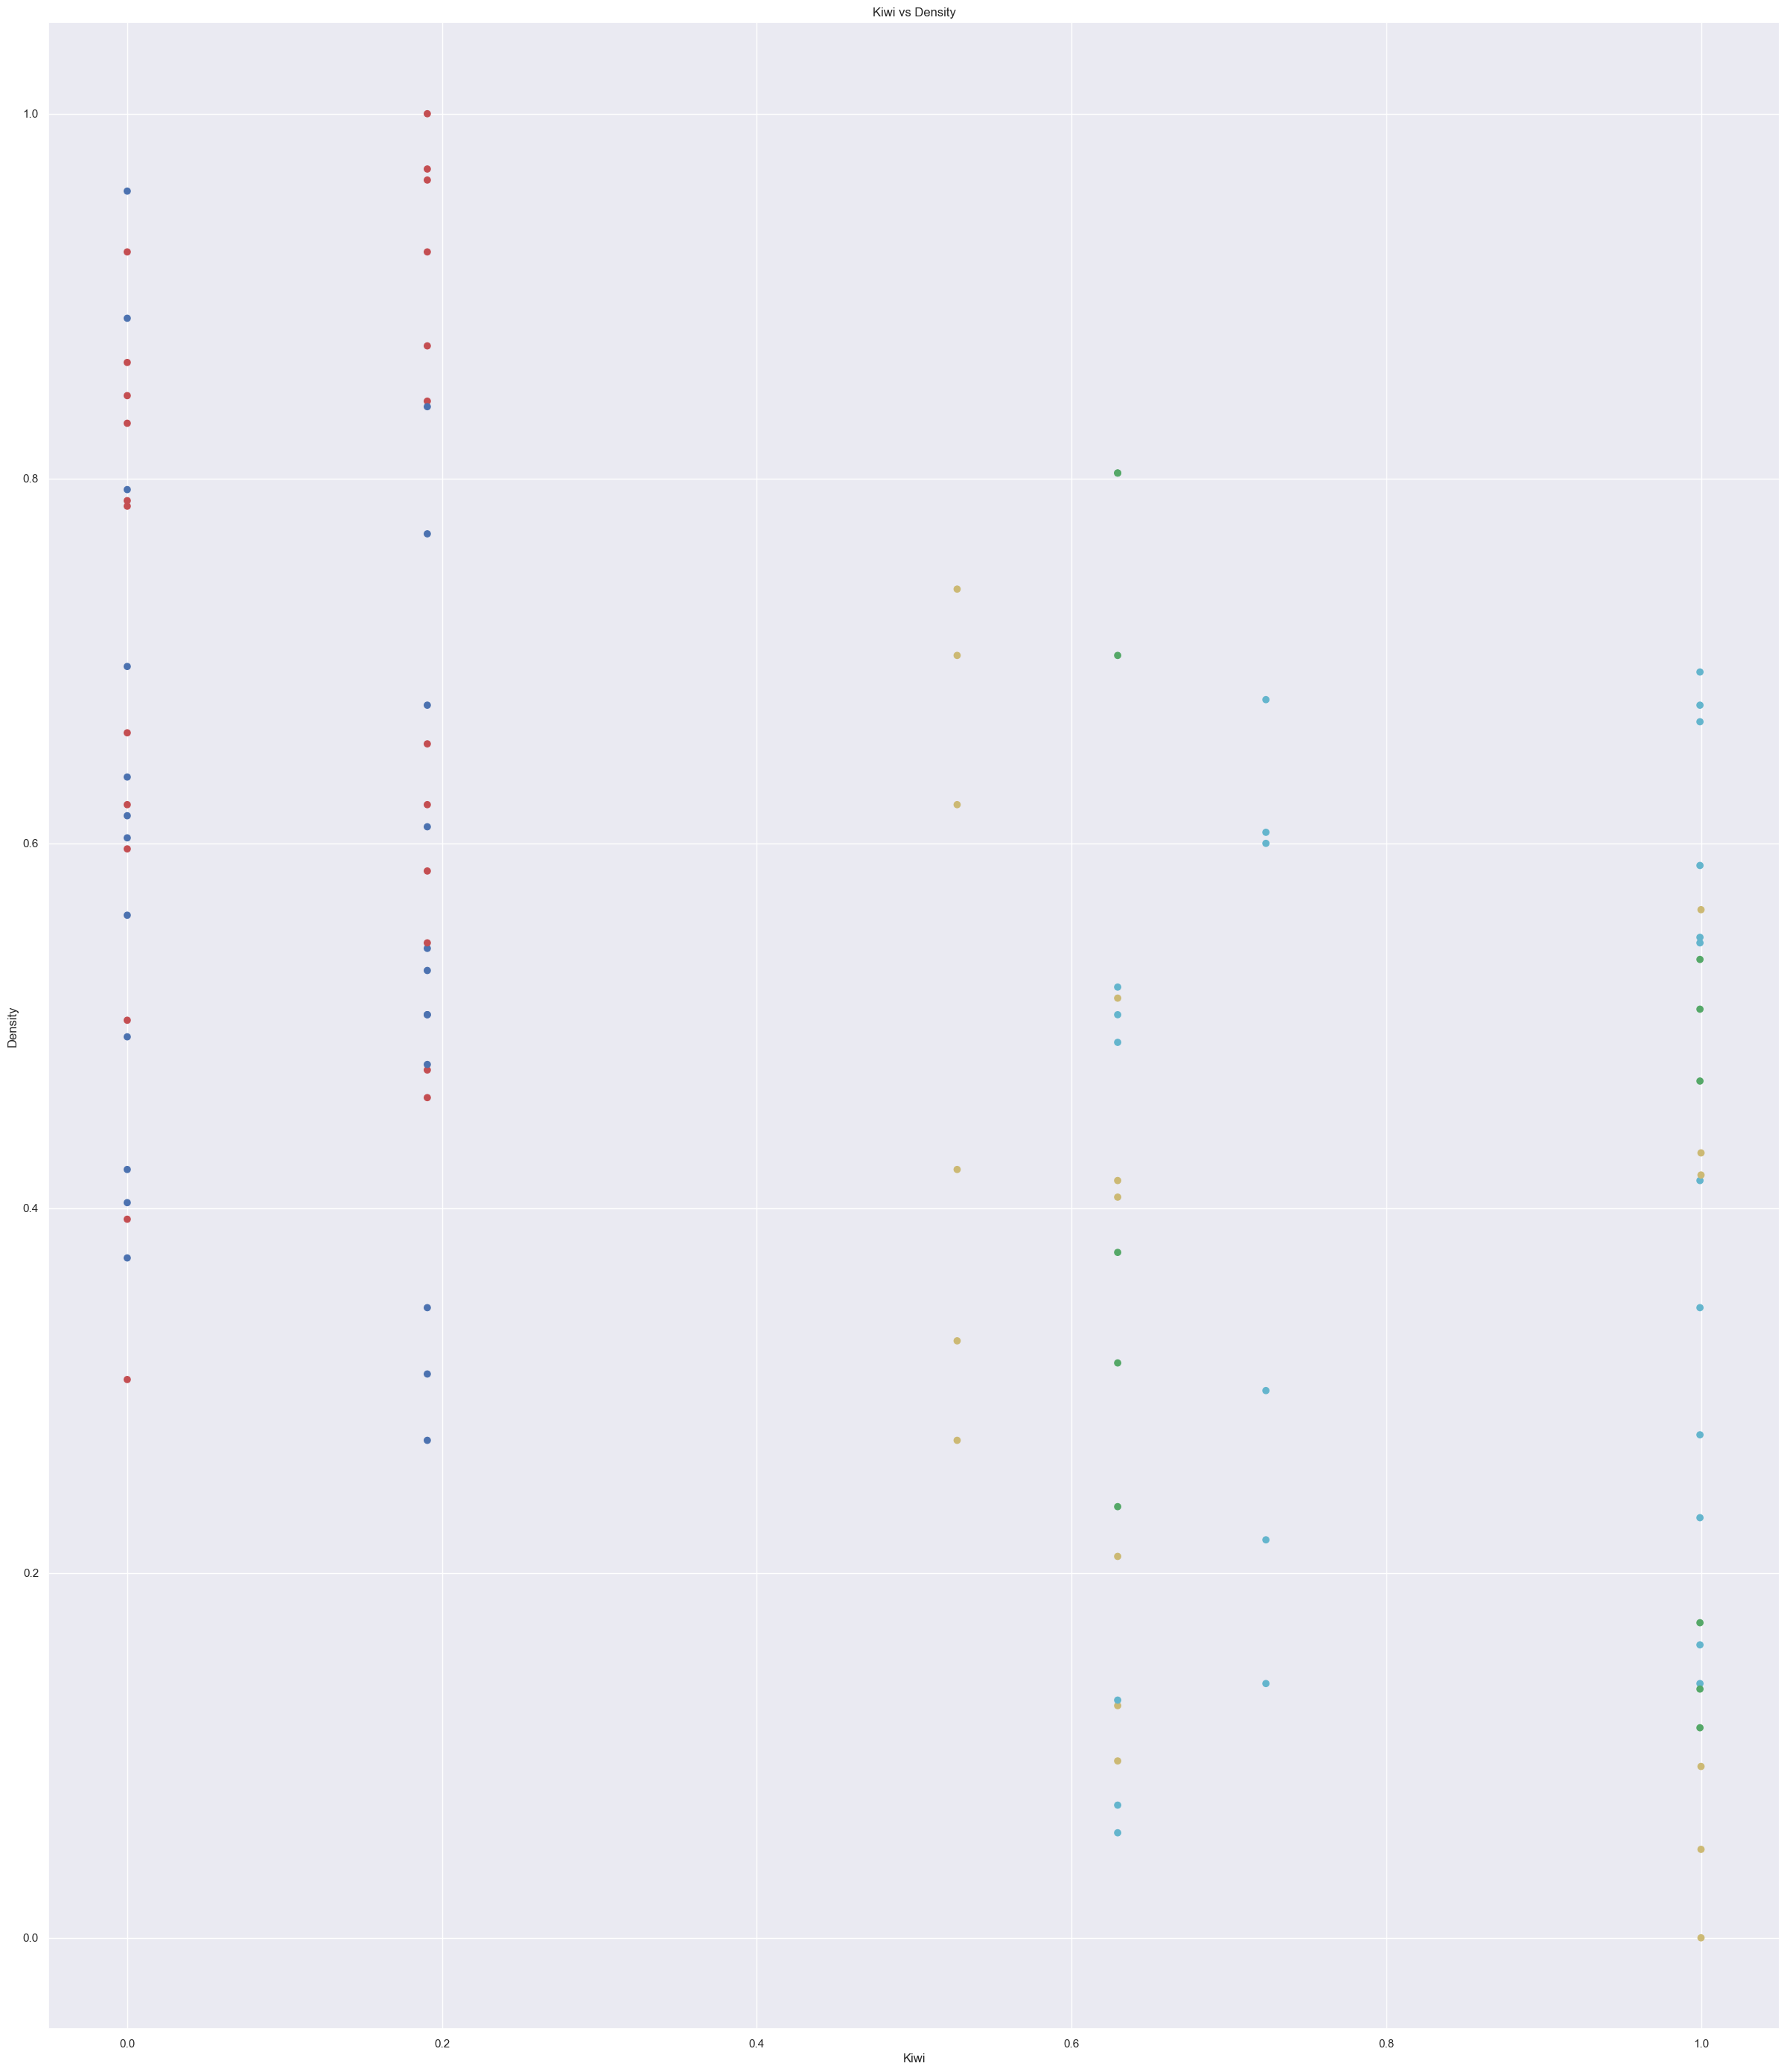

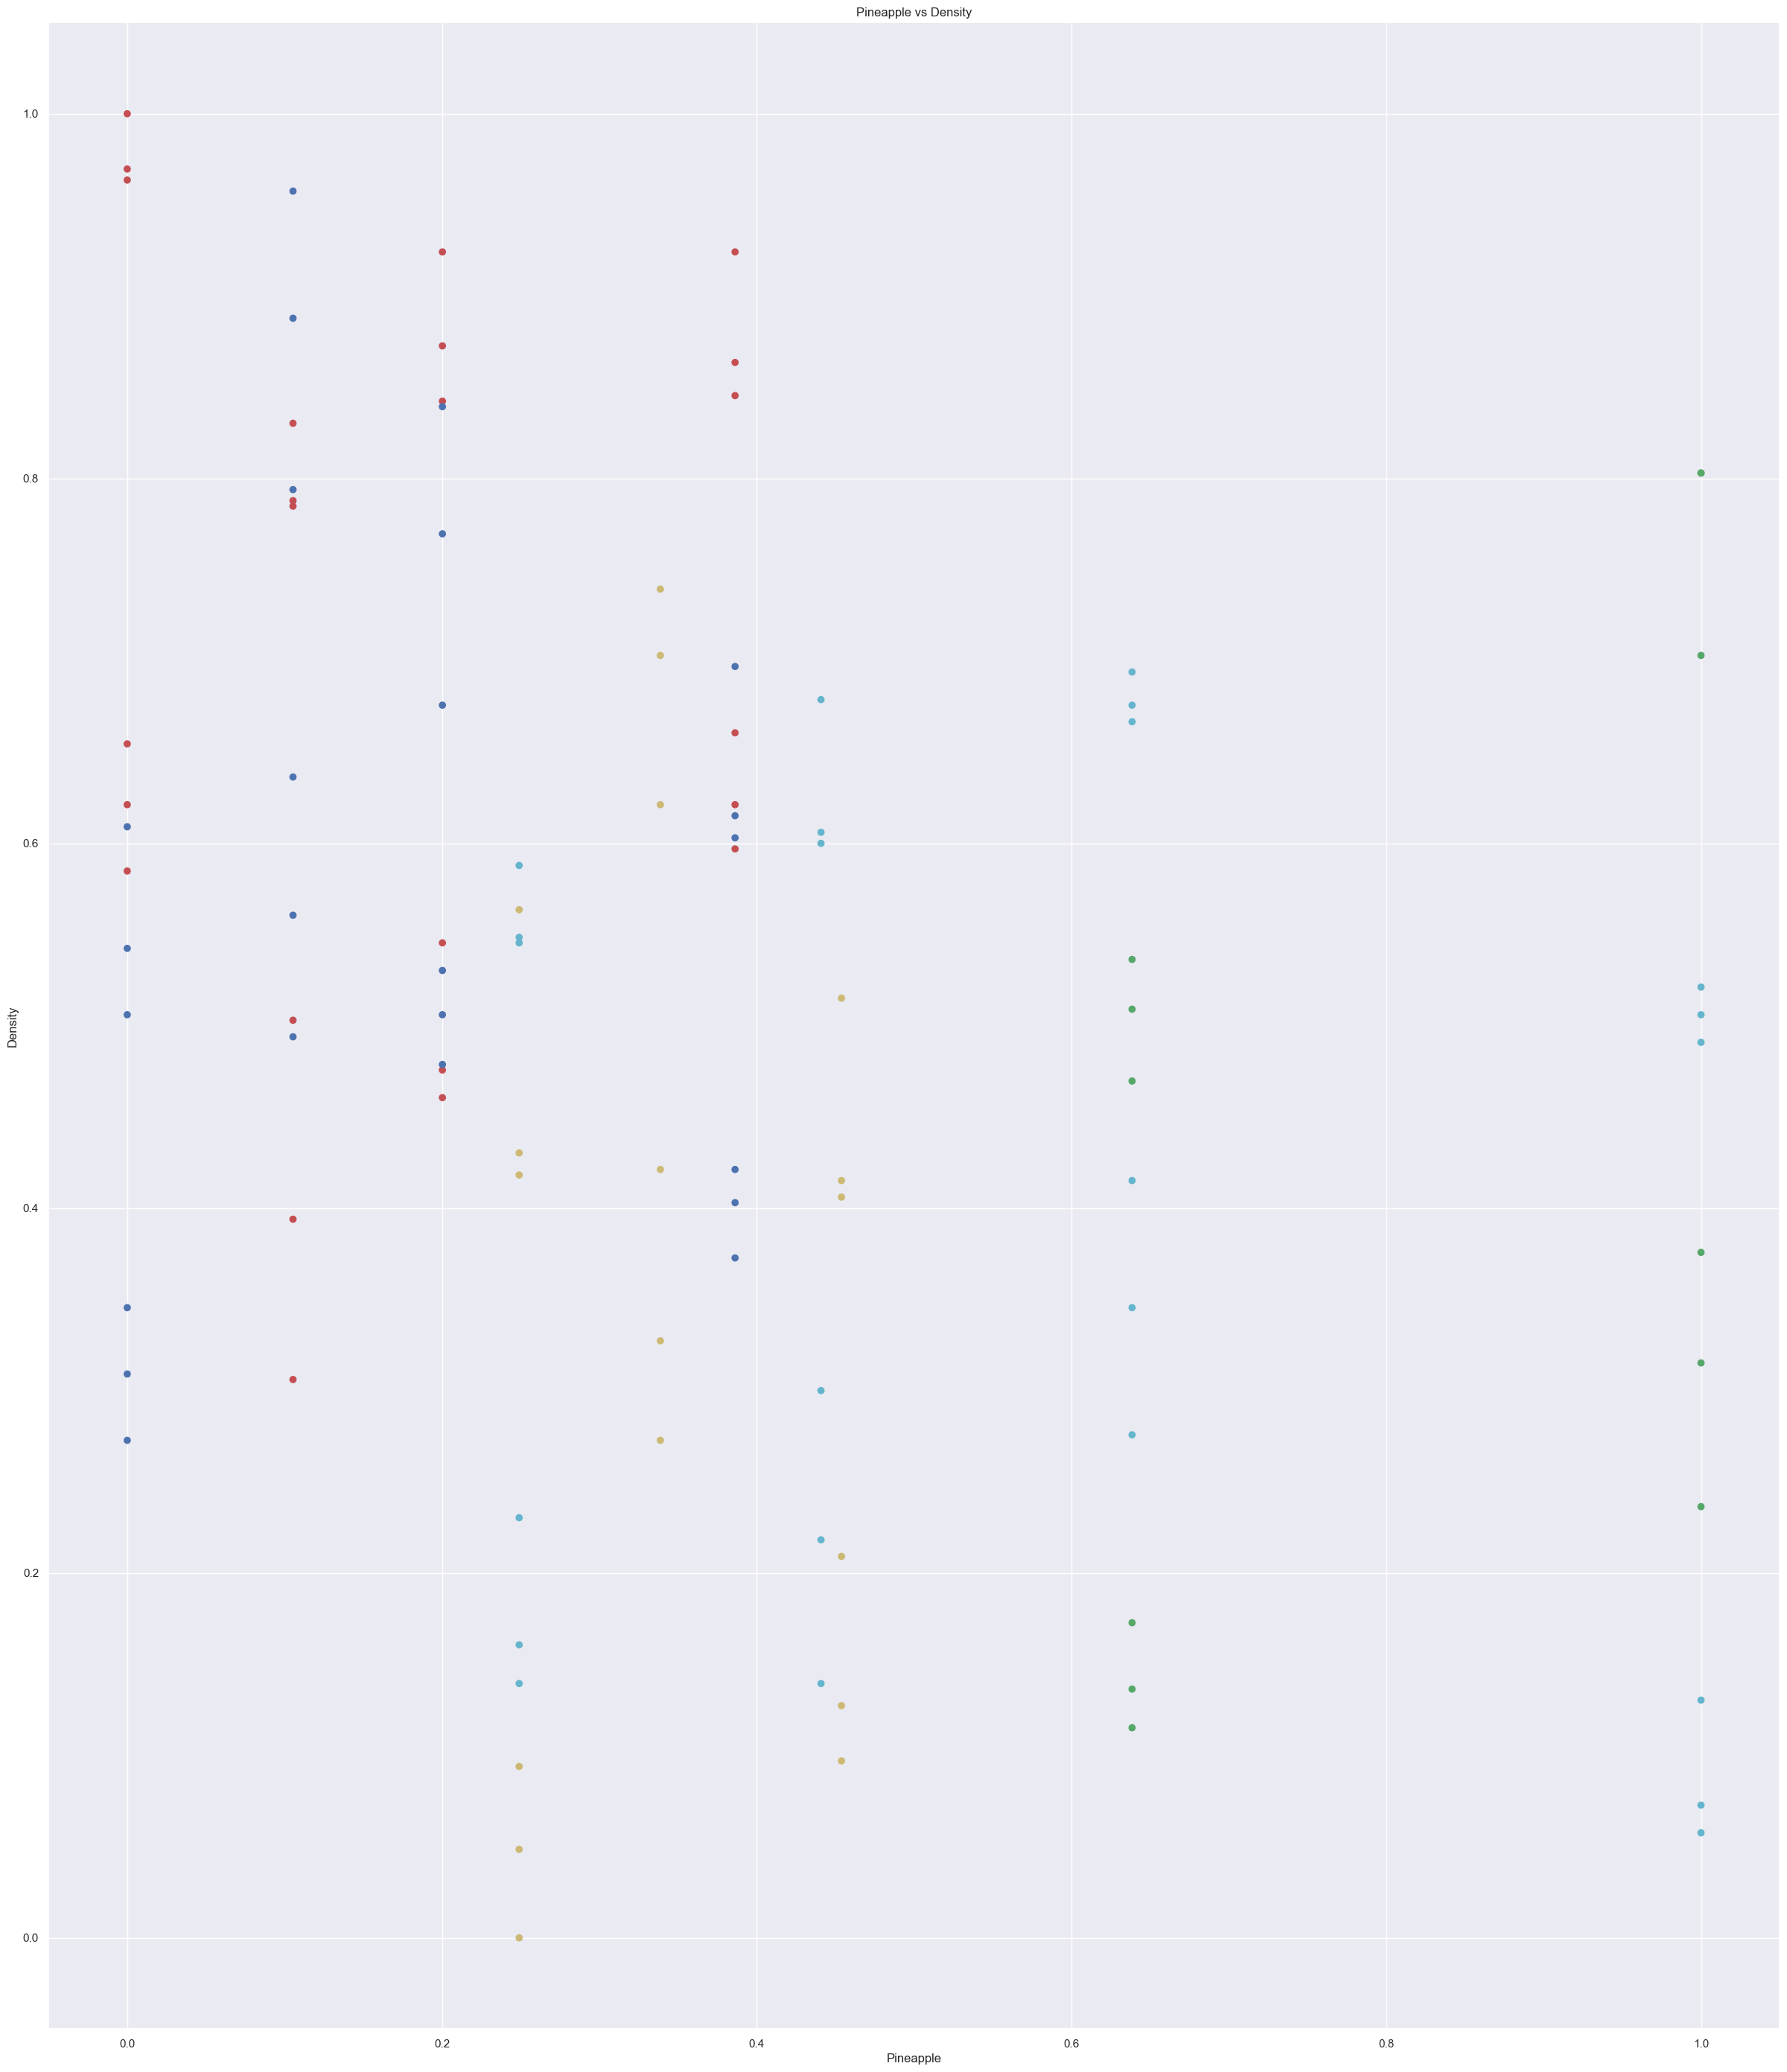

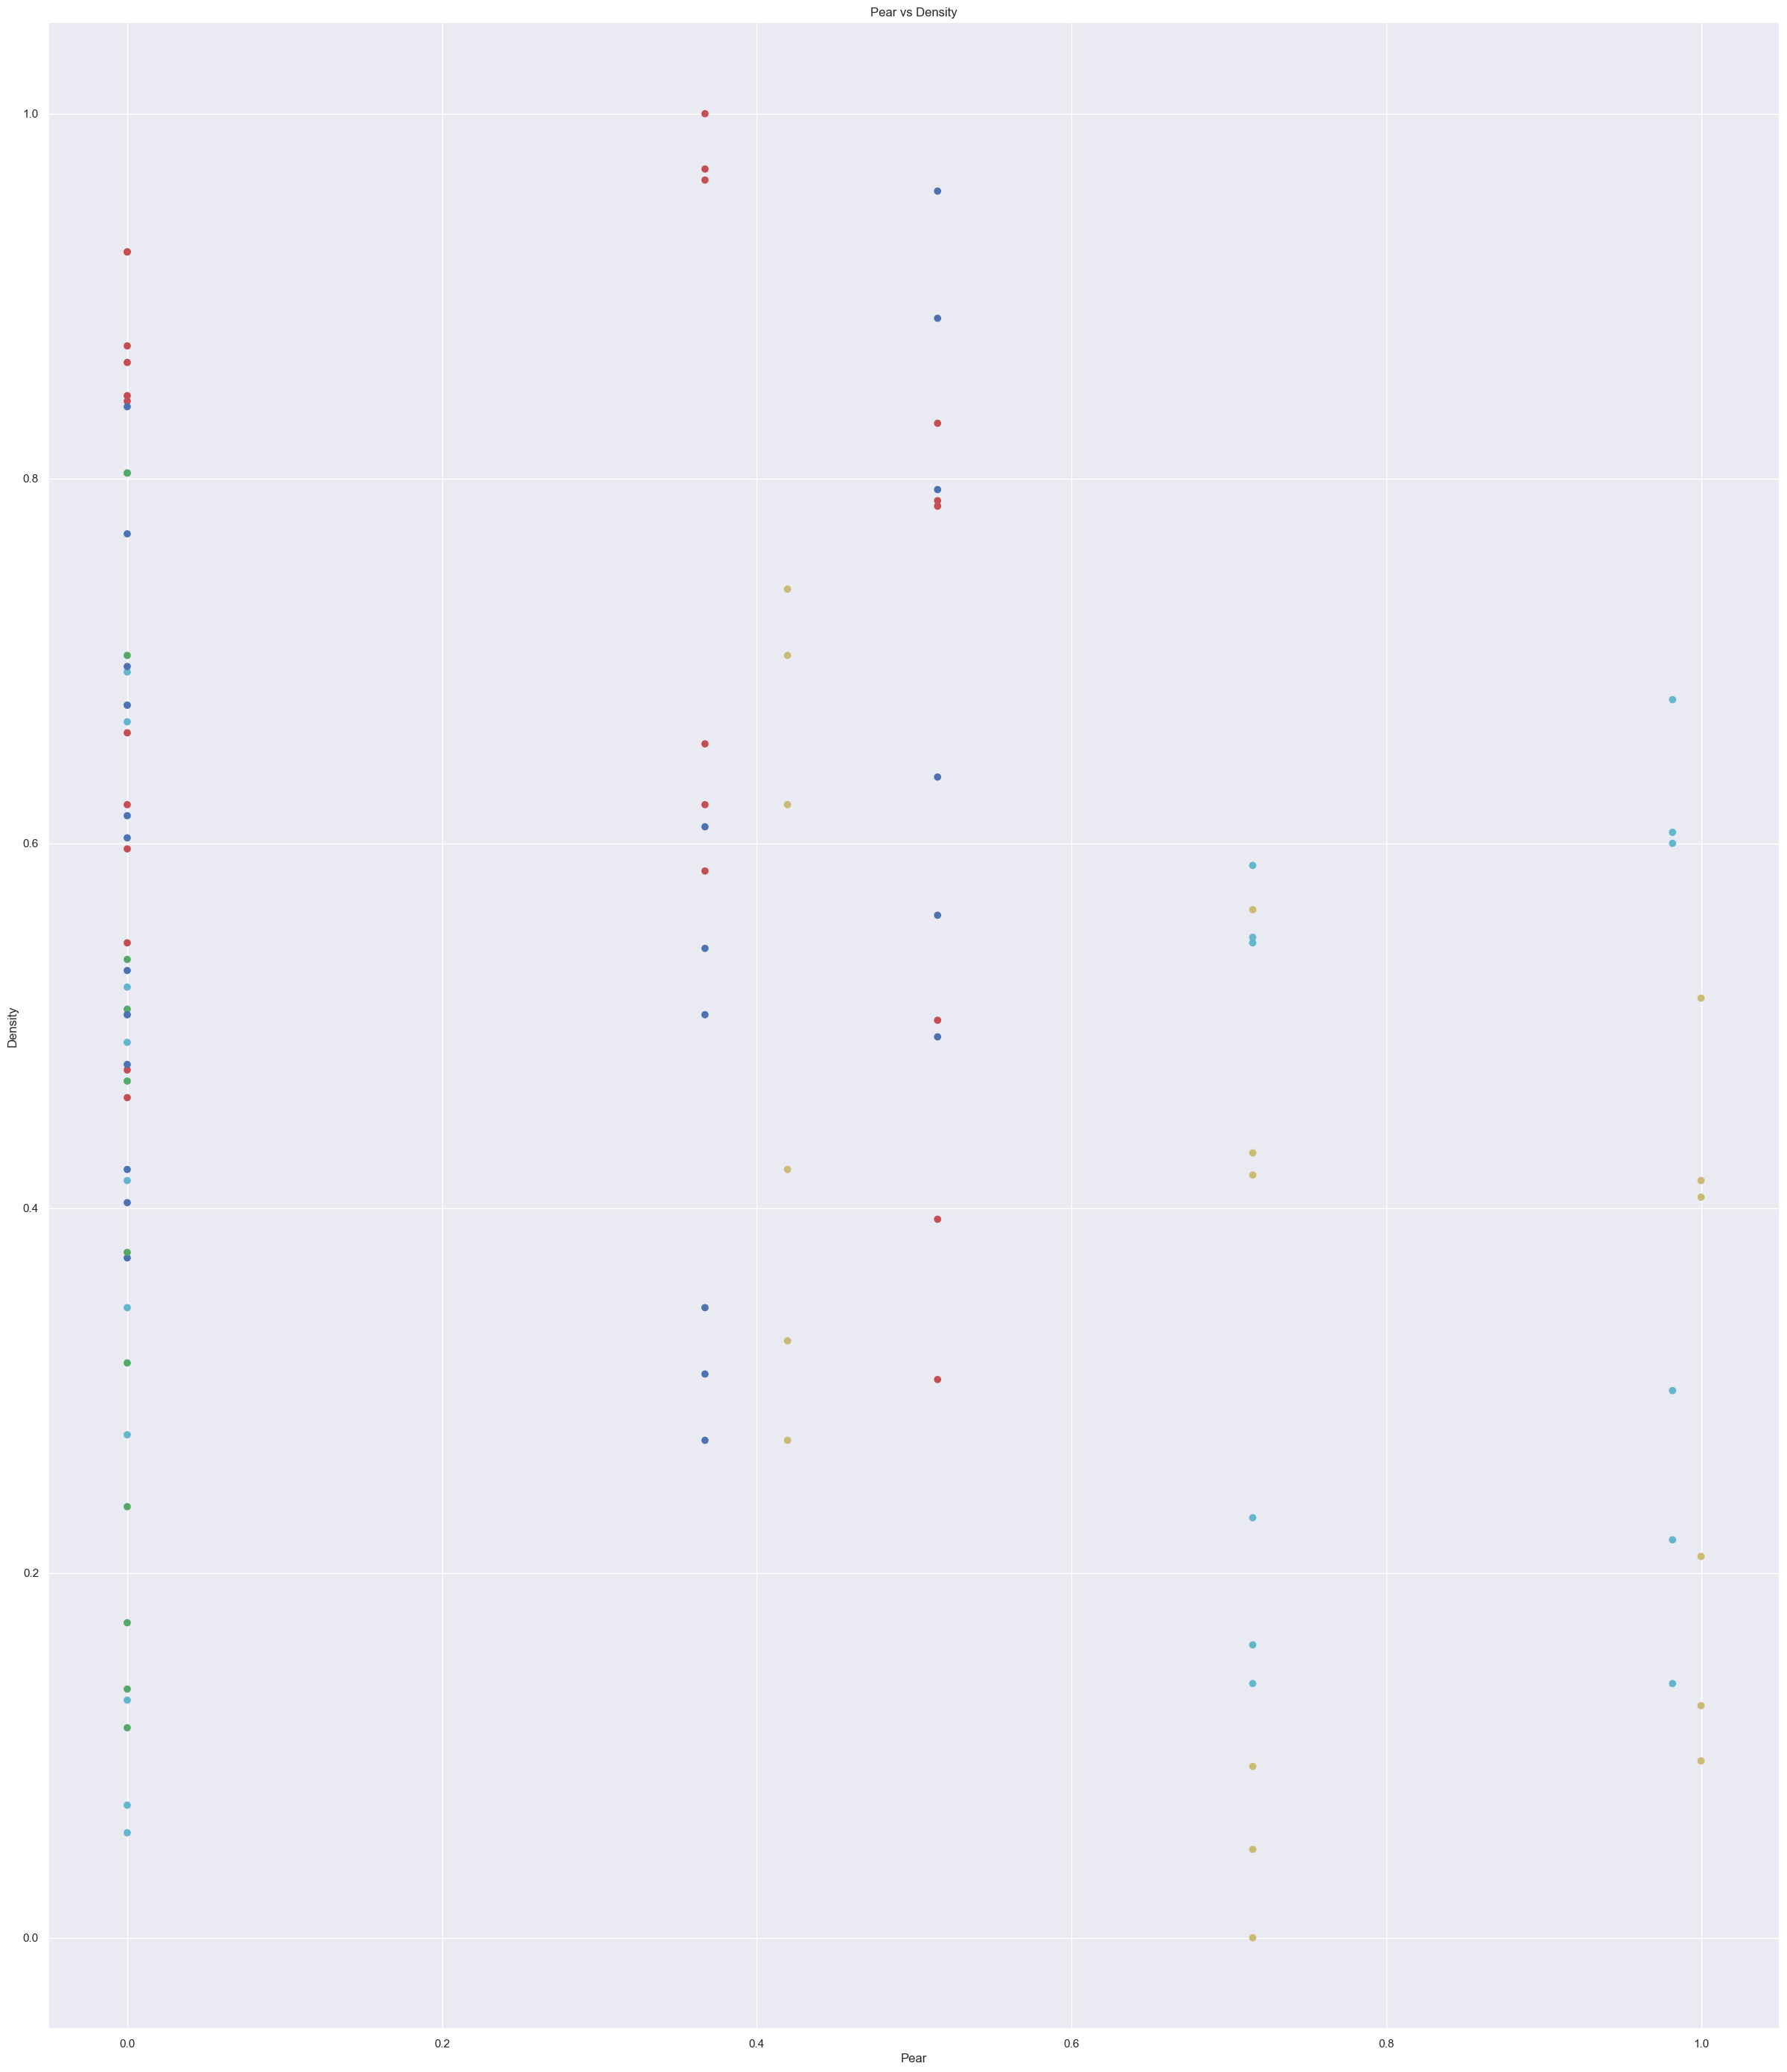

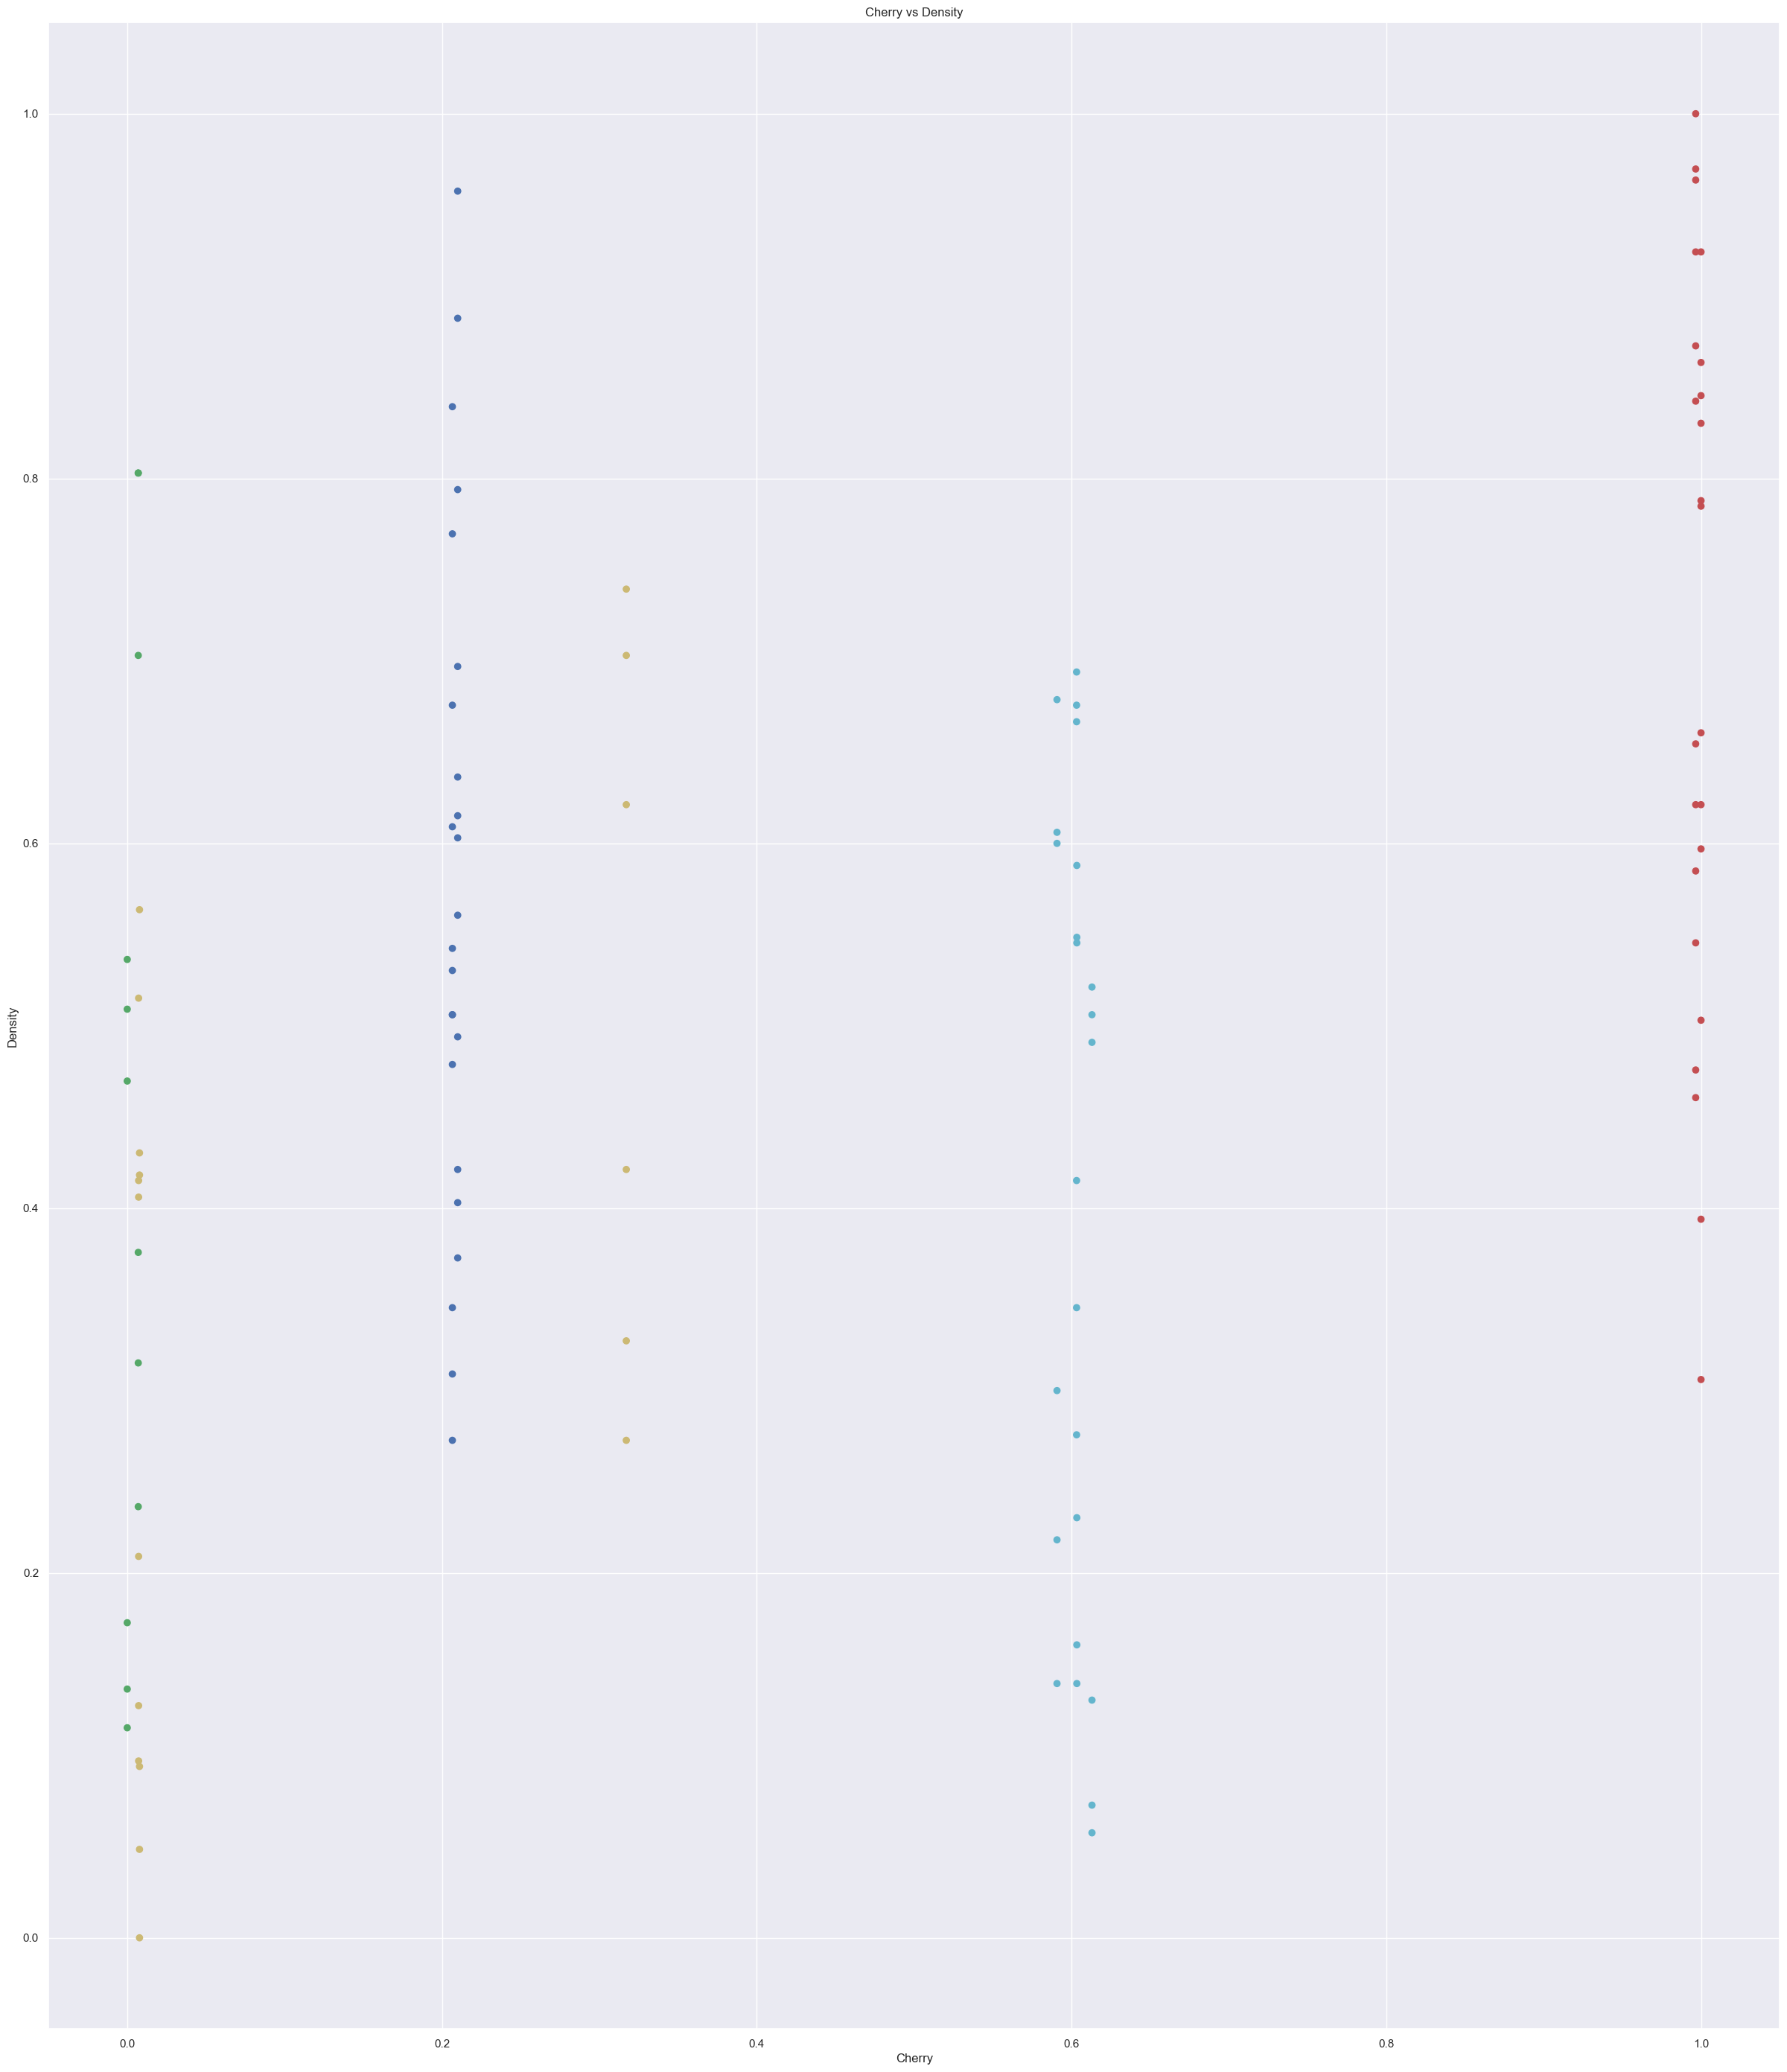

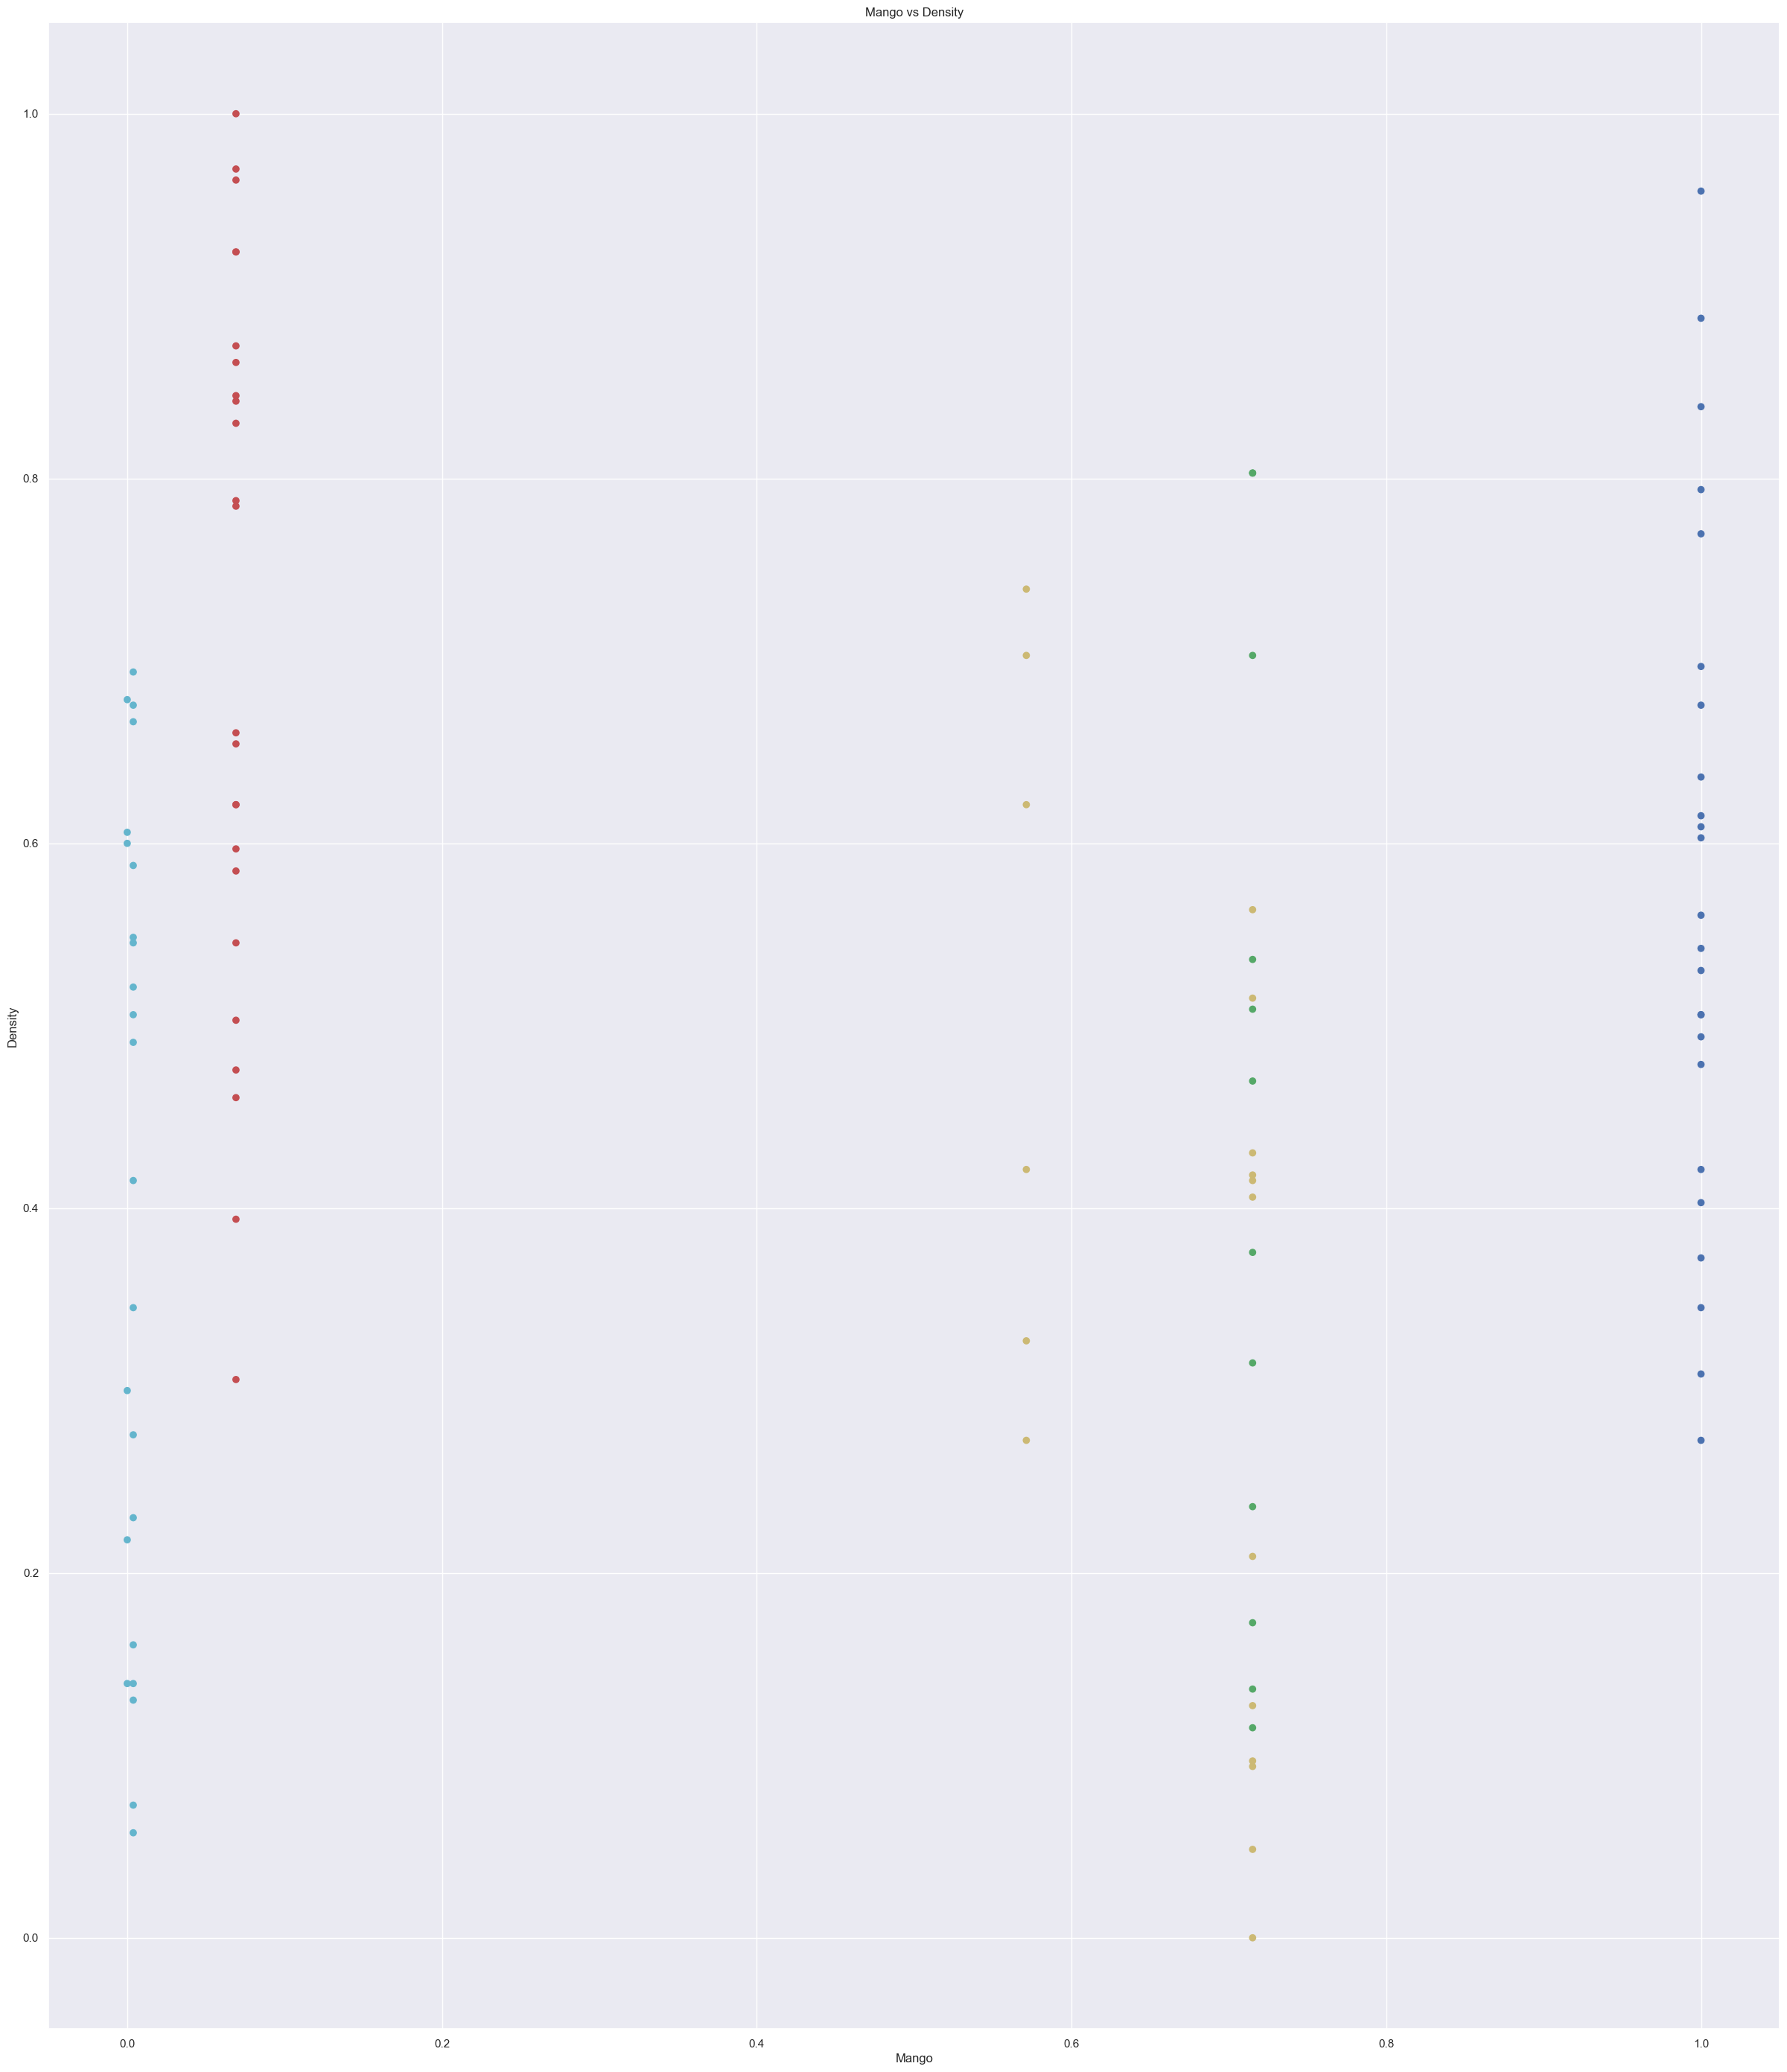

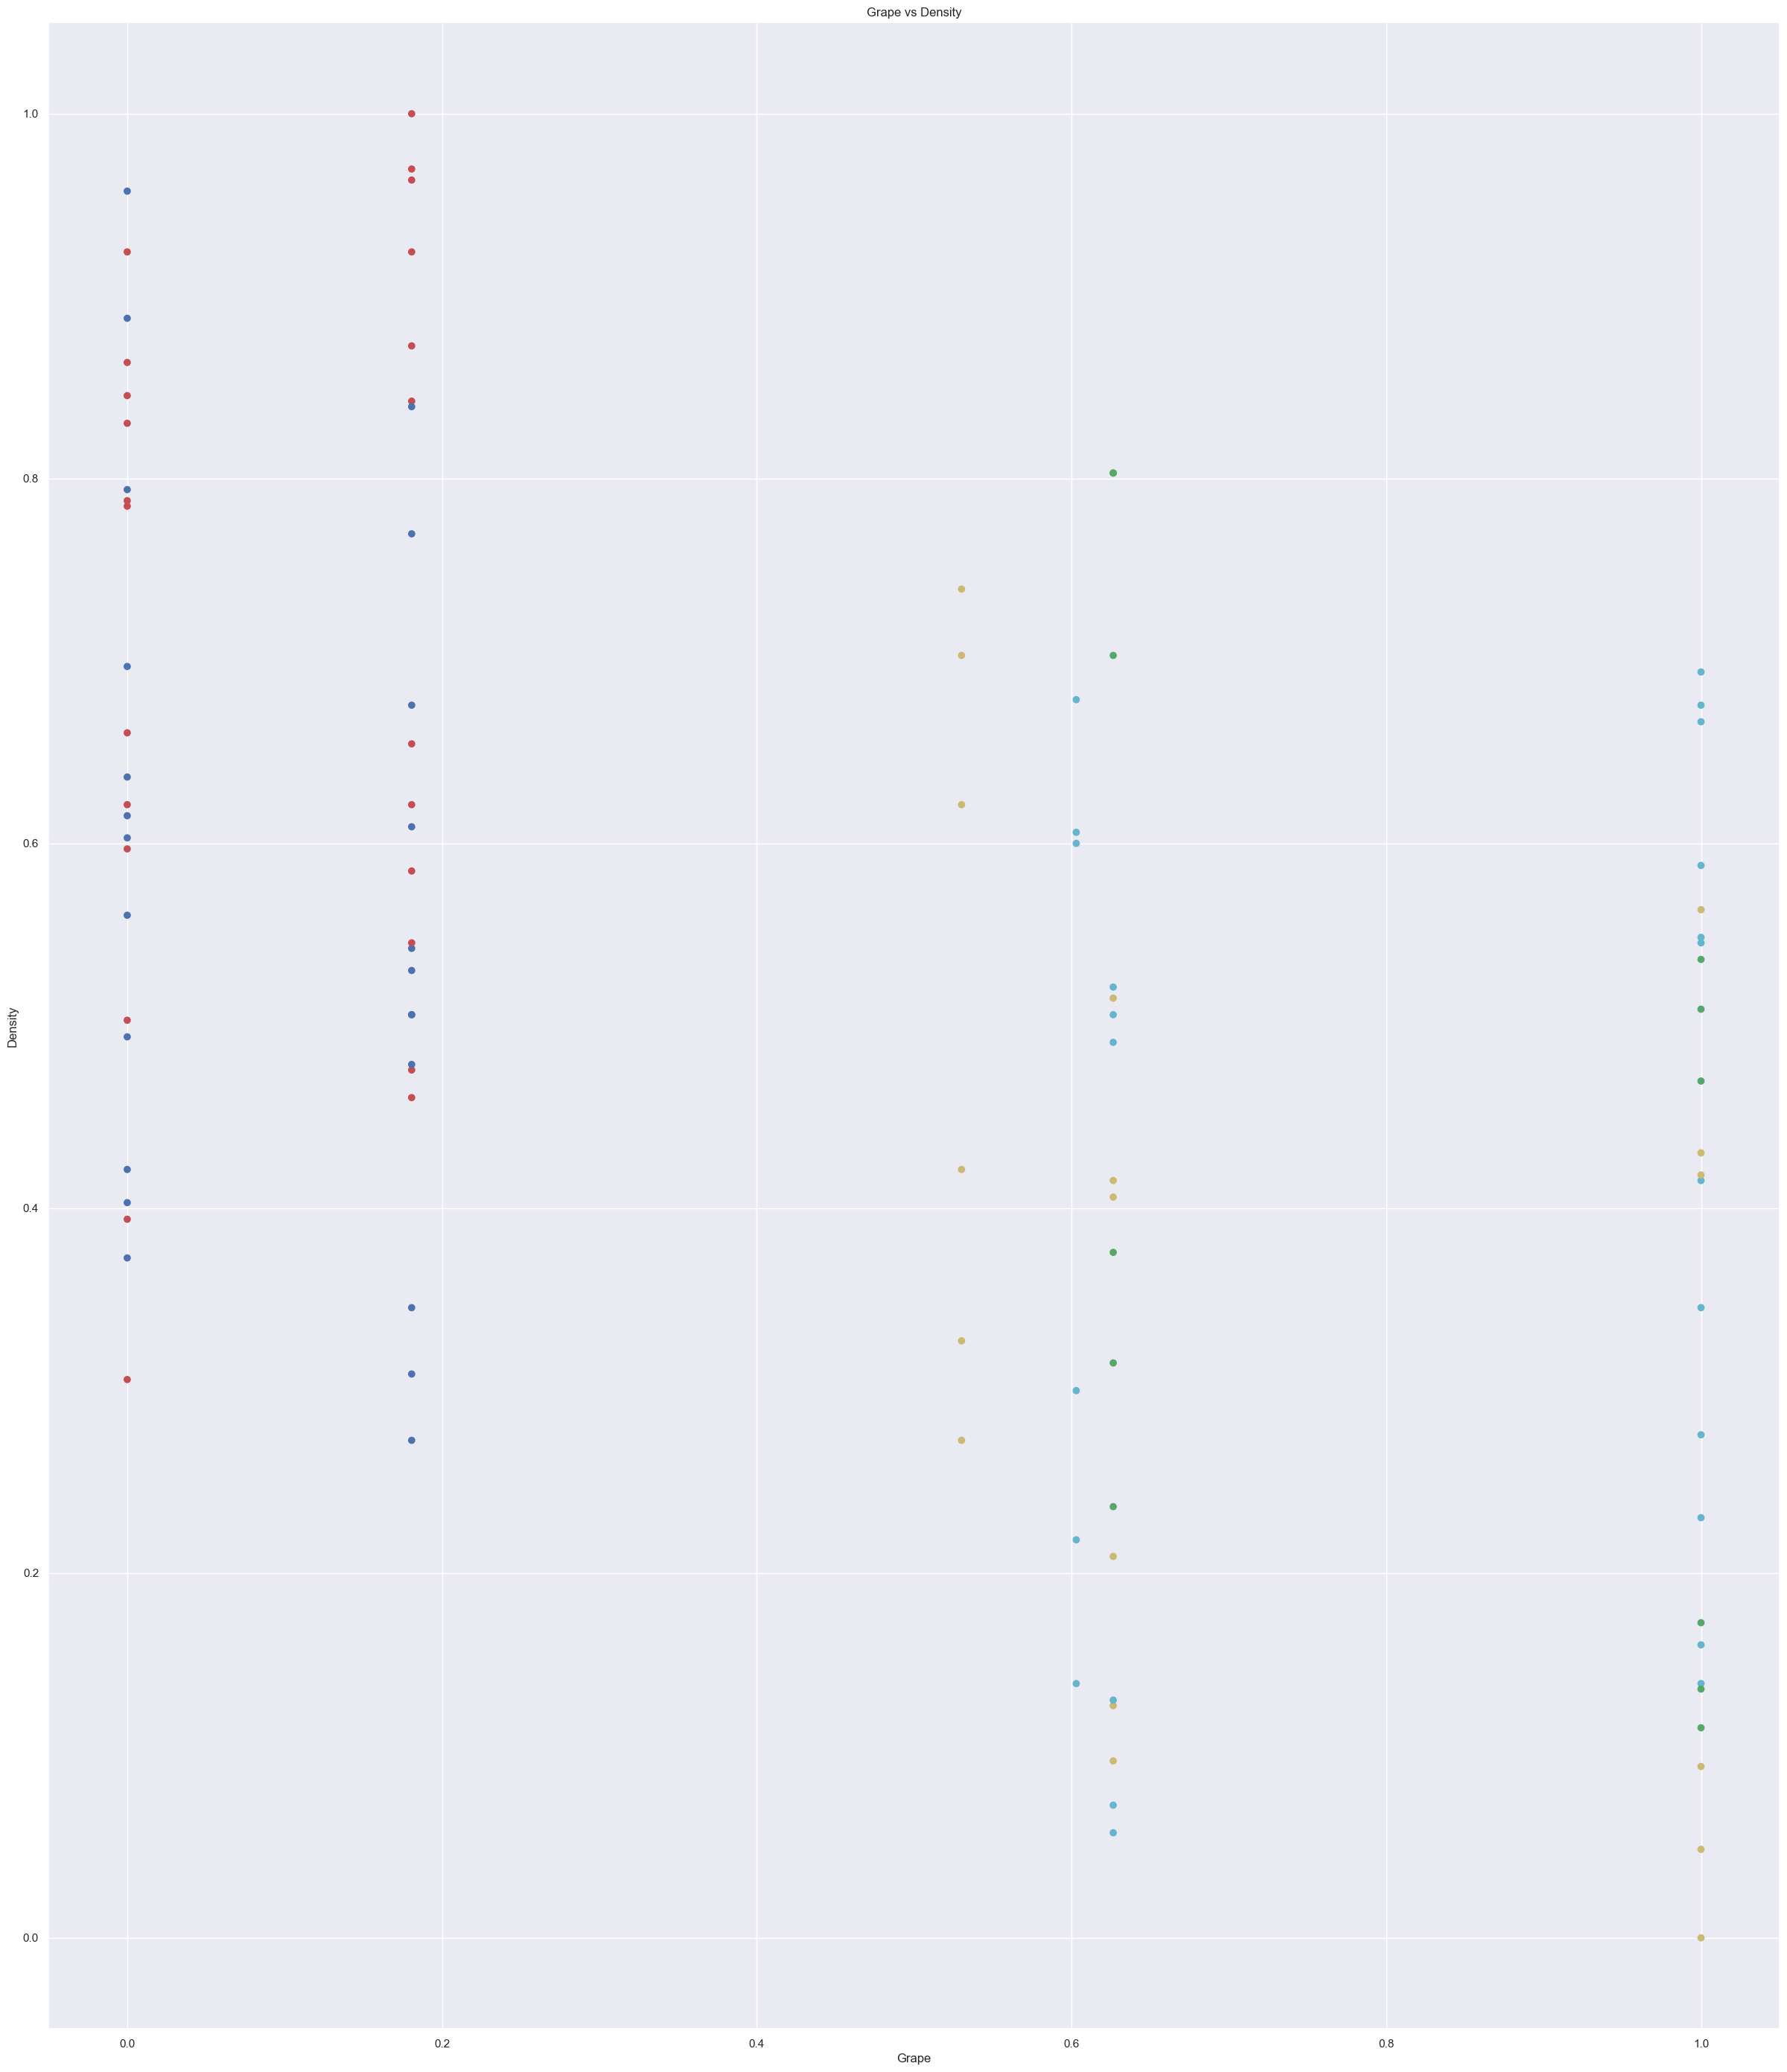

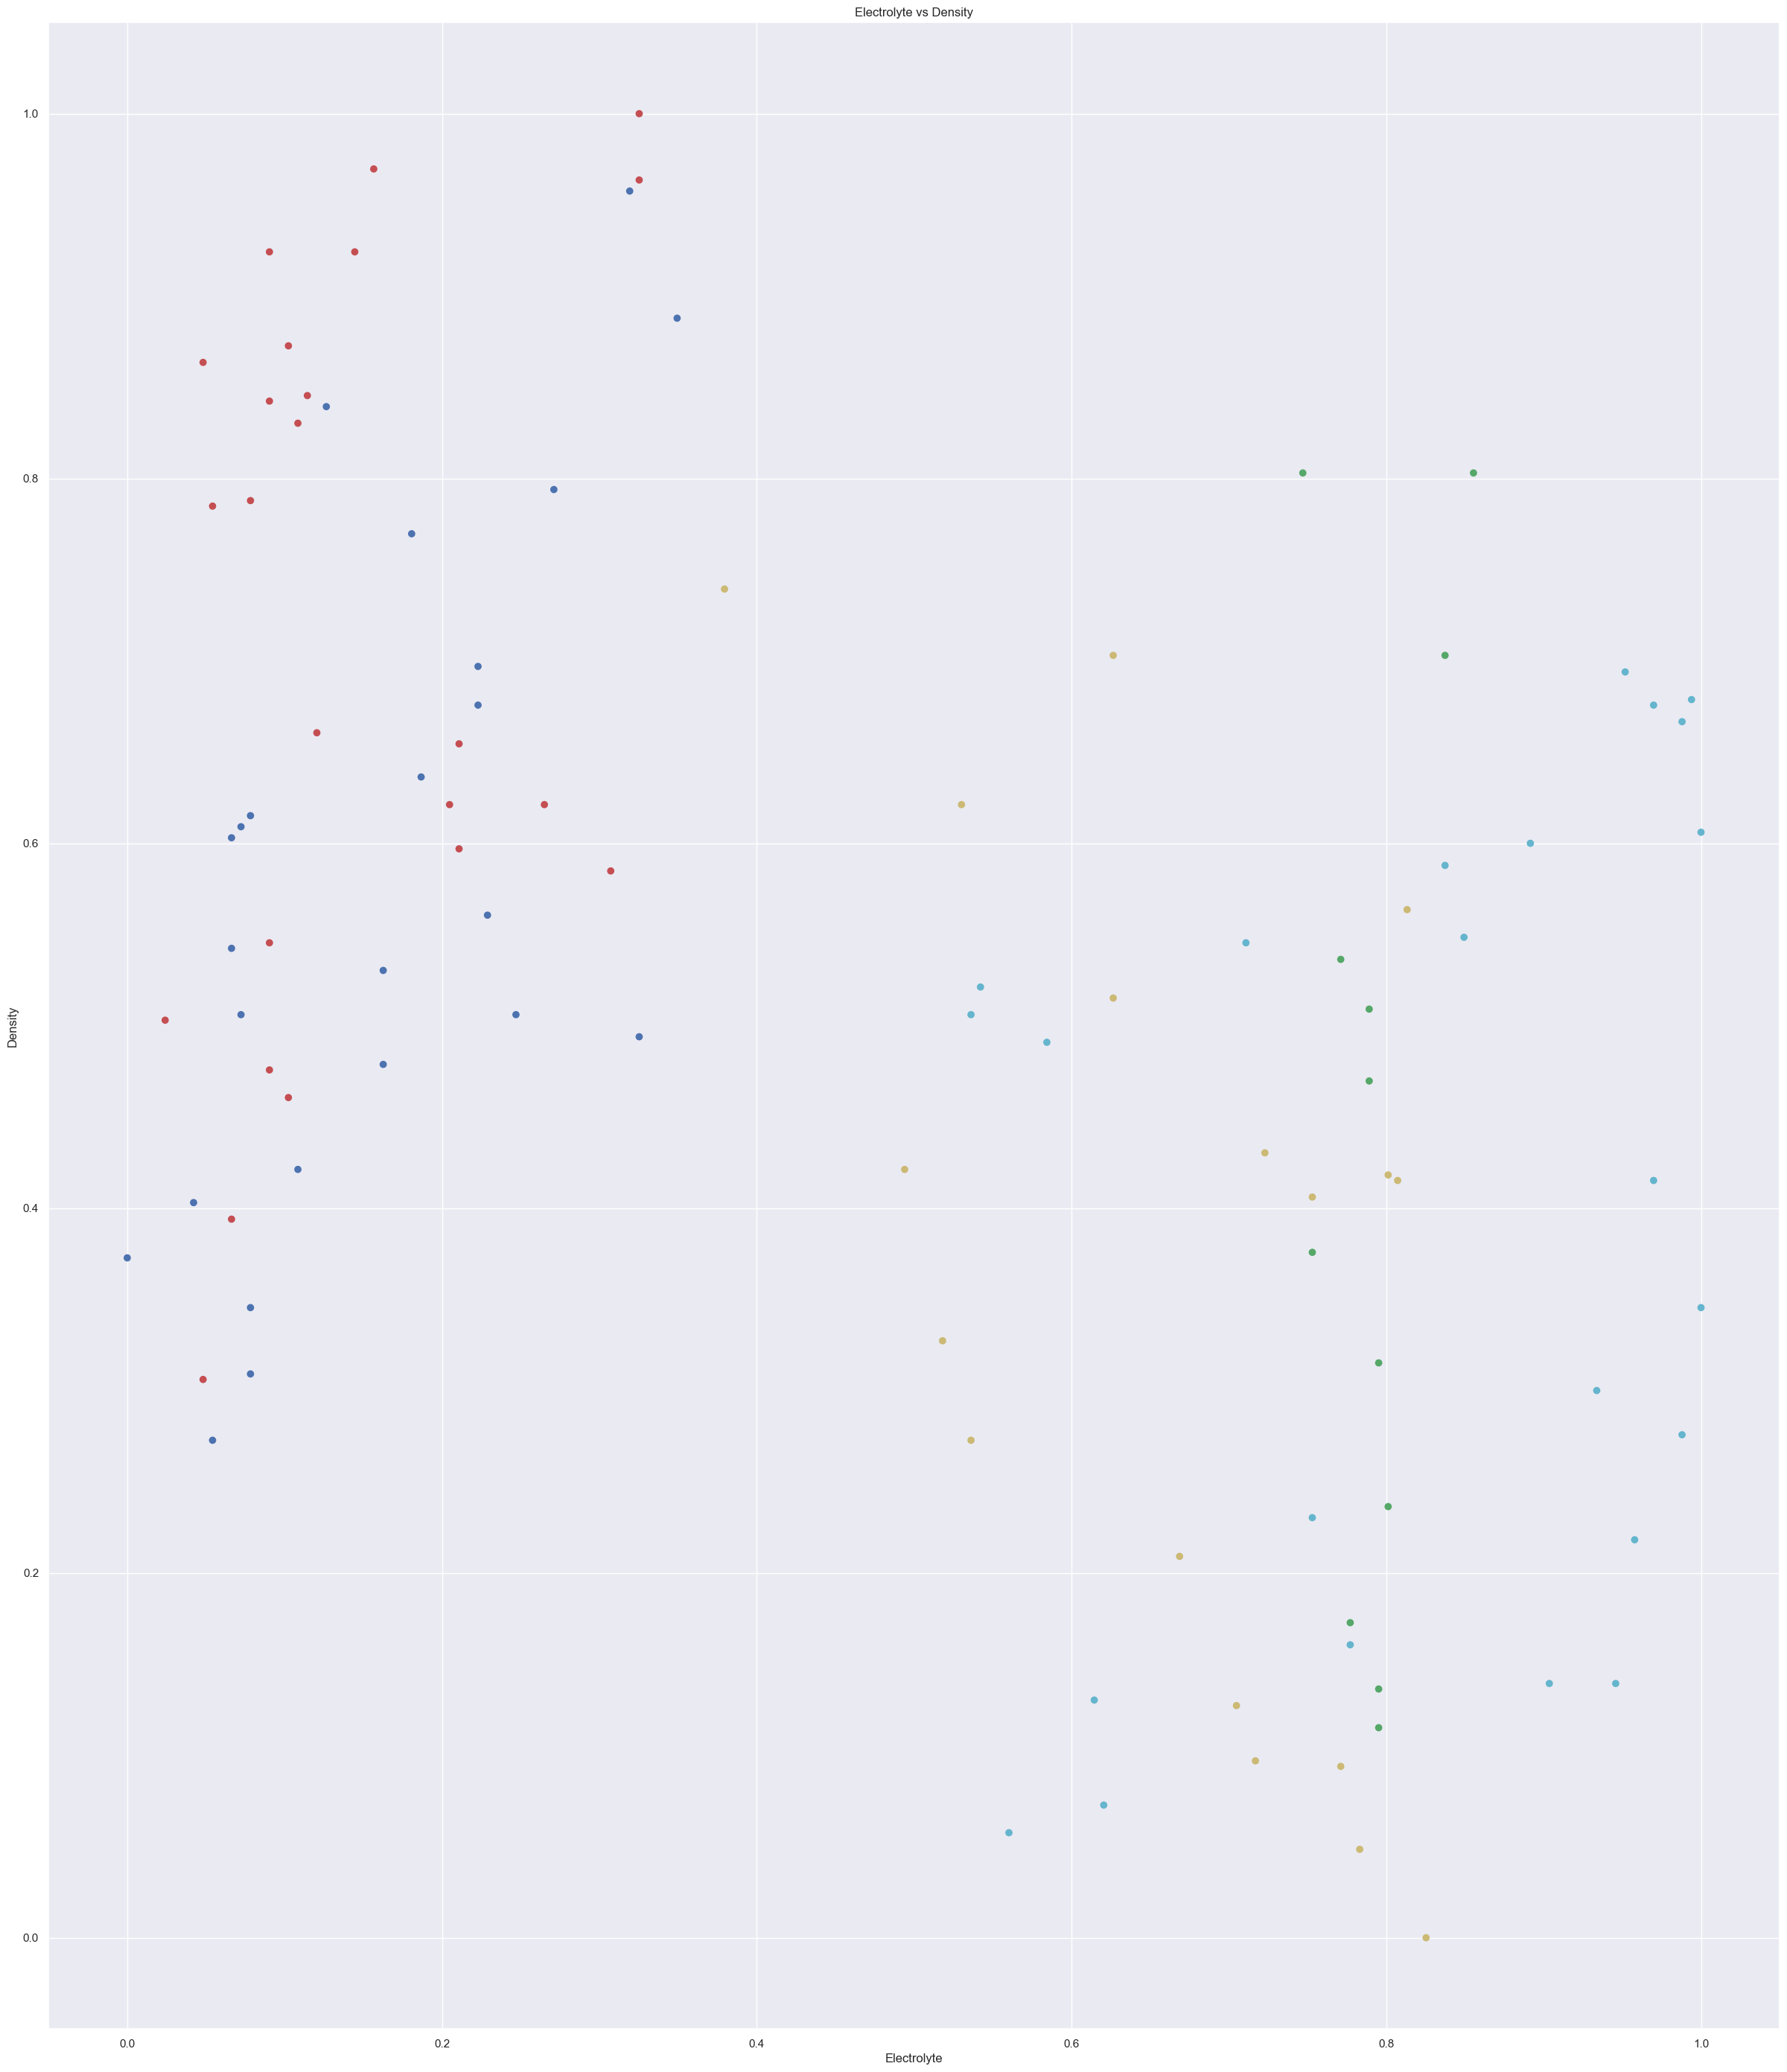

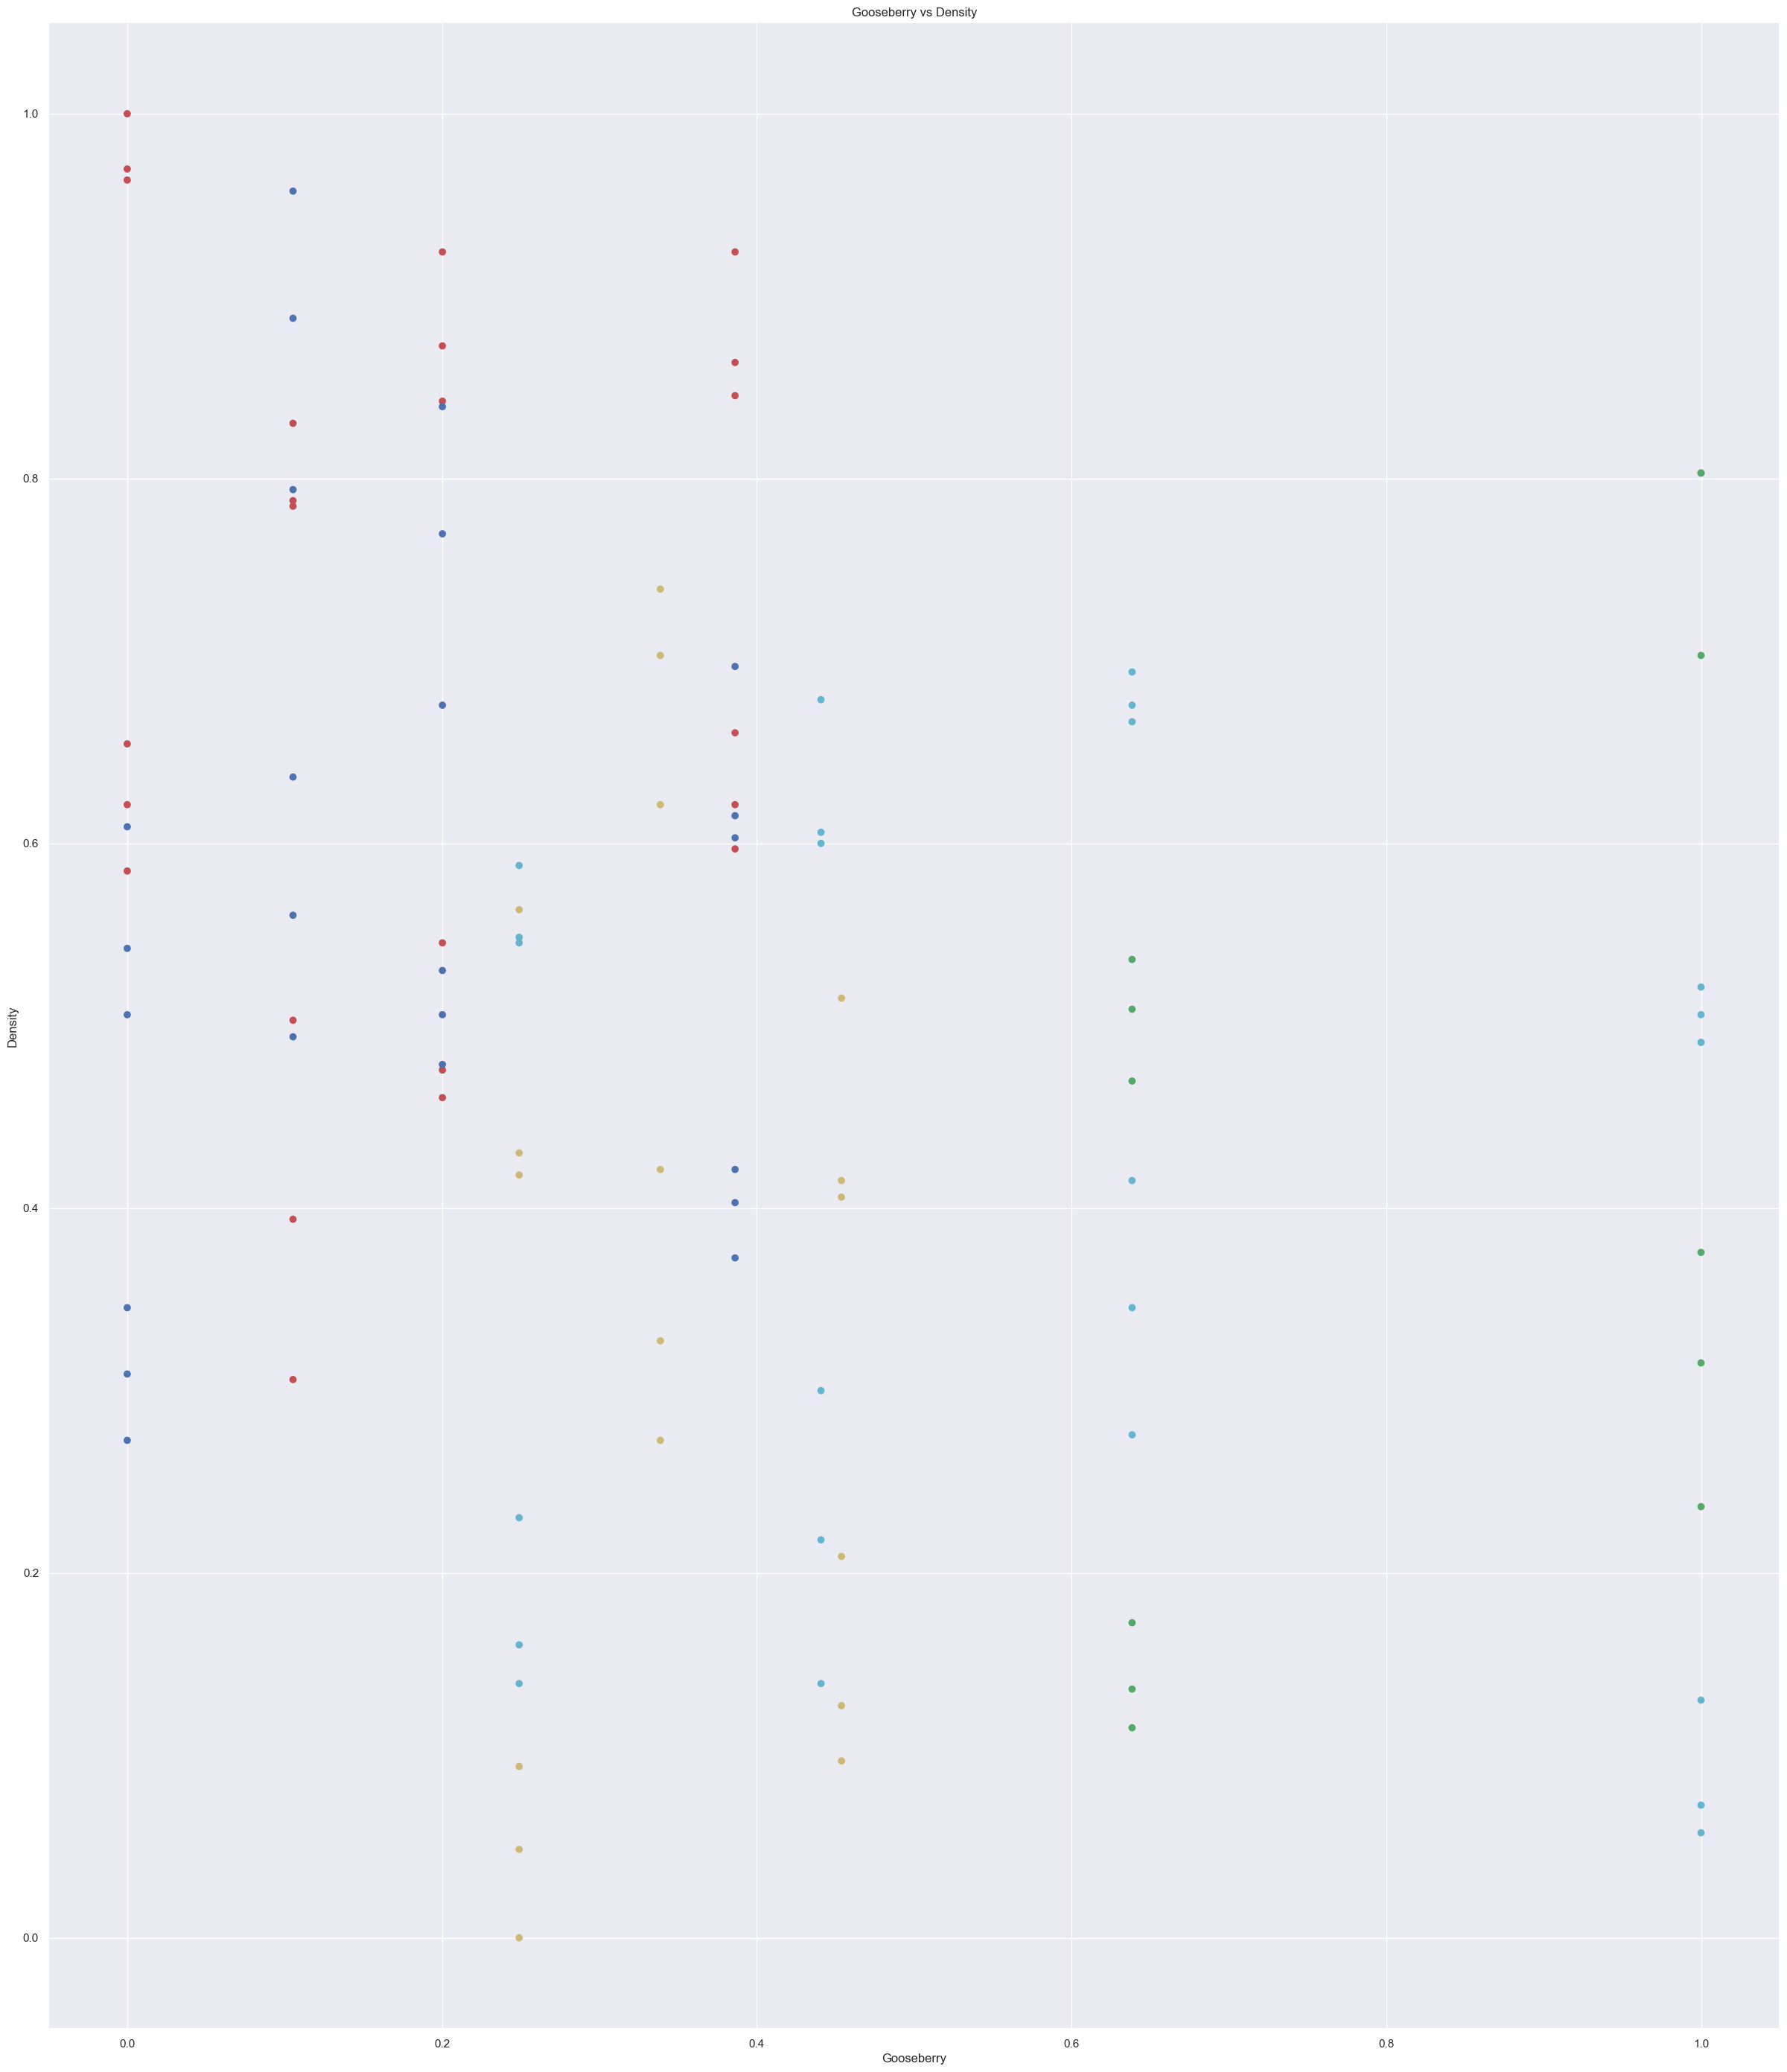

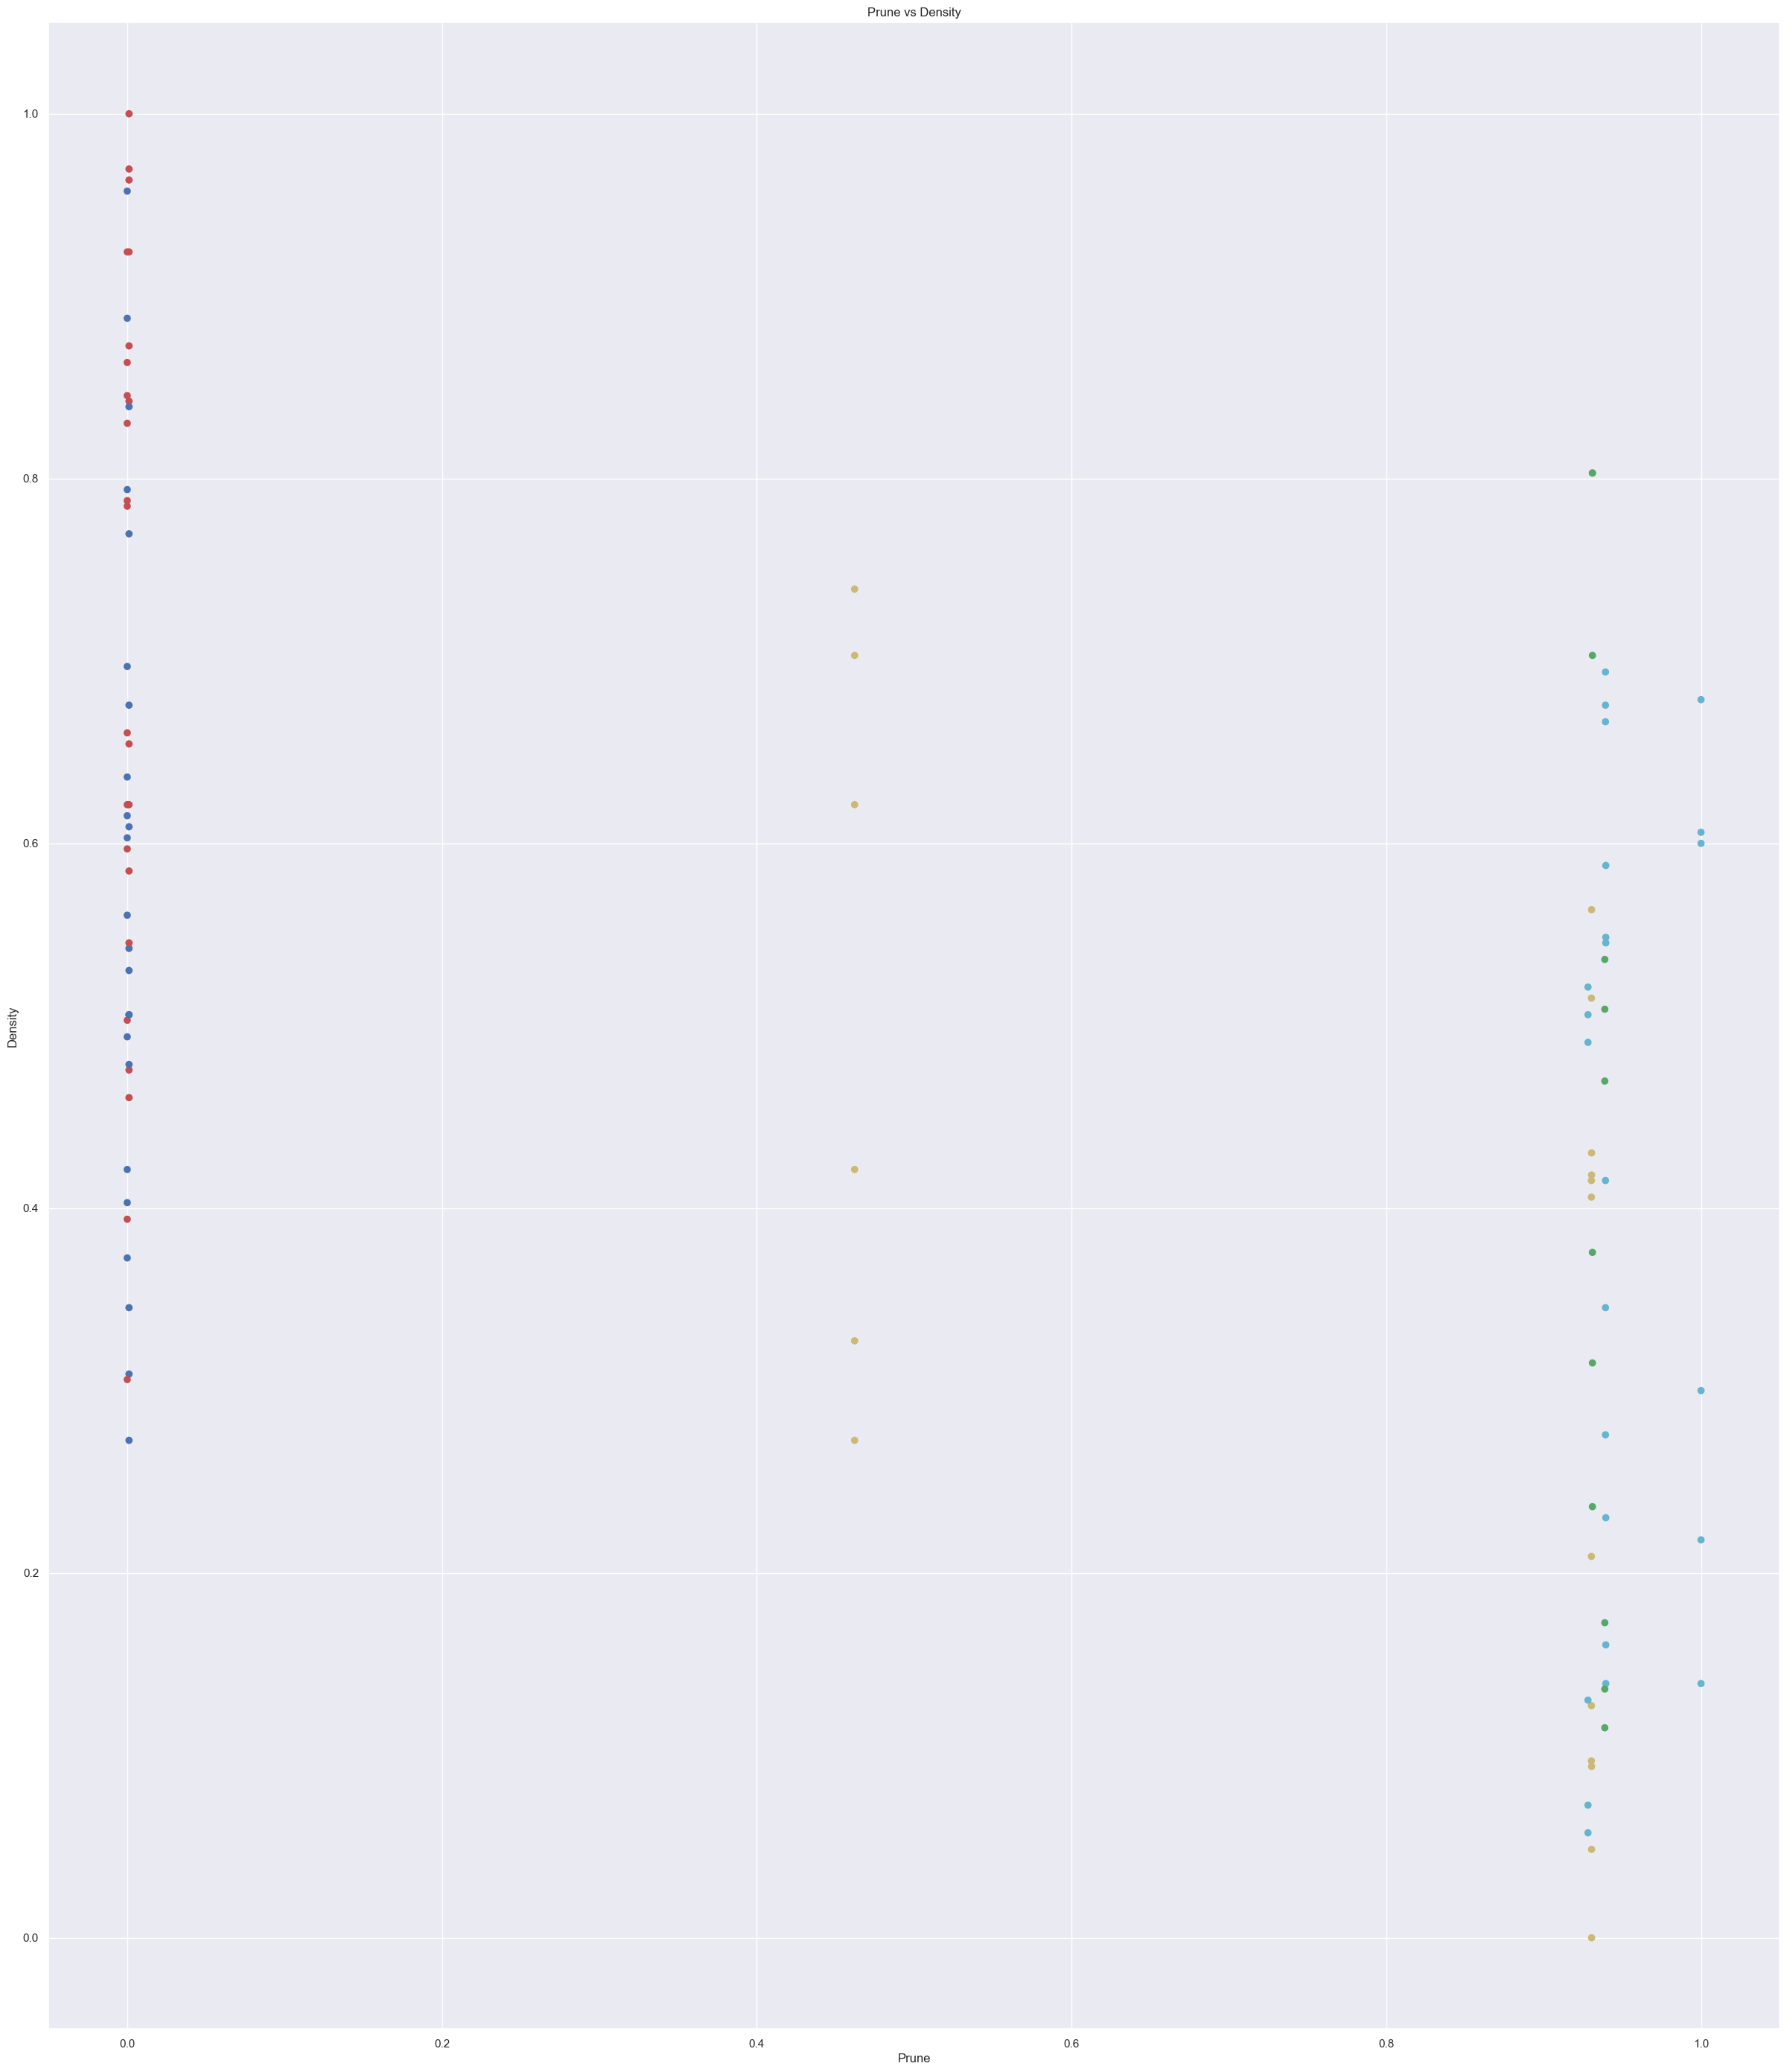

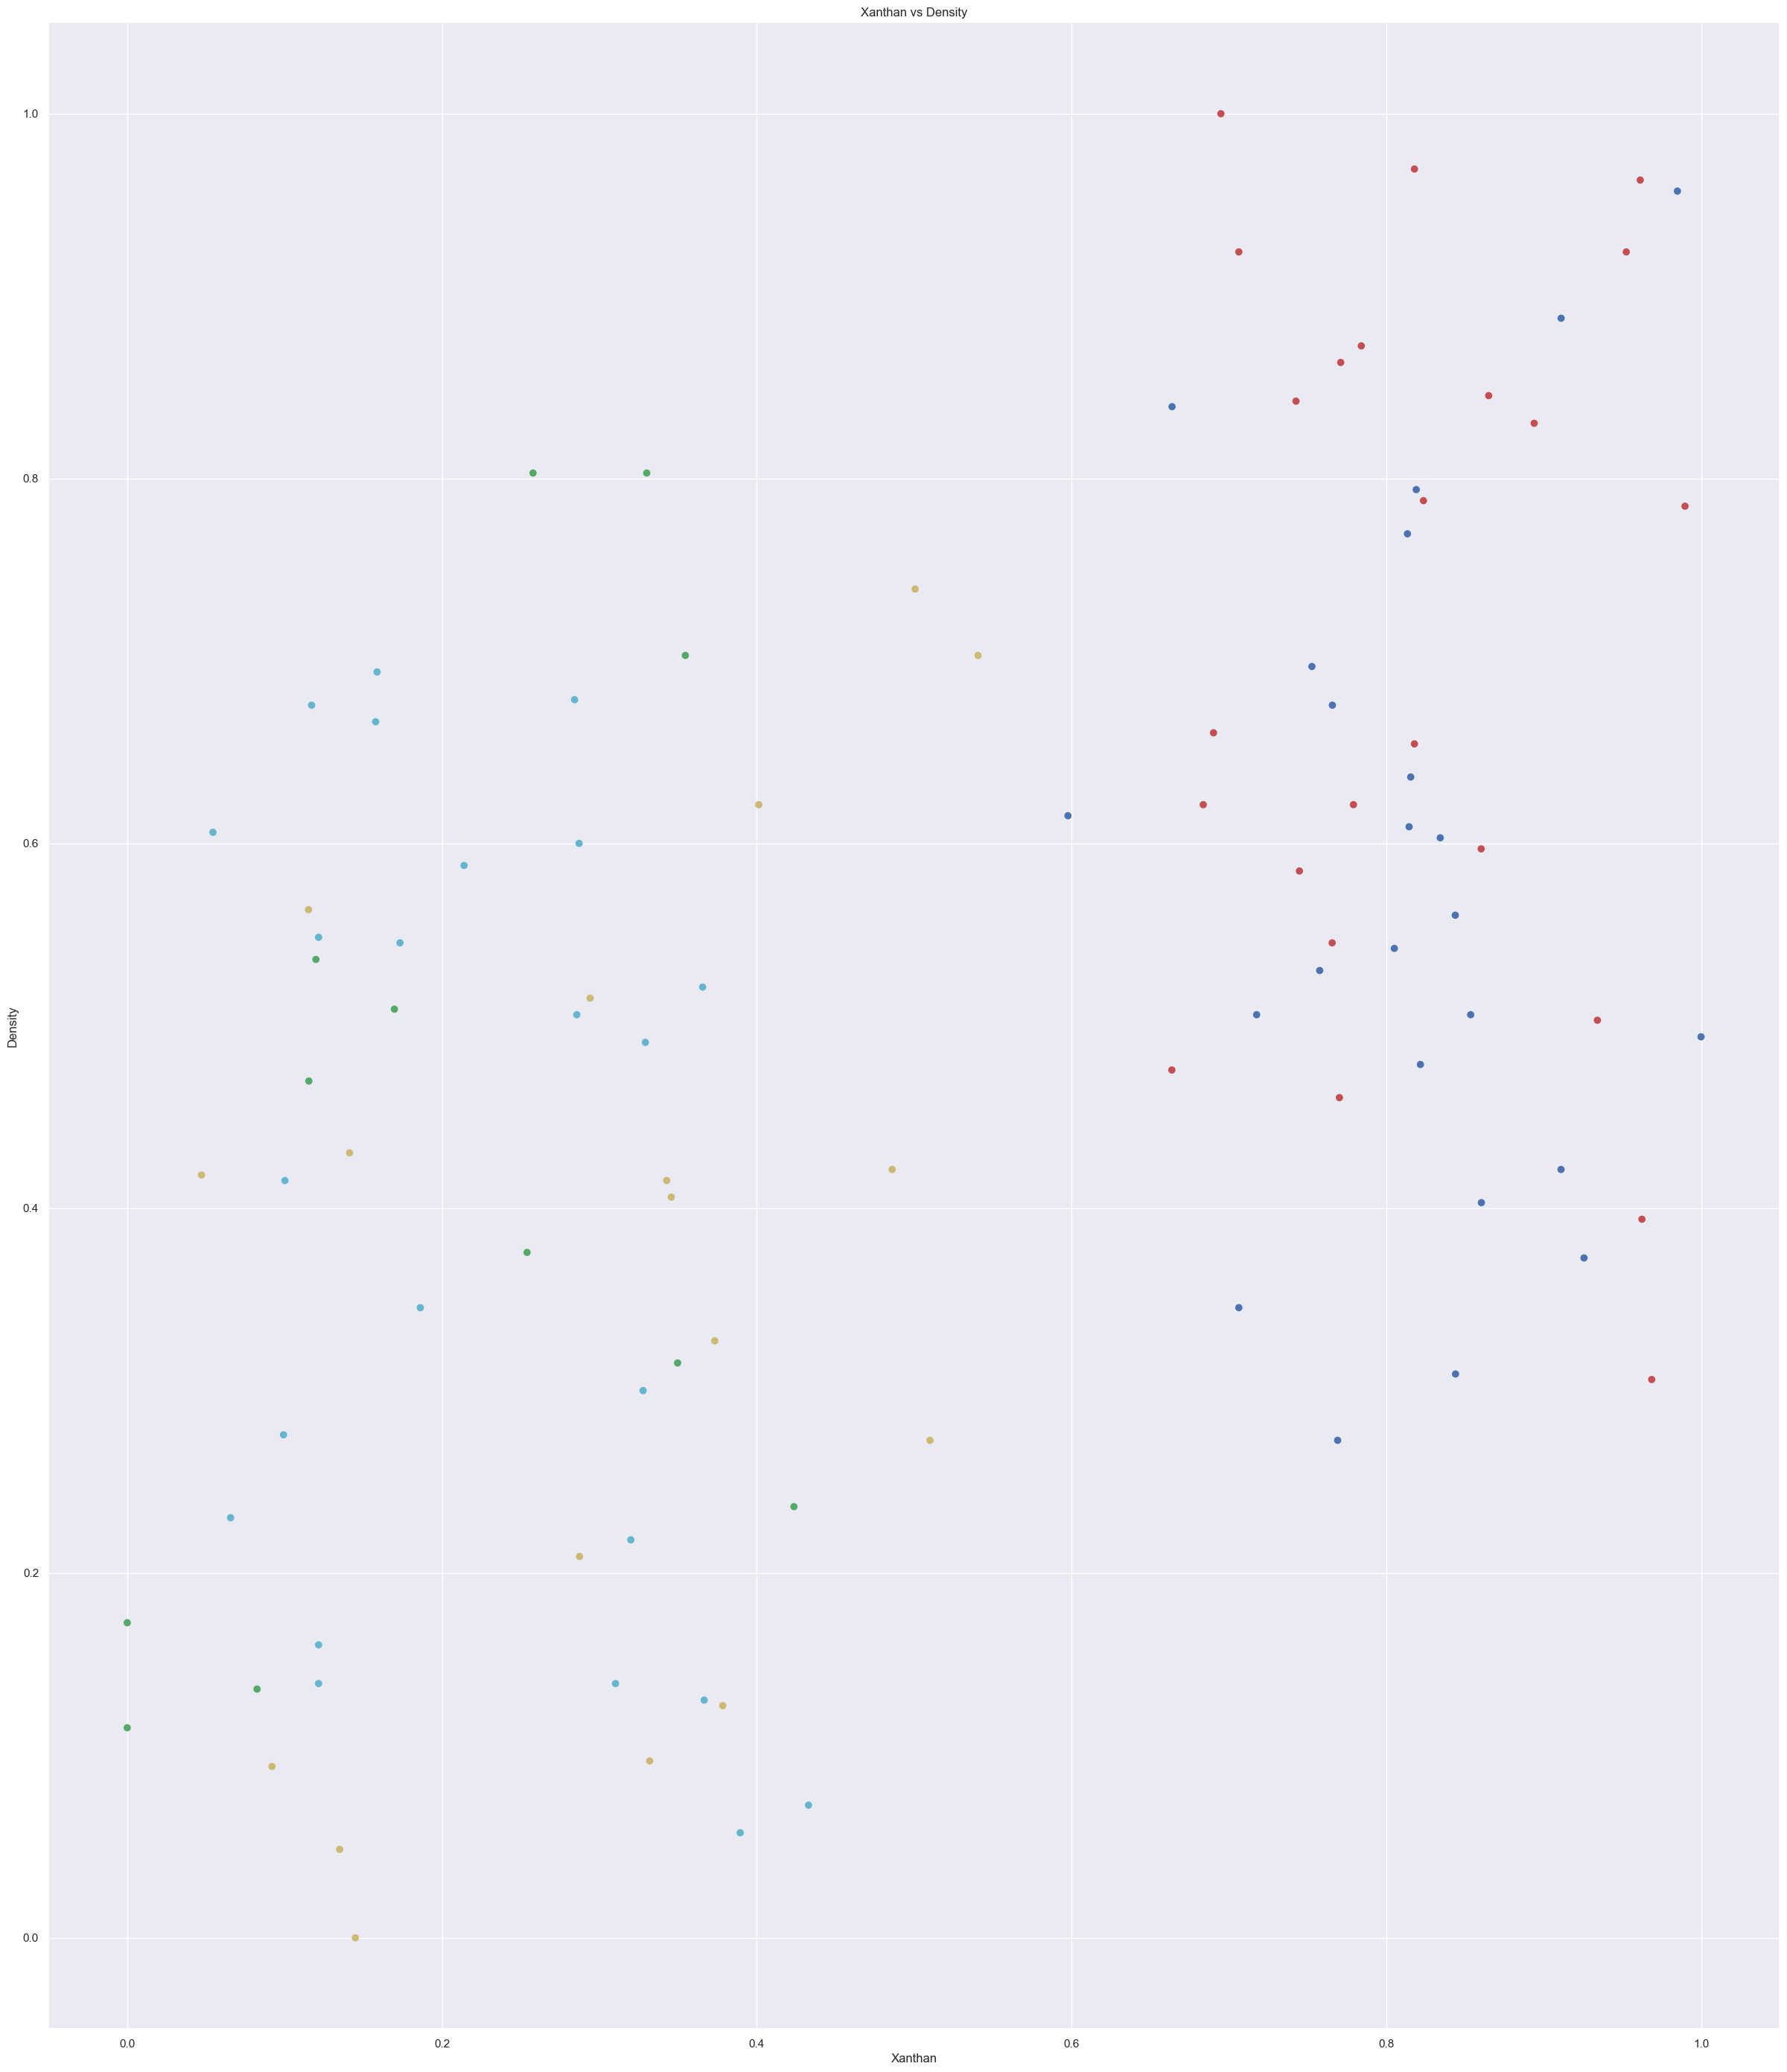

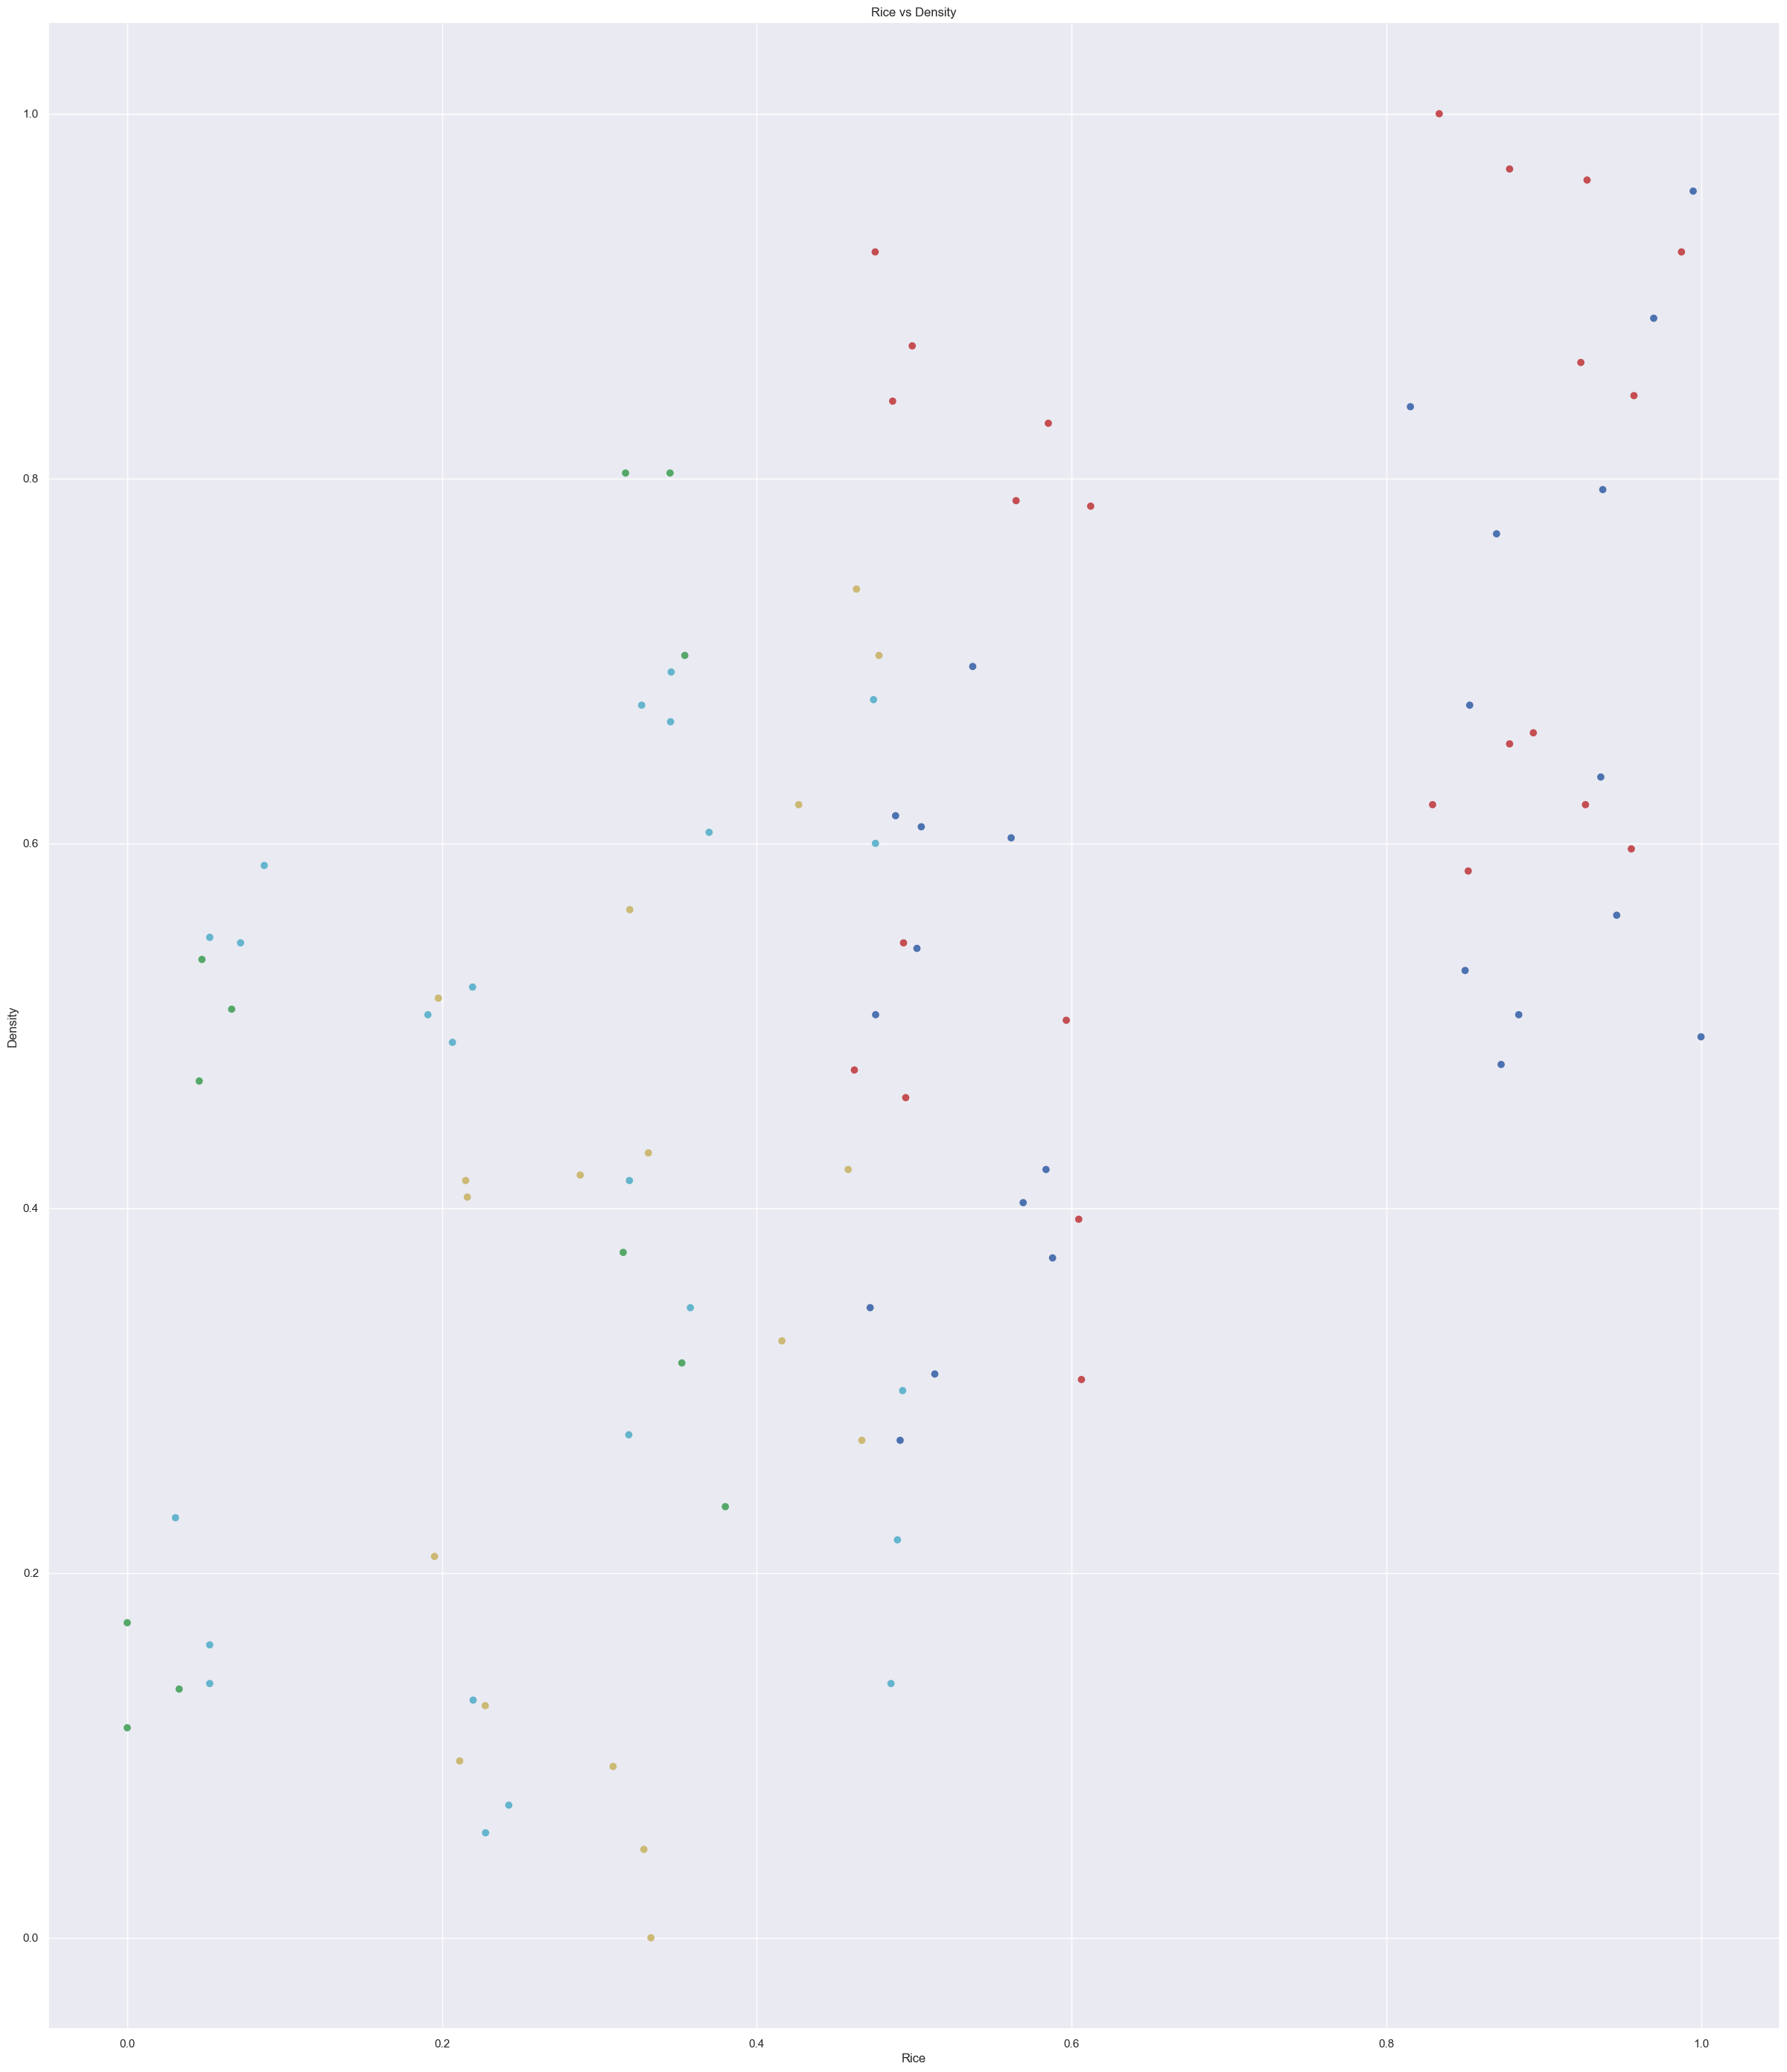

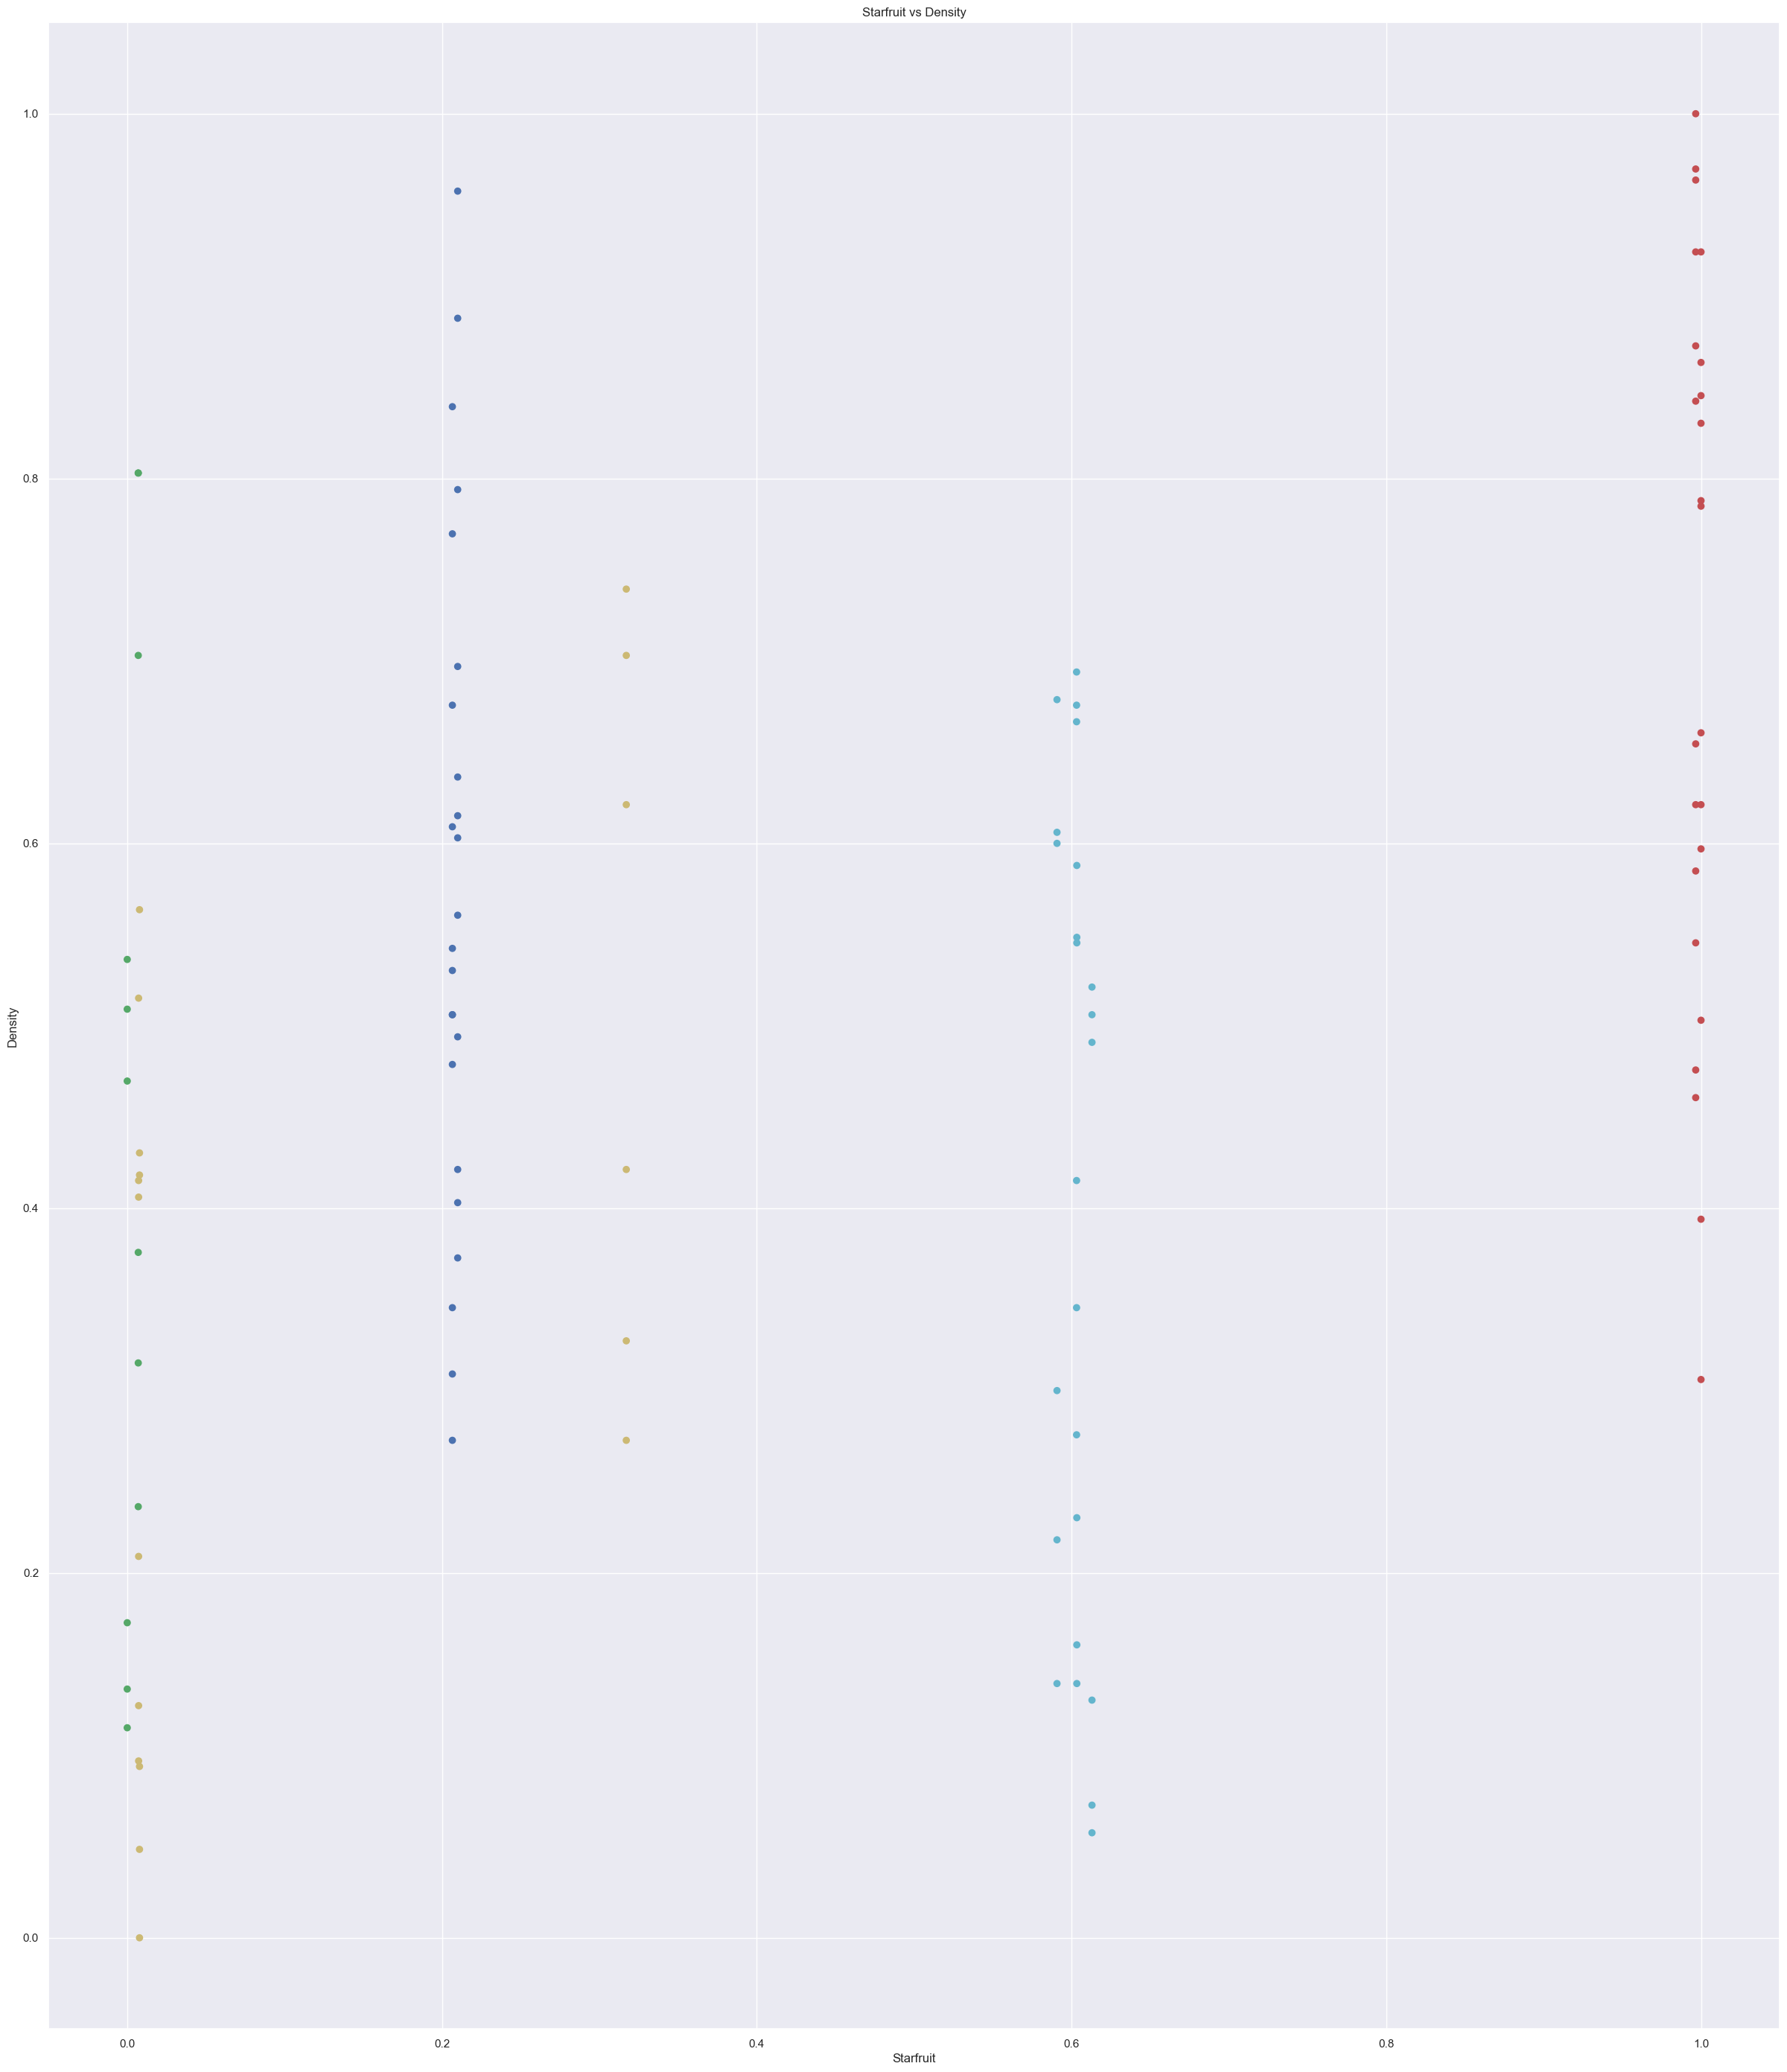

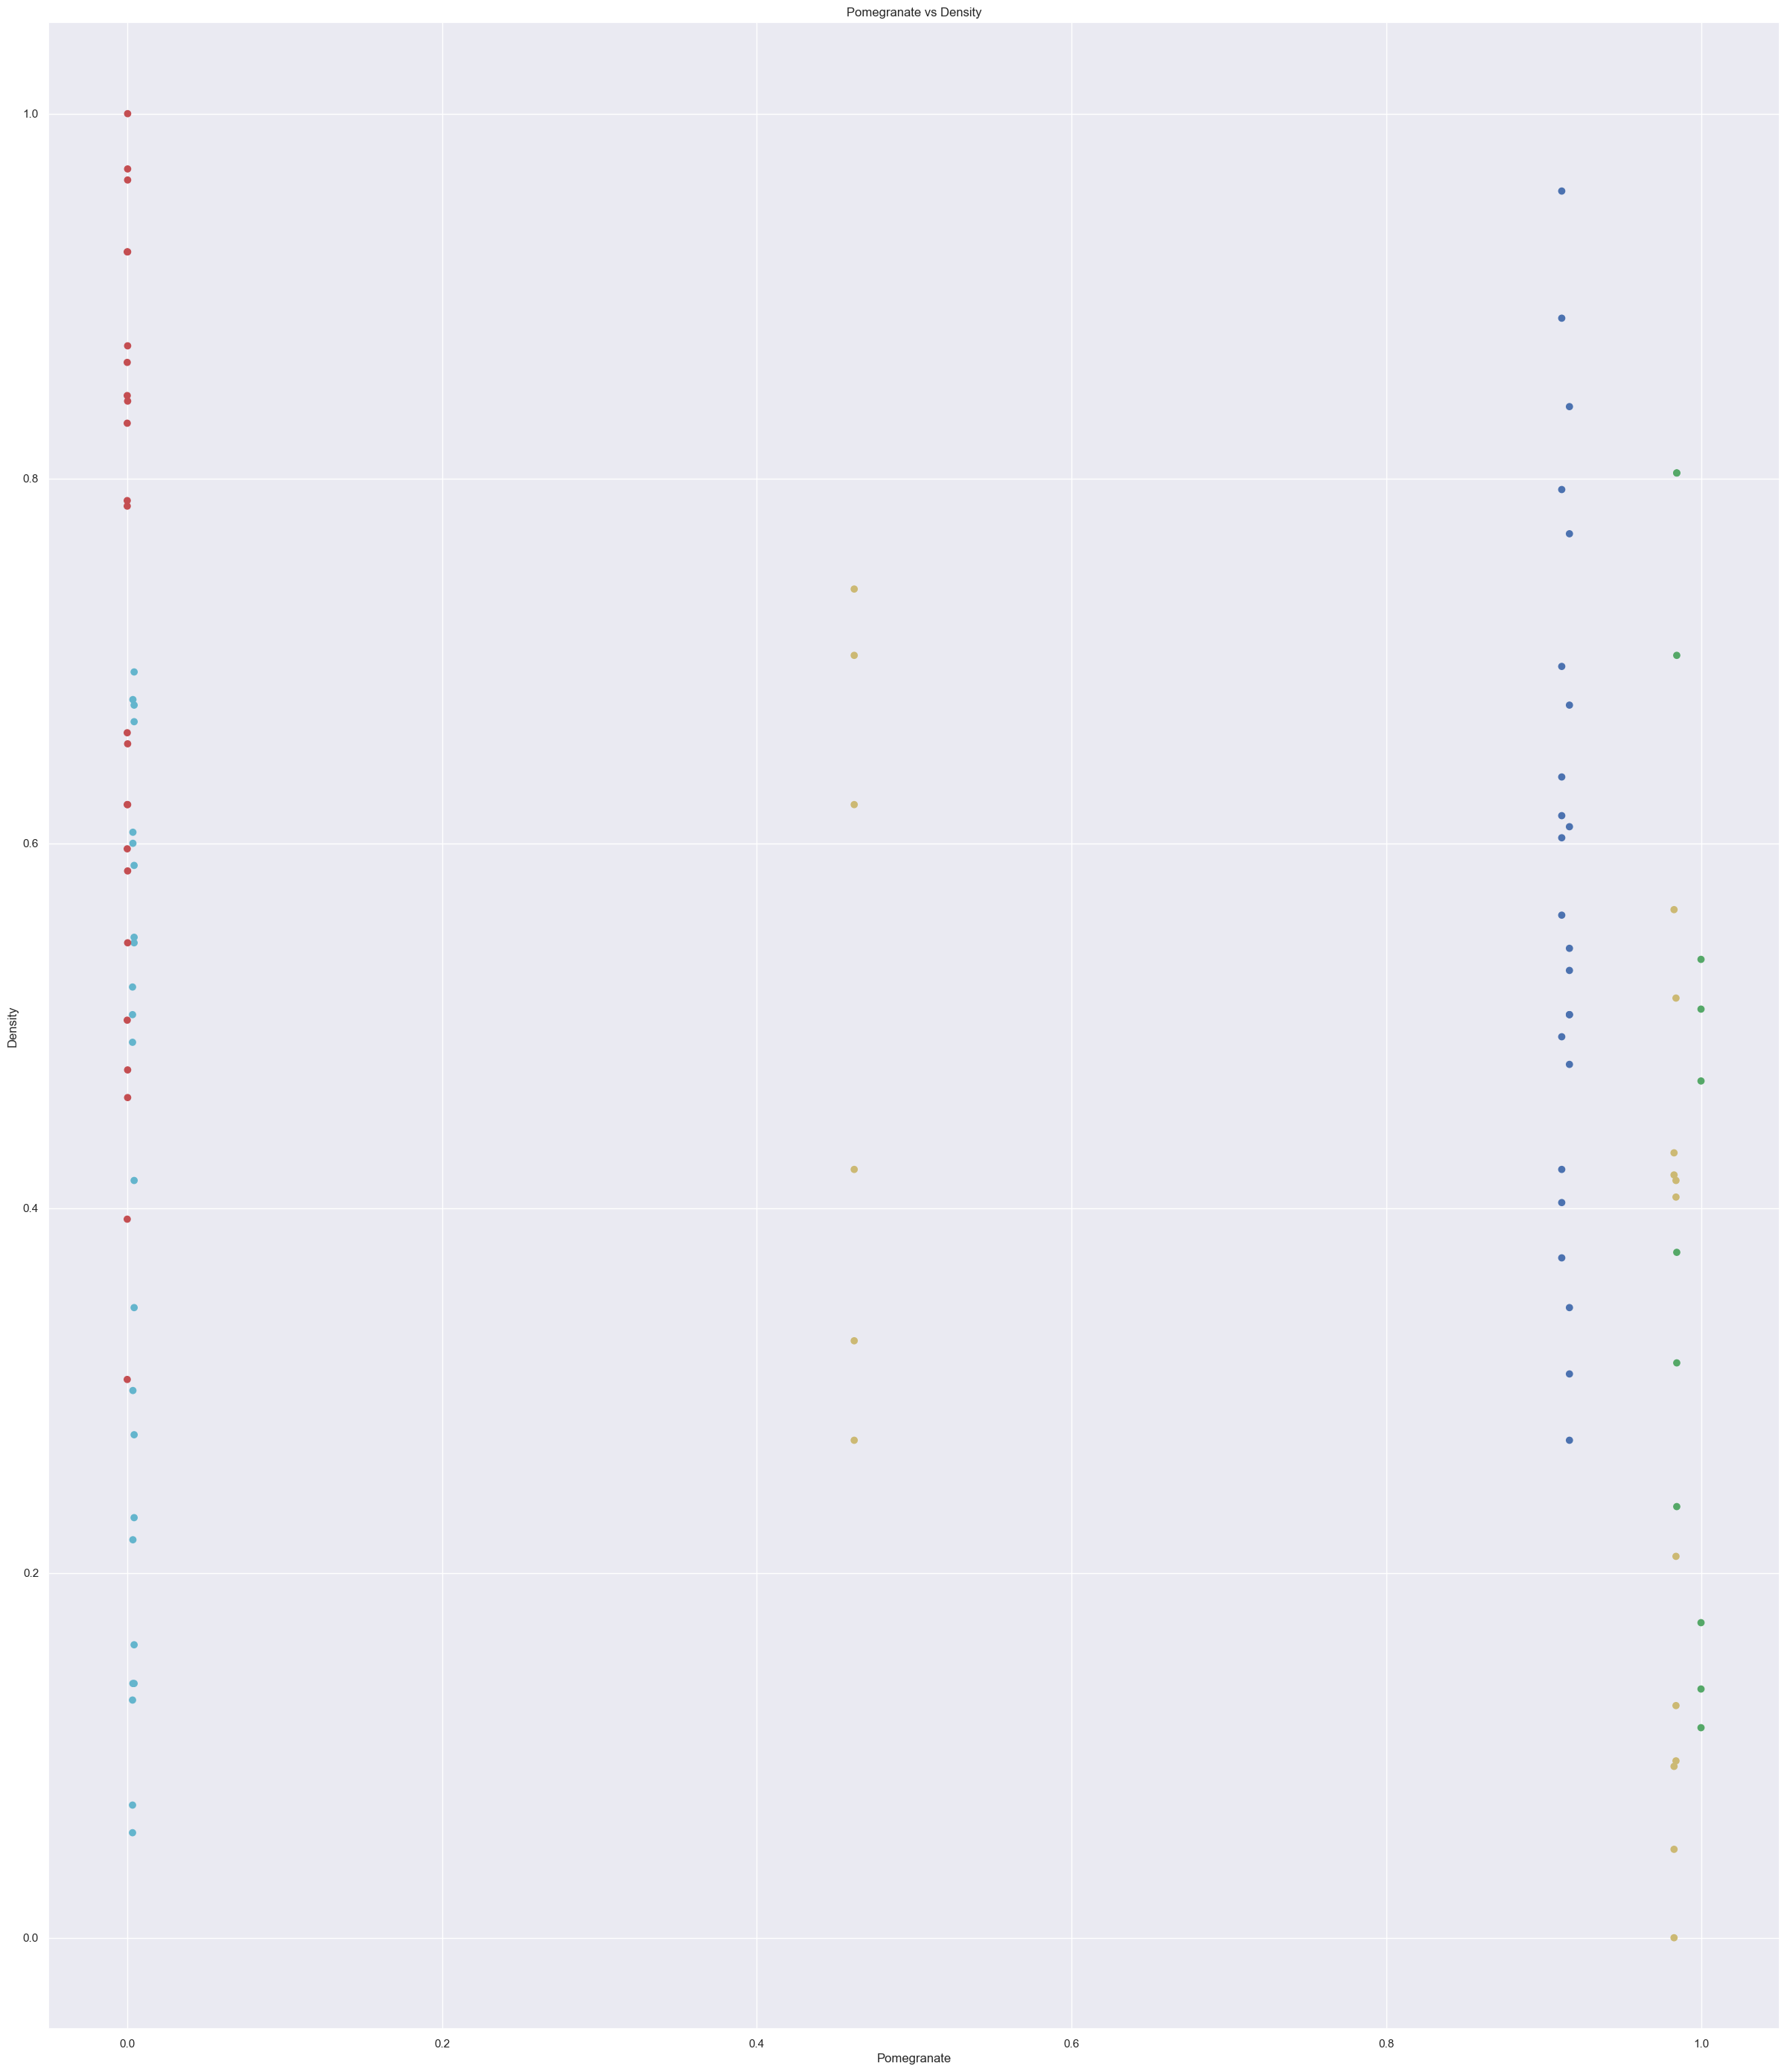

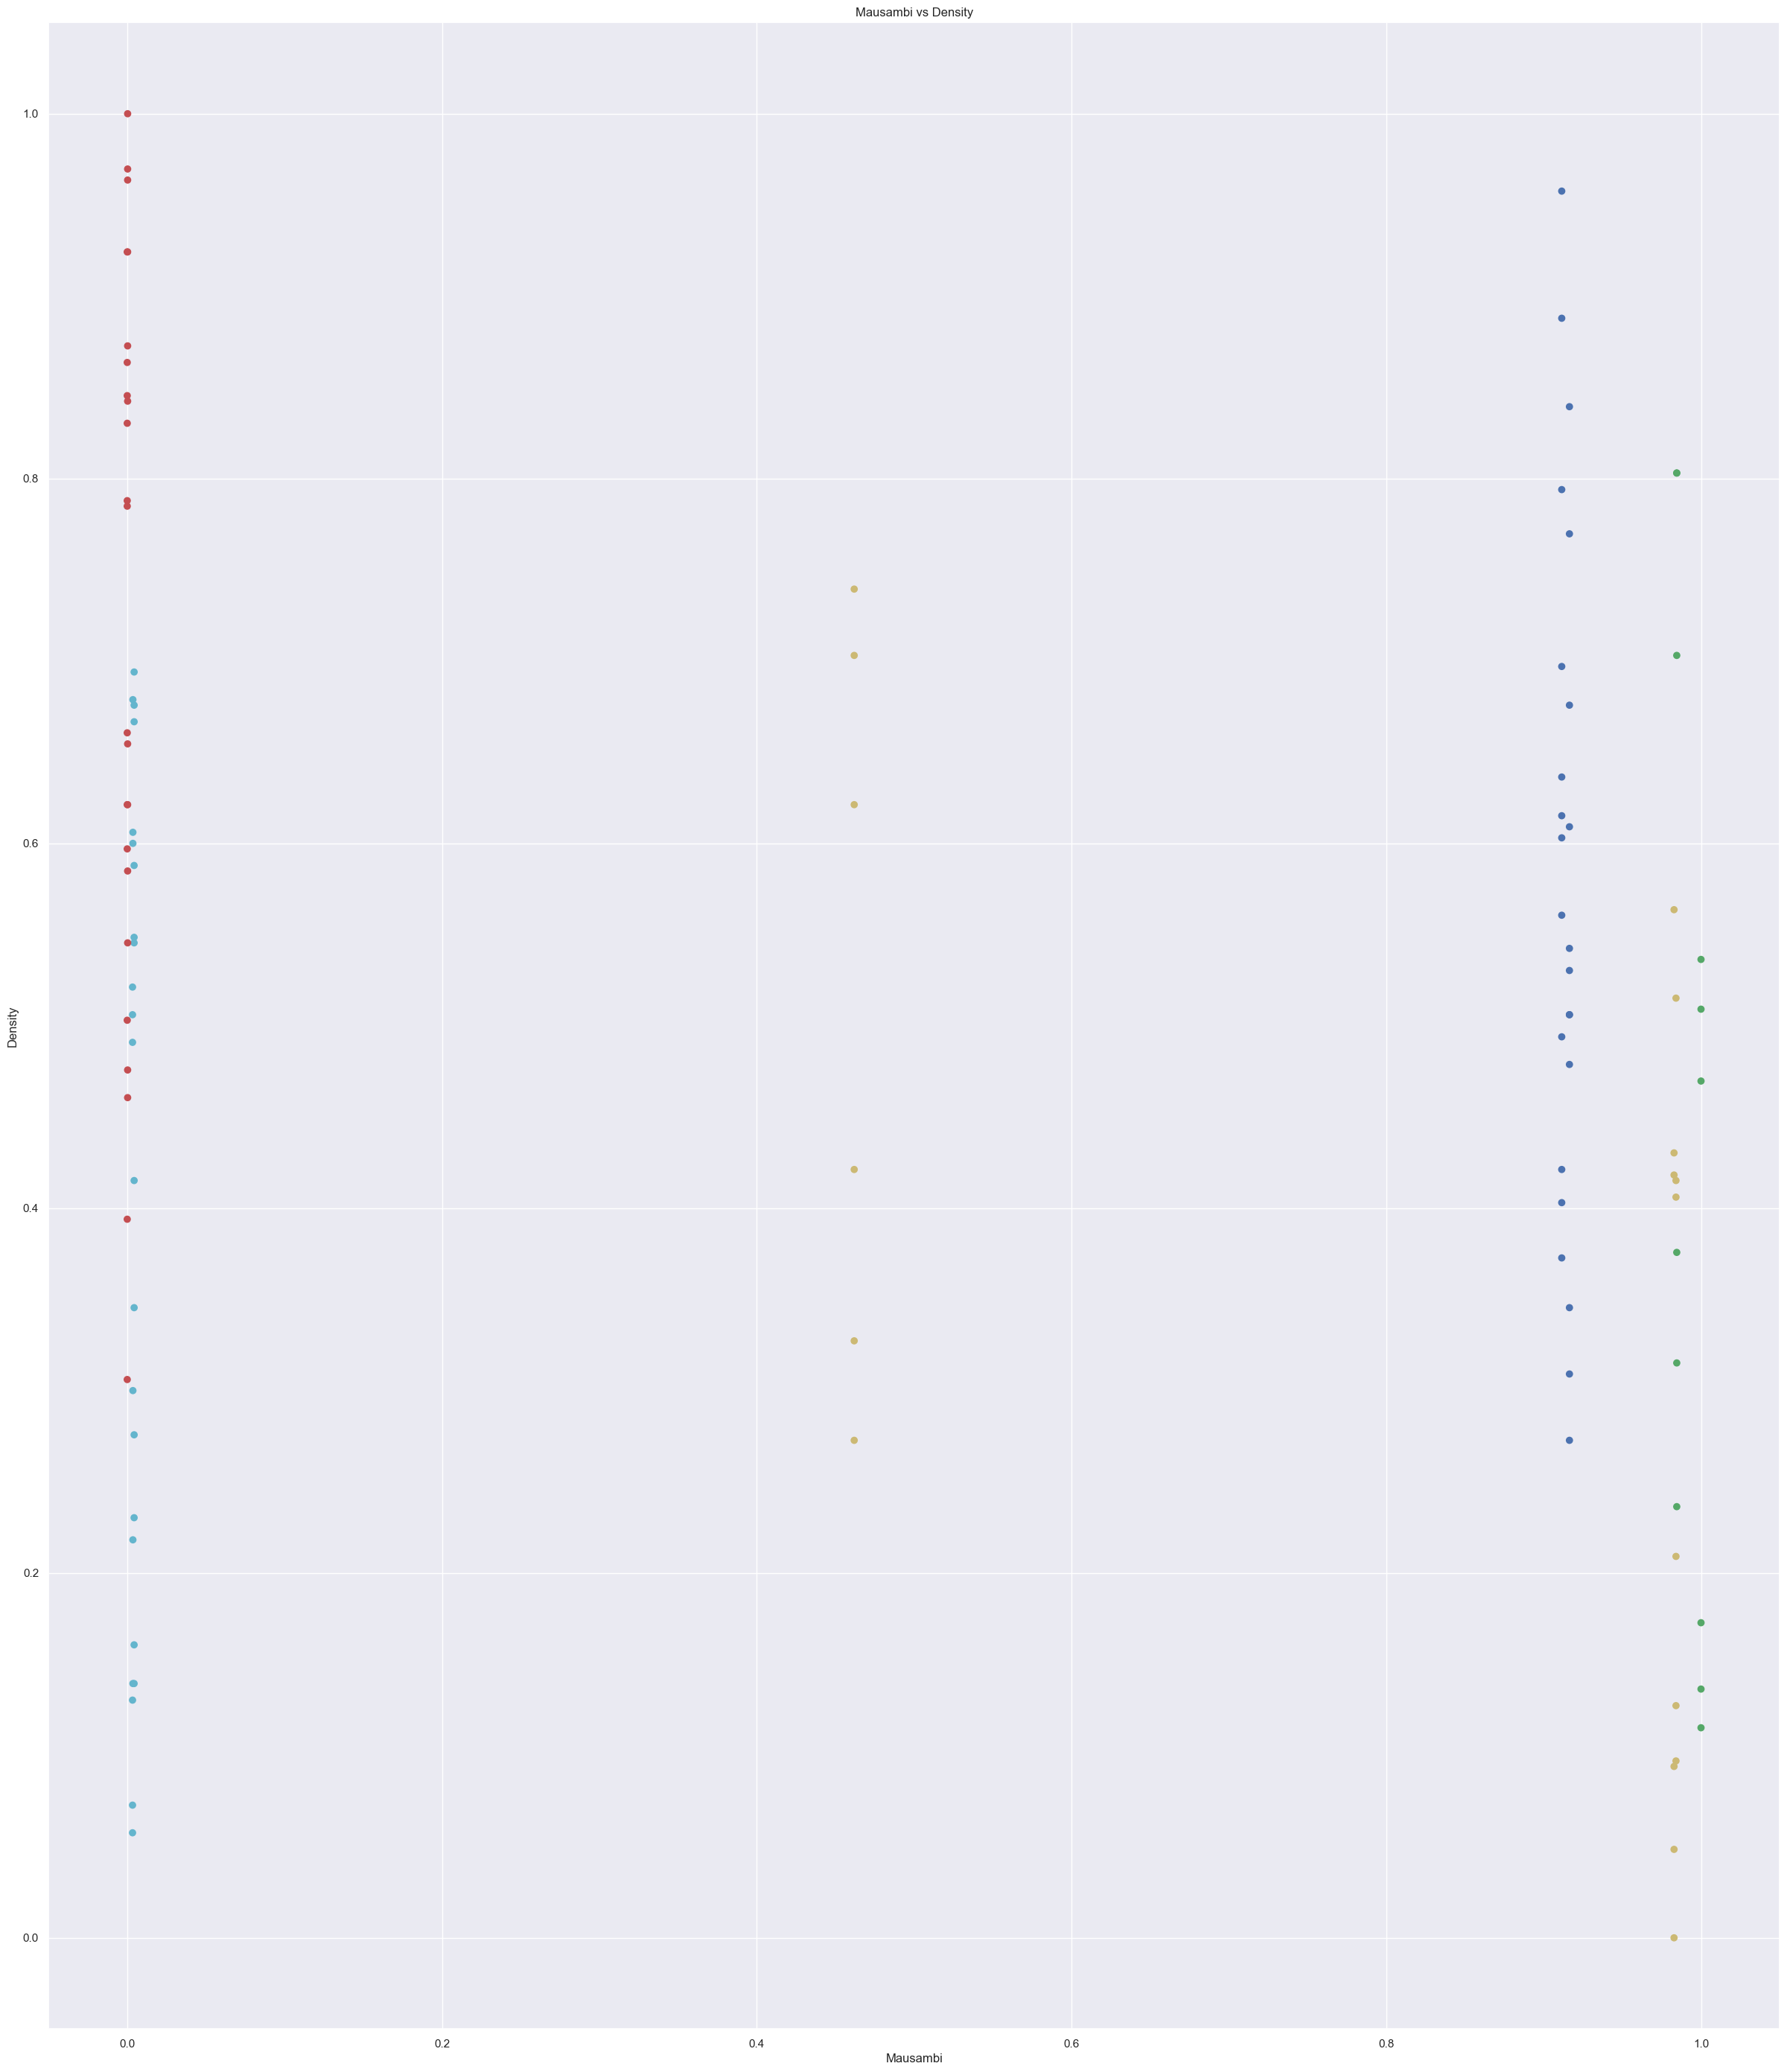

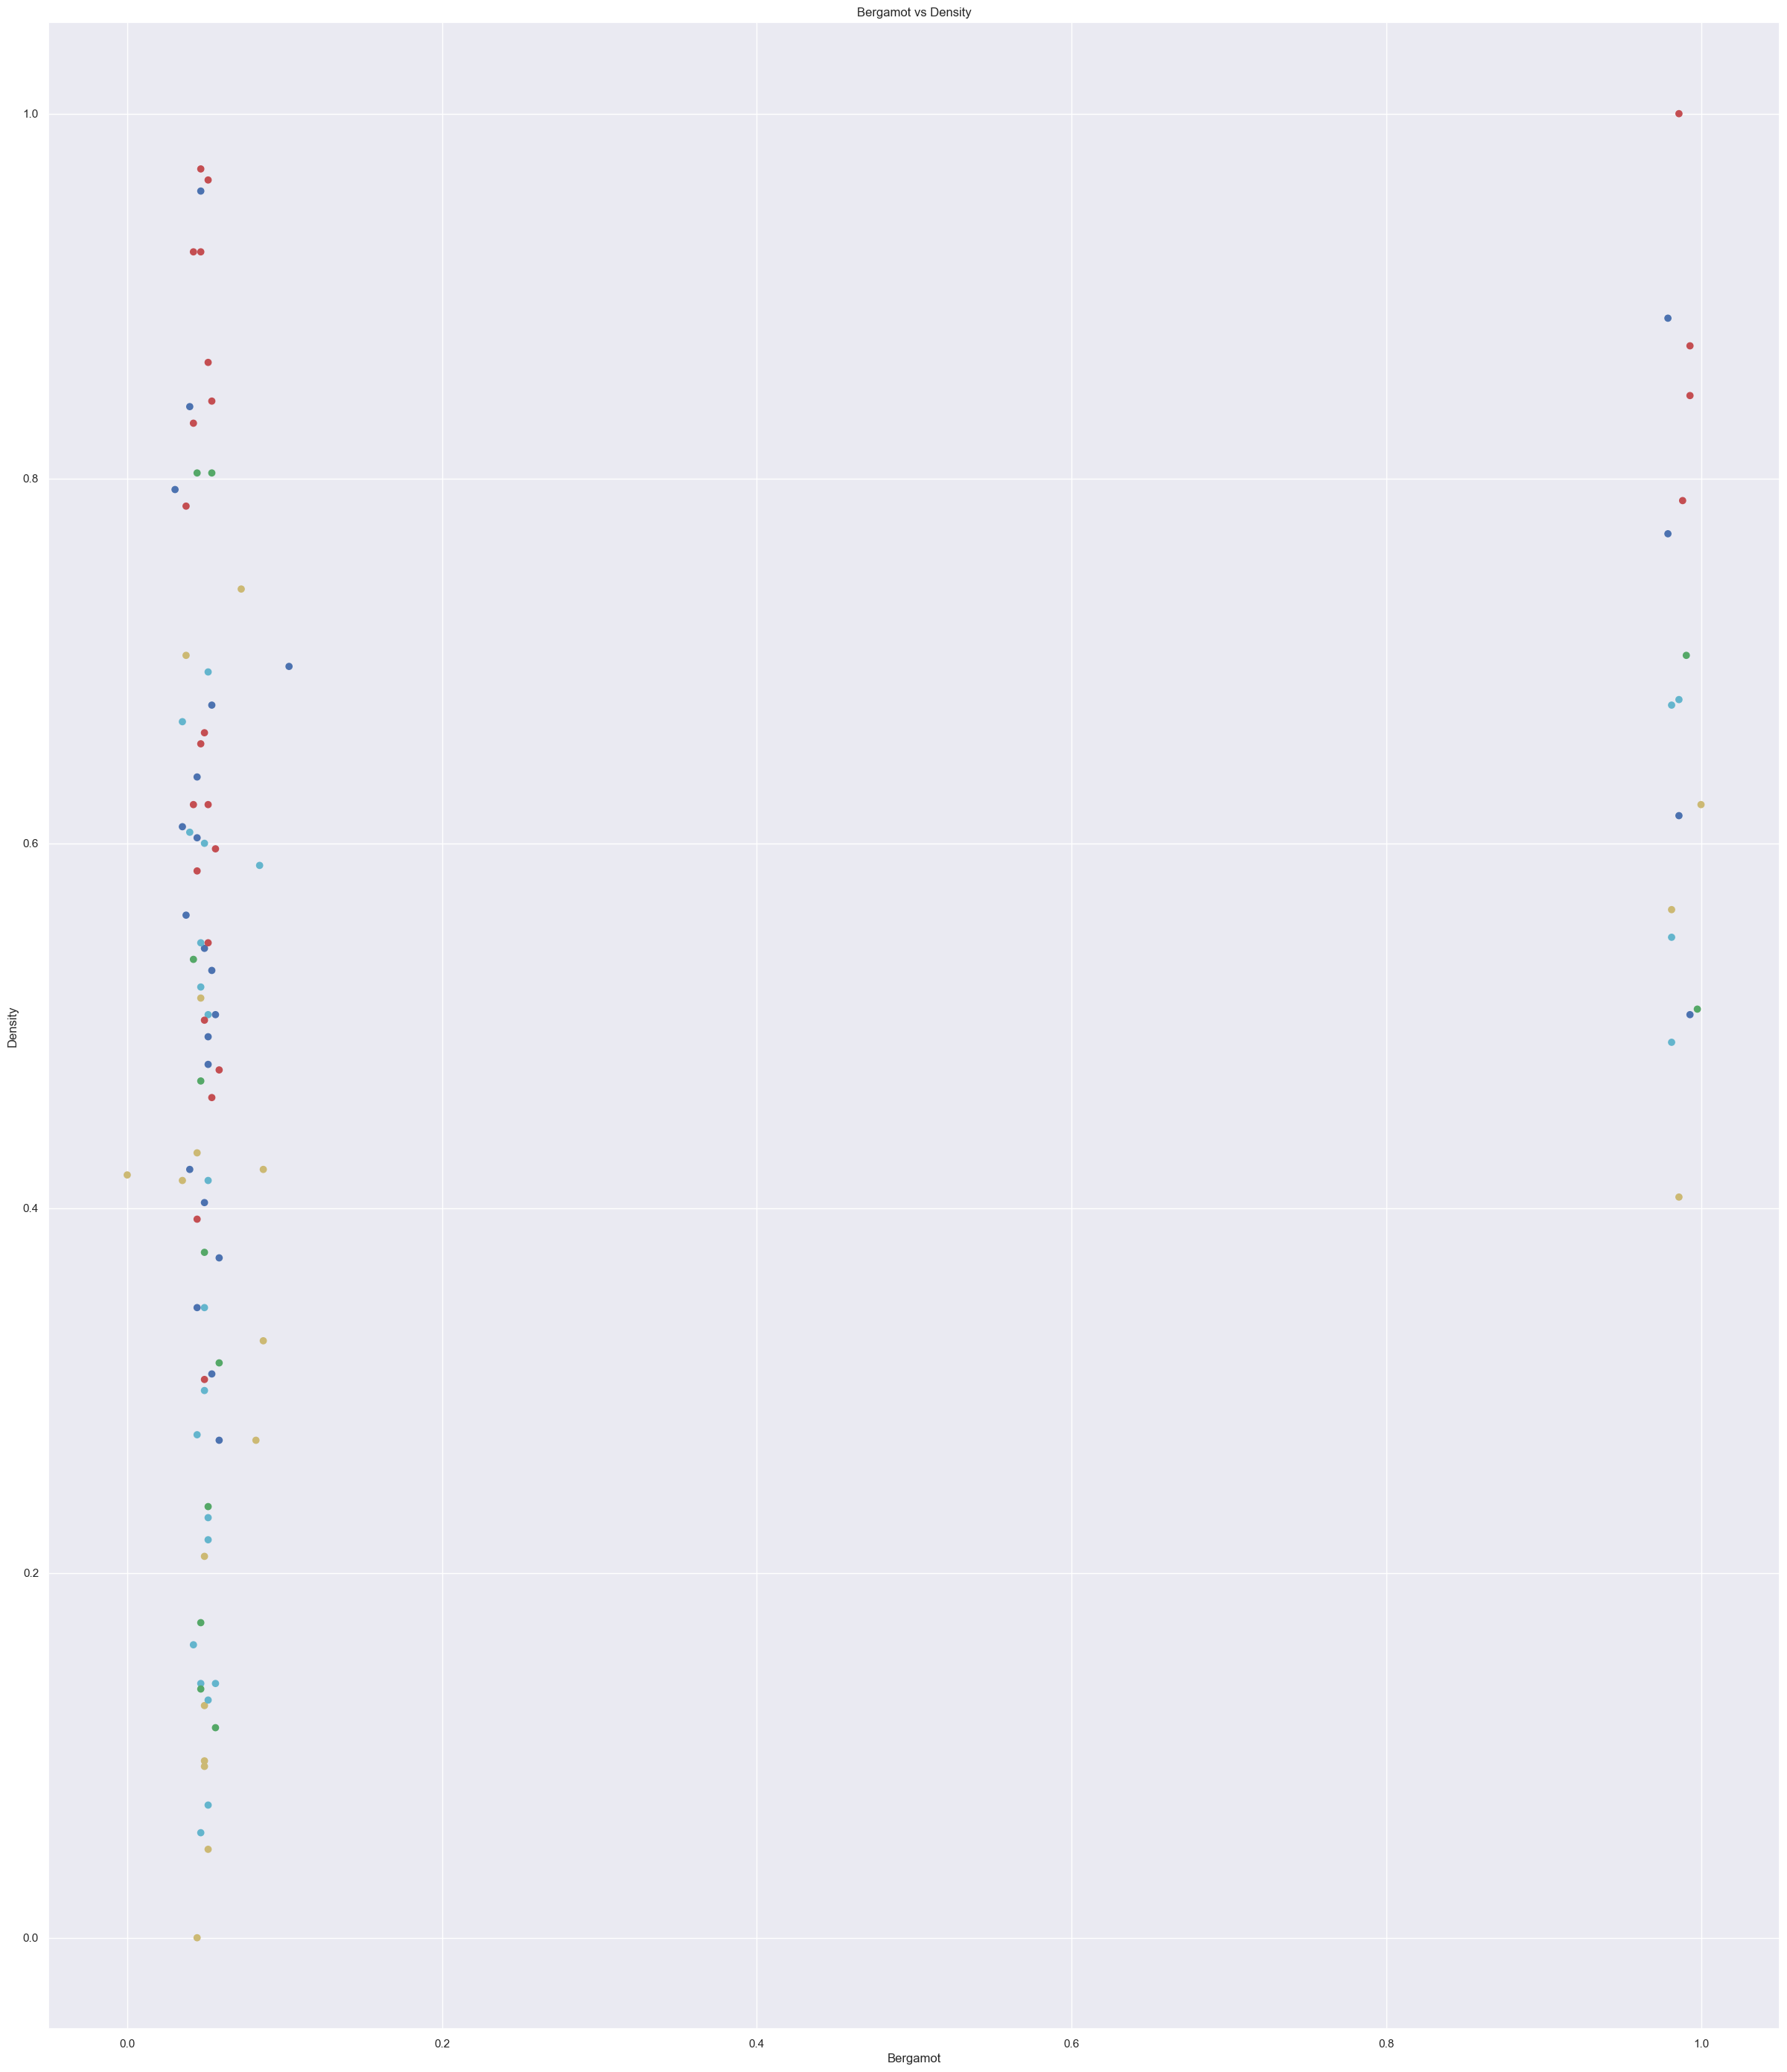

In [31]:
colour = np.array(['r','g','b','y','c'])

for column in ipp_df.columns:
  plt.scatter(ipp_df[column],ipp_df['Density'], color=colour[fp.labels])
  plt.title(column+" vs Density")
  plt.xlabel(column)
  plt.ylabel('Density')
  plt.show()

Looking at these plots we can say that the following variables are continuous:
Rice, Xanthan, Electrolyte, Chocolate, Goji, Linseed, Oats, Flax, Whey, Density
The following are can be treated as categorical variables:
Mausambi, Pomegranate, Pineapple, Gooseberry, Cherry, Tapioca, Prune, Kiwi, Starfruit, Grape, Celery, Mango, Pear, Banana, Bergamot, Wheat

Now we can take the continuous variables and the find the first ~80 points closest to the 0.5 quantile of the data. This will be the training set. The rest will be the extrapolation set. We can split the training set into 80:20 for train and testing subsets.

In [62]:
continuous_vars = ['Rice', 'Xanthan', 'Electrolyte', 'Chocolate', 'Goji', 'Linseed', 'Oats', 'Flax', 'Whey']
ipp_quantiles = ipp_df[continuous_vars].quantile([0.5])
steps = np.array([(np.max(ipp_df[column])-np.min(ipp_df[column]))/5 for column in continuous_vars])

#train_ipp = ipp_df.iloc[:,(ipp_df.columns != 'X') & (ipp_df.columns != 'Density')& (ipp_df.columns != 'Celery')]
train_ipp = ipp_df
step_num = 3
i=0
for i in range(len(continuous_vars)):
  name = continuous_vars[i]
  train_ipp = train_ipp[(train_ipp[name]>(ipp_quantiles[name].iloc[0]-steps[i]*step_num)) & (train_ipp[name] < (ipp_quantiles[name].iloc[0]+steps[i]*step_num))]
  print(name,train_ipp.shape)
test_ipp = train_ipp.iloc[60:,:]
train_ipp = train_ipp.iloc[:60,:]

Rice (102, 25)
Xanthan (102, 25)
Electrolyte (102, 25)
Chocolate (99, 25)
Goji (97, 25)
Linseed (97, 25)
Oats (88, 25)
Flax (86, 25)
Whey (81, 25)


In [63]:
print(train_ipp)

        Whey      Flax     Wheat      Oats   Linseed      Goji  Bergamot   
1   0.652778  0.187552         0  0.104175  0.698214  0.407925  0.049065  \
4   0.743056  0.083135  0.871935  0.124365  0.478571  0.386946  0.046729   
5   0.673611  0.035598  0.156274  0.096859  0.485714  0.678322  0.046729   
7   0.763889  0.096346         0  0.182388  0.896429  0.519814  0.046729   
8   0.763889  0.091979  0.139967  0.160461  0.780357  0.536131  0.049065   
9   0.777778  0.062241  0.369535  0.163105  0.826786  0.319347  0.049065   
10  0.645833  0.059698   0.36797  0.099118    0.2875  0.298368  0.044393   
11  0.694444  0.147145         0  0.070685  0.560714  0.421911  0.053738   
12  0.638889  0.128241  0.345461  0.119443  0.251786  0.365967  0.053738   
13  0.680556  0.138909  0.133371   0.12674  0.657143  0.310023  0.049065   
14  0.680556  0.125587  0.335689  0.094678  0.666071  0.328671  0.051402   
15  0.736111  0.273285         0  0.187658  0.680357  0.414918  0.985981   
17  0.791667

In [64]:
df_all = ipp_df.merge(train_ipp.drop_duplicates(), on=ipp_df.columns.to_list(),
                   how='left', indicator=True)
df_all = df_all[df_all['_merge'] == 'left_only'].drop('_merge', axis=1)
df_all = df_all.merge(test_ipp.drop_duplicates(), on=ipp_df.columns.to_list(),
                   how='left', indicator=True)
extrap_ipp = df_all[df_all['_merge'] == 'left_only'].drop('_merge', axis=1)
print(extrap_ipp)

        Whey      Flax     Wheat      Oats   Linseed      Goji  Bergamot   
0     0.0625  0.151235   0.32101  0.156504  0.583929  0.298368  0.051402  \
1   0.097222  0.127577  0.816066  0.123883  0.564286  0.272727  0.044393   
2   0.618056   0.64358         0  0.646399  0.971429  0.358974  0.042056   
3   0.666667  0.915317         0  0.831934  0.771429         1   0.03972   
4   0.673611         1         0  0.790125  0.921429  0.550117  0.030374   
5   0.020833  0.151014   0.13112  0.160596  0.580357  0.410256  0.049065   
6   0.034722  0.900835         0  0.835679  0.769643  0.529138         0   
7   0.486111  0.633741         0   0.82485    0.7875  0.531469  0.051402   
8   0.736111   0.77685         0         1         1  0.403263  0.035047   
9   0.756944  0.859046         0   0.84116  0.410714  0.307692  0.042056   
10  0.659722  0.188547         0  0.317061  0.417857  0.997669  0.985981   
11  0.965278  0.777182         0  0.836586  0.594643   0.67366  0.102804   
12  0.736111

In [65]:
#np.savetxt(r'Test_Data_Final/pg_data/pg_train.txt', train_ipp, fmt="%.6g")
#np.savetxt(r'Test_Data_Final/pg_data/pg_test.txt', test_ipp, fmt="%.6g")
np.savetxt(r'Test_Data_Final/pg_data/pg_extrap.txt', extrap_ipp, fmt="%.6g")

For the dimless groups


In [57]:
columns_with_units = [0, 1, 3, 4, 6, 9, 19, 22, 23, 25]
columns_with_units = [train_ipp.columns[i] for i in columns_with_units]
dimless_files = glob.glob("Test_Data/pg_data/*_dimless_set*.txt")
#print(dimless_files)
train_data_without_units = train_ipp.drop(columns_with_units, axis=1, inplace=False)
extrap_data_without_units = extrap_ipp.drop(columns_with_units, axis=1, inplace=False)
print(train_data_without_units.head())
extrap_data_without_units.head()
# data_without_units = None
# for file in dimless_files:
#   if "train" in file:
#     data_without_units = train_data_without_units
#   else:
#     data_without_units = extrap_data_without_units
#   data = pd.read_csv(file, sep=" ", header=None)
#   #print(data_without_units.shape,data.shape)
#   #full_set = pd.concat([data, data_without_units], ignore_index=True, sort=False,axis=1)
#   #full_set[full_set['_merge'] == 'left_only'].drop('_merge', axis=1)
#   full_set = np.zeros((data.shape[0],data.shape[1]+data_without_units.shape[1]))
#   full_set[:,:data_without_units.shape[1]] = data_without_units.values
#   full_set[:,data_without_units.shape[1]:] = data.values
#   # print(full_set.shape)
#   # print(full_set)
#   np.savetxt(file, full_set)

      Wheat      Goji Chocolate    Banana      Kiwi Pineapple      Pear   
1 -0.968199  0.342534 -0.493248 -0.651093   2.43881  0.870894  8.320686  \
4   3.01532  0.099374 -0.322655  1.445601  4.497046 -0.607226  5.505208   
5 -0.254248  3.476608 -0.710367  1.445601  4.497046   2.39411 -2.042315   
7 -0.968199  1.639393 -1.485792  1.429212  1.735883  0.971106  8.511638   
8 -0.328745  1.828518  -0.16757  1.429212  1.735883  0.971106  8.511638   

     Cherry     Mango    Celery     Grape Electrolyte Gooseberry   Xanthan   
1  0.576189  -3.21328 -0.255418  4.366653    0.562479   0.481613 -2.620135  \
4  0.692855  -3.18539 -0.255418  5.819132    0.581466  -0.912941 -3.934974   
5 -4.893449  1.999945 -0.255418  5.819132      0.3821   1.918713  -4.90088   
7 -4.826539  1.999945 -0.255418  4.452612     0.14476   0.576159 -2.564249   
8 -4.826539  1.999945 -0.255418  4.452612    0.211215   0.576159  -2.61774   

       Rice  Mausambi  
1 -0.957766 -2.015178  
4 -3.677428 -2.009473  
5 -4.014

Wheat      Goji Chocolate    Banana      Kiwi Pineapple      Pear   
1   0.498365 -0.927306  0.716414 -0.651093  4.502022 -0.607226  5.505208  \
2    2.76008 -1.224502  1.460822 -0.651093  4.502022 -0.607226  5.505208   
5  -0.968199 -0.224841  3.368367  1.445601  4.497046   2.39411 -2.042315   
15 -0.968199  7.205075  0.576838 -0.651093   2.43881  0.870894  8.320686   
21 -0.968199  1.990625  0.778448 -0.651093 -2.960583 -1.714563  3.391902   

      Cherry     Mango    Celery     Grape Electrolyte Gooseberry   Xanthan   
1  -4.821265  1.999945 -0.255418  5.819132    0.391594  -0.912941 -3.828719  \
2  -4.821265  1.999945 -0.255418  5.819132    0.458049  -0.912941 -3.749655   
5  -4.893449  1.999945 -0.255418  5.819132    0.372606   1.918713 -3.948524   
15  0.576189  -3.21328 -0.255418  4.366653    0.733364   0.481613 -4.468064   
21 -2.949436  4.077174 -0.255418  2.160385   -0.415363  -1.957675   1.60579   

        Rice  Mausambi  
1  -1.903866  5.210483  
2  -1.875099  5.210483  
5  -3.709244   5.33695  
15 -1.637471 -2.015178  
21  2.013517  4.683904

In [12]:
columns_with_units

['Whey',
 'Flax',
 'Oats',
 'Linseed',
 'Bergamot',
 'Chocolate',
 'Electrolyte',
 'Xanthan',
 'Rice',
 'Density']

In [38]:
lst = "pg_data/dimless_extrap_set.txt"
"train" in lst

False

Do some variable selection

In [6]:
from sklearn import linear_model
clf = linear_model.Lasso(alpha=0.1)
clf.fit(ipp_df.to_numpy()[:,:-1], ipp_df.to_numpy()[:,-1])
print(clf.coef_)

[ 0.          0.         -0.63593143  0.          0.          0.
  0.06018764 -0.05900844 -0.          0.         -0.         -0.
 -0.05434696  0.08823579 -0.          0.         -0.          0.
 -0.         -0.04856607  0.          0.34031443  0.         -0.
 -0.        ]
1.6285572016949716


In [25]:
saved_data = pd.read_csv("Test_Data_Final/pg_data/pg_train.txt",sep=" ", header=None)
indexes = [2,9,10,18,20,24]
print(saved_data[indexes].head())
np.savetxt(r'Test_Data_Final/pg_data_reduced/pg_reduced_train.txt', saved_data[indexes], fmt="%.6g")
saved_data = pd.read_csv("Test_Data_Final/pg_data/pg_test.txt",sep=" ", header=None)
np.savetxt(r'Test_Data_Final/pg_data_reduced/pg_reduced_test.txt', saved_data[indexes], fmt="%.6g")
saved_data = pd.read_csv("Test_Data_Final/pg_data/pg_extrap.txt",sep=" ", header=None)
np.savetxt(r'Test_Data_Final/pg_data_reduced/pg_reduced_extrap.txt', saved_data[indexes], fmt="%.6g")

         2       9         10        18        20        24
0  0.000000  1.0000  0.723527  1.000000  0.475431  0.600000
1  0.871935  0.8019  0.999333  0.939510  0.052420  0.139394
2  0.156274  0.8019  0.999333  0.938853  0.000000  0.172727
3  0.000000  1.0000  0.629333  0.930350  0.197692  0.515152
4  0.139967  1.0000  0.629333  0.930350  0.195256  0.209091


In [11]:
print(list(ipp_units))

['T', 'kg*s^(-1)', '-', 'T', 'T', '-', 'kg*m^(-1)*s^(-2)', 'm', '-', '-', '-', '-', '-', '-', '-', '-', 'T', '-', '-', 'kg*m^(-3)', 'kg*m^(-3)', '-', '-', '-', 'kg*m^(-3)']


In [12]:
list_units = list(ipp_units)
[i for i in range(len(ipp_units)) if list_units[i] != '-']

[0, 1, 3, 4, 6, 7, 16, 19, 20, 24]

In [7]:
print(ipp_units[[2,9,10,18,20,24]])

Wheat              -
Tapioca            -
Kiwi               -
Prune              -
Rice       kg*m^(-3)
Density    kg*m^(-3)
Name: 0, dtype: object


In [2]:
saved_data = pd.read_csv("Test_Data_Final/pg_data/pg_train.txt",sep=" ", header=None)
indexes = [2,20,24]
print(saved_data[indexes].head())
np.savetxt(r'Test_Data_Final/pg_data_minimal/pg_minimal_train.txt', saved_data[indexes], fmt="%.6g")
saved_data = pd.read_csv("Test_Data_Final/pg_data/pg_test.txt",sep=" ", header=None)
np.savetxt(r'Test_Data_Final/pg_data_minimal/pg_minimal_test.txt', saved_data[indexes], fmt="%.6g")
saved_data = pd.read_csv("Test_Data_Final/pg_data/pg_extrap.txt",sep=" ", header=None)
np.savetxt(r'Test_Data_Final/pg_data_minimal/pg_minimal_extrap.txt', saved_data[indexes], fmt="%.6g")

         2         20        24
0  0.000000  0.475431  0.600000
1  0.871935  0.052420  0.139394
2  0.156274  0.000000  0.172727
3  0.000000  0.197692  0.515152
4  0.139967  0.195256  0.209091
